##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Playing CartPole with the Actor-Critic Method


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method using TensorFlow to train an agent on the [Open AI Gym](https://gym.openai.com/) CartPole-V0 environment.
The reader is assumed to have some familiarity with [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of reinforcement learning. 


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function. 

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**CartPole-v0**

In the [CartPole-v0 environment](https://www.gymlibrary.ml/environments/classic_control/cart_pole/), a pole is attached to a cart moving along a frictionless track. 
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart. 
A reward of +1 is given for every time step the pole remains upright.
An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.

<center>
  <figure>
    <image src="https://tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif">
    <figcaption>
      Trained actor-critic model in Cartpole-v0 environment
    </figcaption>
  </figure>
</center>


The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [2]:
!pip install gym[classic_control]
!pip install pyglet

  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 \

 done


  Preparing metadata (pyproject.toml) ... -

 \

 |

 /

 done


 \

 |

 /

 -

 \

 done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793137 sha256=331131affa9d9a418868898dfea532c893d1ceccc90206fdbdd1e6de3164833b
  Stored in directory: /home/kbuilder/.cache/pip/wheels/81/10/18/36362eda933f72e09d7c60b5fc9eaf22bf5876ee2450d6da60
Successfully built gym


In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/utils/image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/utils/image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/util

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/gym/envs/registration.py:564: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


## Model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and critic value respectively. This tutorial uses model subclassing to define the model. 

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For Cartpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (0) and right (1) respectively.

Refer to [OpenAI Gym's CartPole-v0 wiki page](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) for more information.


In [5]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## Training

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined actor-critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collecting training data

As in supervised learning, in order to train the actor-critic model, you need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

This process is implemented in the `run_episode` function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that `tf.TensorArray`s were used to support Tensor iteration on variable length arrays.

In [7]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. Computing expected returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [9]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. The actor-critic loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

The actor loss is based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Defining the training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This tutorial uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

The `tf.function` context is applied to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [12]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 0:   0%|          | 0/10000 [00:02<?, ?it/s]

Episode 0:   0%|          | 0/10000 [00:02<?, ?it/s, episode_reward=40, running_reward=40]

Episode 0:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=40, running_reward=40]

Episode 1:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=40, running_reward=40]

Episode 1:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=40, running_reward=40]

Episode 2:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=40, running_reward=40]

Episode 2:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=18, running_reward=32.7]

Episode 3:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=18, running_reward=32.7]

Episode 3:   0%|          | 1/10000 [00:02<7:49:49,  2.82s/it, episode_reward=25, running_reward=30.8]

Episode 3:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=25, running_reward=30.8]

Episode 4:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=25, running_reward=30.8]

Episode 4:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=21, running_reward=28.8]

Episode 5:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=21, running_reward=28.8]

Episode 5:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=13, running_reward=26.2]

Episode 6:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=13, running_reward=26.2]

Episode 6:   0%|          | 4/10000 [00:02<1:33:31,  1.78it/s, episode_reward=15, running_reward=24.6]

Episode 7:   0%|          | 4/10000 [00:03<1:33:31,  1.78it/s, episode_reward=15, running_reward=24.6]

Episode 7:   0%|          | 4/10000 [00:03<1:33:31,  1.78it/s, episode_reward=17, running_reward=23.6]

Episode 8:   0%|          | 4/10000 [00:03<1:33:31,  1.78it/s, episode_reward=17, running_reward=23.6]

Episode 8:   0%|          | 4/10000 [00:03<1:33:31,  1.78it/s, episode_reward=11, running_reward=22.2]

Episode 8:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=11, running_reward=22.2]  

Episode 9:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=11, running_reward=22.2]

Episode 9:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=32, running_reward=23.2]

Episode 10:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=32, running_reward=23.2]

Episode 10:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=17, running_reward=22.6]

Episode 11:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=17, running_reward=22.6]

Episode 11:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=17, running_reward=22.2]

Episode 12:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=17, running_reward=22.2]

Episode 12:   0%|          | 9/10000 [00:03<34:15,  4.86it/s, episode_reward=9, running_reward=21.2] 

Episode 12:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=9, running_reward=21.2]

Episode 13:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=9, running_reward=21.2]

Episode 13:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=13, running_reward=20.6]

Episode 14:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=13, running_reward=20.6]

Episode 14:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=13, running_reward=20.1]

Episode 15:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=13, running_reward=20.1]

Episode 15:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=61, running_reward=22.6]

Episode 16:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=61, running_reward=22.6]

Episode 16:   0%|          | 13/10000 [00:03<21:22,  7.79it/s, episode_reward=18, running_reward=22.4]

Episode 16:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=18, running_reward=22.4]

Episode 17:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=18, running_reward=22.4]

Episode 17:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=22, running_reward=22.3]

Episode 18:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=22, running_reward=22.3]

Episode 18:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=17, running_reward=22.1]

Episode 19:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=17, running_reward=22.1]

Episode 19:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=11, running_reward=21.5]

Episode 20:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=11, running_reward=21.5]

Episode 20:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=18, running_reward=21.3]

Episode 21:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=18, running_reward=21.3]

Episode 21:   0%|          | 17/10000 [00:03<15:36, 10.66it/s, episode_reward=52, running_reward=22.7]

Episode 21:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=52, running_reward=22.7]

Episode 22:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=52, running_reward=22.7]

Episode 22:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=12, running_reward=22.3]

Episode 23:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=12, running_reward=22.3]

Episode 23:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=18, running_reward=22.1]

Episode 24:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=18, running_reward=22.1]

Episode 24:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=10, running_reward=21.6]

Episode 25:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=10, running_reward=21.6]

Episode 25:   0%|          | 22/10000 [00:03<11:30, 14.45it/s, episode_reward=44, running_reward=22.5]

Episode 25:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=44, running_reward=22.5]

Episode 26:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=44, running_reward=22.5]

Episode 26:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=11, running_reward=22]  

Episode 27:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=11, running_reward=22]

Episode 27:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=16, running_reward=21.8]

Episode 28:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=16, running_reward=21.8]

Episode 28:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=14, running_reward=21.6]

Episode 29:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=14, running_reward=21.6]

Episode 29:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=9, running_reward=21.1] 

Episode 30:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=9, running_reward=21.1]

Episode 30:   0%|          | 26/10000 [00:03<09:22, 17.73it/s, episode_reward=21, running_reward=21.1]

Episode 30:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=21, running_reward=21.1]

Episode 31:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=21, running_reward=21.1]

Episode 31:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=13, running_reward=20.9]

Episode 32:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=13, running_reward=20.9]

Episode 32:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=32, running_reward=21.2]

Episode 33:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=32, running_reward=21.2]

Episode 33:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=30, running_reward=21.5]

Episode 34:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=30, running_reward=21.5]

Episode 34:   0%|          | 31/10000 [00:03<07:13, 23.01it/s, episode_reward=44, running_reward=22.1]

Episode 34:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=44, running_reward=22.1]

Episode 35:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=44, running_reward=22.1]

Episode 35:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=20, running_reward=22.1]

Episode 36:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=20, running_reward=22.1]

Episode 36:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=9, running_reward=21.7] 

Episode 37:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=9, running_reward=21.7]

Episode 37:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=28, running_reward=21.9]

Episode 38:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=28, running_reward=21.9]

Episode 38:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=10, running_reward=21.6]

Episode 39:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=10, running_reward=21.6]

Episode 39:   0%|          | 35/10000 [00:03<07:07, 23.29it/s, episode_reward=25, running_reward=21.6]

Episode 39:   0%|          | 40/10000 [00:03<06:09, 26.94it/s, episode_reward=25, running_reward=21.6]

Episode 40:   0%|          | 40/10000 [00:03<06:09, 26.94it/s, episode_reward=25, running_reward=21.6]

Episode 40:   0%|          | 40/10000 [00:03<06:09, 26.94it/s, episode_reward=23, running_reward=21.7]

Episode 41:   0%|          | 40/10000 [00:04<06:09, 26.94it/s, episode_reward=23, running_reward=21.7]

Episode 41:   0%|          | 40/10000 [00:04<06:09, 26.94it/s, episode_reward=35, running_reward=22]  

Episode 42:   0%|          | 40/10000 [00:04<06:09, 26.94it/s, episode_reward=35, running_reward=22]

Episode 42:   0%|          | 40/10000 [00:04<06:09, 26.94it/s, episode_reward=33, running_reward=22.3]

Episode 43:   0%|          | 40/10000 [00:04<06:09, 26.94it/s, episode_reward=33, running_reward=22.3]

Episode 43:   0%|          | 40/10000 [00:04<06:09, 26.94it/s, episode_reward=37, running_reward=22.6]

Episode 43:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=37, running_reward=22.6]

Episode 44:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=37, running_reward=22.6]

Episode 44:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=86, running_reward=24]  

Episode 45:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=86, running_reward=24]

Episode 45:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=53, running_reward=24.6]

Episode 46:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=53, running_reward=24.6]

Episode 46:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=13, running_reward=24.4]

Episode 47:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=13, running_reward=24.4]

Episode 47:   0%|          | 44/10000 [00:04<06:24, 25.93it/s, episode_reward=15, running_reward=24.2]

Episode 47:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=15, running_reward=24.2]

Episode 48:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=15, running_reward=24.2]

Episode 48:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=48, running_reward=24.7]

Episode 49:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=48, running_reward=24.7]

Episode 49:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=31, running_reward=24.8]

Episode 50:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=31, running_reward=24.8]

Episode 50:   0%|          | 48/10000 [00:04<07:23, 22.44it/s, episode_reward=38, running_reward=25.1]

Episode 50:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=38, running_reward=25.1]

Episode 51:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=38, running_reward=25.1]

Episode 51:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=15, running_reward=24.9]

Episode 52:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=15, running_reward=24.9]

Episode 52:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=10, running_reward=24.6]

Episode 53:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=10, running_reward=24.6]

Episode 53:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=15, running_reward=24.4]

Episode 54:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=15, running_reward=24.4]

Episode 54:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=16, running_reward=24.3]

Episode 55:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=16, running_reward=24.3]

Episode 55:   1%|          | 51/10000 [00:04<07:47, 21.27it/s, episode_reward=15, running_reward=24.1]

Episode 55:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=15, running_reward=24.1]

Episode 56:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=15, running_reward=24.1]

Episode 56:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=9, running_reward=23.8] 

Episode 57:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=9, running_reward=23.8]

Episode 57:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=10, running_reward=23.6]

Episode 58:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=10, running_reward=23.6]

Episode 58:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=17, running_reward=23.5]

Episode 59:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=17, running_reward=23.5]

Episode 59:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=14, running_reward=23.3]

Episode 60:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=14, running_reward=23.3]

Episode 60:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=10, running_reward=23.1]

Episode 61:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=10, running_reward=23.1]

Episode 61:   1%|          | 56/10000 [00:04<06:16, 26.41it/s, episode_reward=17, running_reward=23]  

Episode 61:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=17, running_reward=23]

Episode 62:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=17, running_reward=23]

Episode 62:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=13, running_reward=22.8]

Episode 63:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=13, running_reward=22.8]

Episode 63:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=18, running_reward=22.8]

Episode 64:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=18, running_reward=22.8]

Episode 64:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=9, running_reward=22.6] 

Episode 65:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=9, running_reward=22.6]

Episode 65:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=16, running_reward=22.5]

Episode 66:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=16, running_reward=22.5]

Episode 66:   1%|          | 62/10000 [00:04<05:08, 32.24it/s, episode_reward=13, running_reward=22.3]

Episode 66:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=13, running_reward=22.3]

Episode 67:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=13, running_reward=22.3]

Episode 67:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=10, running_reward=22.1]

Episode 68:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=10, running_reward=22.1]

Episode 68:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=11, running_reward=22]  

Episode 69:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=11, running_reward=22]

Episode 69:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=20, running_reward=21.9]

Episode 70:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=20, running_reward=21.9]

Episode 70:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=20, running_reward=21.9]

Episode 71:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=20, running_reward=21.9]

Episode 71:   1%|          | 67/10000 [00:04<04:35, 36.10it/s, episode_reward=15, running_reward=21.8]

Episode 71:   1%|          | 72/10000 [00:04<04:19, 38.26it/s, episode_reward=15, running_reward=21.8]

Episode 72:   1%|          | 72/10000 [00:04<04:19, 38.26it/s, episode_reward=15, running_reward=21.8]

Episode 72:   1%|          | 72/10000 [00:04<04:19, 38.26it/s, episode_reward=17, running_reward=21.8]

Episode 73:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=17, running_reward=21.8]

Episode 73:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=32, running_reward=21.9]

Episode 74:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=32, running_reward=21.9]

Episode 74:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=32, running_reward=22]  

Episode 75:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=32, running_reward=22]

Episode 75:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=27, running_reward=22.1]

Episode 76:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=27, running_reward=22.1]

Episode 76:   1%|          | 72/10000 [00:05<04:19, 38.26it/s, episode_reward=25, running_reward=22.1]

Episode 76:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=25, running_reward=22.1]

Episode 77:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=25, running_reward=22.1]

Episode 77:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=36, running_reward=22.3]

Episode 78:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=36, running_reward=22.3]

Episode 78:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=37, running_reward=22.5]

Episode 79:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=37, running_reward=22.5]

Episode 79:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=46, running_reward=22.8]

Episode 80:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=46, running_reward=22.8]

Episode 80:   1%|          | 77/10000 [00:05<04:48, 34.40it/s, episode_reward=31, running_reward=22.9]

Episode 80:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=31, running_reward=22.9]

Episode 81:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=31, running_reward=22.9]

Episode 81:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=29, running_reward=23]  

Episode 82:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=29, running_reward=23]

Episode 82:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=56, running_reward=23.4]

Episode 83:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=56, running_reward=23.4]

Episode 83:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=51, running_reward=23.7]

Episode 84:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=51, running_reward=23.7]

Episode 84:   1%|          | 81/10000 [00:05<05:42, 28.95it/s, episode_reward=46, running_reward=24]  

Episode 84:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=46, running_reward=24]

Episode 85:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=46, running_reward=24]

Episode 85:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=49, running_reward=24.2]

Episode 86:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=49, running_reward=24.2]

Episode 86:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=51, running_reward=24.6]

Episode 87:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=51, running_reward=24.6]

Episode 87:   1%|          | 85/10000 [00:05<06:42, 24.61it/s, episode_reward=35, running_reward=24.7]

Episode 87:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=35, running_reward=24.7]

Episode 88:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=35, running_reward=24.7]

Episode 88:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=23, running_reward=24.7]

Episode 89:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=23, running_reward=24.7]

Episode 89:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=30, running_reward=24.7]

Episode 90:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=30, running_reward=24.7]

Episode 90:   1%|          | 88/10000 [00:05<07:18, 22.61it/s, episode_reward=57, running_reward=25.1]

Episode 90:   1%|          | 91/10000 [00:05<07:28, 22.11it/s, episode_reward=57, running_reward=25.1]

Episode 91:   1%|          | 91/10000 [00:06<07:28, 22.11it/s, episode_reward=57, running_reward=25.1]

Episode 91:   1%|          | 91/10000 [00:06<07:28, 22.11it/s, episode_reward=121, running_reward=26.1]

Episode 92:   1%|          | 91/10000 [00:06<07:28, 22.11it/s, episode_reward=121, running_reward=26.1]

Episode 92:   1%|          | 91/10000 [00:06<07:28, 22.11it/s, episode_reward=56, running_reward=26.4] 

Episode 93:   1%|          | 91/10000 [00:06<07:28, 22.11it/s, episode_reward=56, running_reward=26.4]

Episode 93:   1%|          | 91/10000 [00:06<07:28, 22.11it/s, episode_reward=69, running_reward=26.9]

Episode 93:   1%|          | 94/10000 [00:06<10:19, 16.00it/s, episode_reward=69, running_reward=26.9]

Episode 94:   1%|          | 94/10000 [00:06<10:19, 16.00it/s, episode_reward=69, running_reward=26.9]

Episode 94:   1%|          | 94/10000 [00:06<10:19, 16.00it/s, episode_reward=63, running_reward=27.3]

Episode 95:   1%|          | 94/10000 [00:06<10:19, 16.00it/s, episode_reward=63, running_reward=27.3]

Episode 95:   1%|          | 94/10000 [00:06<10:19, 16.00it/s, episode_reward=35, running_reward=27.3]

Episode 95:   1%|          | 96/10000 [00:06<10:26, 15.81it/s, episode_reward=35, running_reward=27.3]

Episode 96:   1%|          | 96/10000 [00:06<10:26, 15.81it/s, episode_reward=35, running_reward=27.3]

Episode 96:   1%|          | 96/10000 [00:06<10:26, 15.81it/s, episode_reward=43, running_reward=27.5]

Episode 97:   1%|          | 96/10000 [00:06<10:26, 15.81it/s, episode_reward=43, running_reward=27.5]

Episode 97:   1%|          | 96/10000 [00:06<10:26, 15.81it/s, episode_reward=50, running_reward=27.7]

Episode 97:   1%|          | 98/10000 [00:06<10:24, 15.85it/s, episode_reward=50, running_reward=27.7]

Episode 98:   1%|          | 98/10000 [00:06<10:24, 15.85it/s, episode_reward=50, running_reward=27.7]

Episode 98:   1%|          | 98/10000 [00:06<10:24, 15.85it/s, episode_reward=55, running_reward=28]  

Episode 99:   1%|          | 98/10000 [00:06<10:24, 15.85it/s, episode_reward=55, running_reward=28]

Episode 99:   1%|          | 98/10000 [00:06<10:24, 15.85it/s, episode_reward=36, running_reward=28.1]

Episode 99:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=36, running_reward=28.1]

Episode 100:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=36, running_reward=28.1]

Episode 100:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=18, running_reward=27.9]

Episode 101:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=18, running_reward=27.9]

Episode 101:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=31, running_reward=27.8]

Episode 102:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=31, running_reward=27.8]

Episode 102:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=16, running_reward=27.8]

Episode 103:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=16, running_reward=27.8]

Episode 103:   1%|          | 100/10000 [00:06<10:22, 15.90it/s, episode_reward=34, running_reward=27.9]

Episode 103:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=34, running_reward=27.9]

Episode 104:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=34, running_reward=27.9]

Episode 104:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=28, running_reward=27.9]

Episode 105:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=28, running_reward=27.9]

Episode 105:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=21, running_reward=28]  

Episode 106:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=21, running_reward=28]

Episode 106:   1%|          | 104/10000 [00:06<08:29, 19.43it/s, episode_reward=24, running_reward=28.1]

Episode 106:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=24, running_reward=28.1]

Episode 107:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=24, running_reward=28.1]

Episode 107:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=14, running_reward=28.1]

Episode 108:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=14, running_reward=28.1]

Episode 108:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=24, running_reward=28.2]

Episode 109:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=24, running_reward=28.2]

Episode 109:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=13, running_reward=28]  

Episode 110:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=13, running_reward=28]

Episode 110:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=12, running_reward=27.9]

Episode 111:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=12, running_reward=27.9]

Episode 111:   1%|          | 107/10000 [00:06<07:38, 21.59it/s, episode_reward=9, running_reward=27.9] 

Episode 111:   1%|          | 112/10000 [00:06<05:54, 27.87it/s, episode_reward=9, running_reward=27.9]

Episode 112:   1%|          | 112/10000 [00:06<05:54, 27.87it/s, episode_reward=9, running_reward=27.9]

Episode 112:   1%|          | 112/10000 [00:06<05:54, 27.87it/s, episode_reward=14, running_reward=27.9]

Episode 113:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=14, running_reward=27.9]

Episode 113:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=16, running_reward=27.9]

Episode 114:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=16, running_reward=27.9]

Episode 114:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=9, running_reward=27.9] 

Episode 115:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=9, running_reward=27.9]

Episode 115:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=13, running_reward=27.4]

Episode 116:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=13, running_reward=27.4]

Episode 116:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=11, running_reward=27.4]

Episode 117:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=11, running_reward=27.4]

Episode 117:   1%|          | 112/10000 [00:07<05:54, 27.87it/s, episode_reward=16, running_reward=27.3]

Episode 117:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=16, running_reward=27.3]

Episode 118:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=16, running_reward=27.3]

Episode 118:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=15, running_reward=27.3]

Episode 119:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=15, running_reward=27.3]

Episode 119:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=10, running_reward=27.3]

Episode 120:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=10, running_reward=27.3]

Episode 120:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=11, running_reward=27.2]

Episode 121:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=11, running_reward=27.2]

Episode 121:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=15, running_reward=26.8]

Episode 122:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=15, running_reward=26.8]

Episode 122:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=13, running_reward=26.8]

Episode 123:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=13, running_reward=26.8]

Episode 123:   1%|          | 118/10000 [00:07<04:47, 34.40it/s, episode_reward=10, running_reward=26.8]

Episode 123:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=10, running_reward=26.8]

Episode 124:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=10, running_reward=26.8]

Episode 124:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=15, running_reward=26.8]

Episode 125:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=15, running_reward=26.8]

Episode 125:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=10, running_reward=26.5]

Episode 126:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=10, running_reward=26.5]

Episode 126:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=17, running_reward=26.5]

Episode 127:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=17, running_reward=26.5]

Episode 127:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=14, running_reward=26.5]

Episode 128:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=14, running_reward=26.5]

Episode 128:   1%|          | 124/10000 [00:07<04:08, 39.70it/s, episode_reward=14, running_reward=26.5]

Episode 128:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=14, running_reward=26.5]

Episode 129:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=14, running_reward=26.5]

Episode 129:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=11, running_reward=26.5]

Episode 130:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=11, running_reward=26.5]

Episode 130:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=12, running_reward=26.4]

Episode 131:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=12, running_reward=26.4]

Episode 131:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=8, running_reward=26.4] 

Episode 132:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=8, running_reward=26.4]

Episode 132:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=10, running_reward=26.2]

Episode 133:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=10, running_reward=26.2]

Episode 133:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=18, running_reward=26.1]

Episode 134:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=18, running_reward=26.1]

Episode 134:   1%|▏         | 129/10000 [00:07<03:55, 41.85it/s, episode_reward=12, running_reward=25.7]

Episode 134:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=12, running_reward=25.7]

Episode 135:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=12, running_reward=25.7]

Episode 135:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=10, running_reward=25.6]

Episode 136:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=10, running_reward=25.6]

Episode 136:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=18, running_reward=25.7]

Episode 137:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=18, running_reward=25.7]

Episode 137:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=11, running_reward=25.6]

Episode 138:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=11, running_reward=25.6]

Episode 138:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=16, running_reward=25.6]

Episode 139:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=16, running_reward=25.6]

Episode 139:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=11, running_reward=25.5]

Episode 140:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=11, running_reward=25.5]

Episode 140:   1%|▏         | 135/10000 [00:07<03:34, 45.91it/s, episode_reward=11, running_reward=25.4]

Episode 140:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=11, running_reward=25.4]

Episode 141:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=11, running_reward=25.4]

Episode 141:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=10, running_reward=25.1]

Episode 142:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=10, running_reward=25.1]

Episode 142:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=10, running_reward=24.9]

Episode 143:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=10, running_reward=24.9]

Episode 143:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=9, running_reward=24.6] 

Episode 144:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=9, running_reward=24.6]

Episode 144:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=11, running_reward=23.8]

Episode 145:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=11, running_reward=23.8]

Episode 145:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=15, running_reward=23.5]

Episode 146:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=15, running_reward=23.5]

Episode 146:   1%|▏         | 141/10000 [00:07<03:26, 47.80it/s, episode_reward=15, running_reward=23.5]

Episode 146:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=15, running_reward=23.5]

Episode 147:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=15, running_reward=23.5]

Episode 147:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=10, running_reward=23.4]

Episode 148:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=10, running_reward=23.4]

Episode 148:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=20, running_reward=23.1]

Episode 149:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=20, running_reward=23.1]

Episode 149:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=9, running_reward=22.9] 

Episode 150:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=9, running_reward=22.9]

Episode 150:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=9, running_reward=22.6]

Episode 151:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=9, running_reward=22.6]

Episode 151:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=13, running_reward=22.6]

Episode 152:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=13, running_reward=22.6]

Episode 152:   1%|▏         | 147/10000 [00:07<03:16, 50.02it/s, episode_reward=12, running_reward=22.6]

Episode 152:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=12, running_reward=22.6]

Episode 153:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=12, running_reward=22.6]

Episode 153:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=17, running_reward=22.7]

Episode 154:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=17, running_reward=22.7]

Episode 154:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=16, running_reward=22.7]

Episode 155:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=16, running_reward=22.7]

Episode 155:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=11, running_reward=22.6]

Episode 156:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=11, running_reward=22.6]

Episode 156:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=15, running_reward=22.7]

Episode 157:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=15, running_reward=22.7]

Episode 157:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=13, running_reward=22.7]

Episode 158:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=13, running_reward=22.7]

Episode 158:   2%|▏         | 153/10000 [00:07<03:07, 52.52it/s, episode_reward=21, running_reward=22.8]

Episode 158:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=21, running_reward=22.8]

Episode 159:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=21, running_reward=22.8]

Episode 159:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=15, running_reward=22.8]

Episode 160:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=15, running_reward=22.8]

Episode 160:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=23, running_reward=22.9]

Episode 161:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=23, running_reward=22.9]

Episode 161:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=27, running_reward=23]  

Episode 162:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=27, running_reward=23]

Episode 162:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=18, running_reward=23]

Episode 163:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=18, running_reward=23]

Episode 163:   2%|▏         | 159/10000 [00:07<03:12, 51.24it/s, episode_reward=15, running_reward=23]

Episode 164:   2%|▏         | 159/10000 [00:08<03:12, 51.24it/s, episode_reward=15, running_reward=23]

Episode 164:   2%|▏         | 159/10000 [00:08<03:12, 51.24it/s, episode_reward=20, running_reward=23.1]

Episode 164:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=20, running_reward=23.1]

Episode 165:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=20, running_reward=23.1]

Episode 165:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=22, running_reward=23.2]

Episode 166:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=22, running_reward=23.2]

Episode 166:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=16, running_reward=23.2]

Episode 167:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=16, running_reward=23.2]

Episode 167:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=25, running_reward=23.4]

Episode 168:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=25, running_reward=23.4]

Episode 168:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=24, running_reward=23.5]

Episode 169:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=24, running_reward=23.5]

Episode 169:   2%|▏         | 165/10000 [00:08<03:34, 45.94it/s, episode_reward=28, running_reward=23.6]

Episode 169:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=28, running_reward=23.6]

Episode 170:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=28, running_reward=23.6]

Episode 170:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=28, running_reward=23.6]

Episode 171:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=28, running_reward=23.6]

Episode 171:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=23, running_reward=23.7]

Episode 172:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=23, running_reward=23.7]

Episode 172:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=27, running_reward=23.8]

Episode 173:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=27, running_reward=23.8]

Episode 173:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=19, running_reward=23.7]

Episode 174:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=19, running_reward=23.7]

Episode 174:   2%|▏         | 170/10000 [00:08<03:53, 42.05it/s, episode_reward=25, running_reward=23.6]

Episode 174:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=25, running_reward=23.6]

Episode 175:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=25, running_reward=23.6]

Episode 175:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=39, running_reward=23.8]

Episode 176:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=39, running_reward=23.8]

Episode 176:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=21, running_reward=23.7]

Episode 177:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=21, running_reward=23.7]

Episode 177:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=23, running_reward=23.6]

Episode 178:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=23, running_reward=23.6]

Episode 178:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=23, running_reward=23.4]

Episode 179:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=23, running_reward=23.4]

Episode 179:   2%|▏         | 175/10000 [00:08<04:10, 39.29it/s, episode_reward=24, running_reward=23.2]

Episode 179:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=24, running_reward=23.2]

Episode 180:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=24, running_reward=23.2]

Episode 180:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=55, running_reward=23.5]

Episode 181:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=55, running_reward=23.5]

Episode 181:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=57, running_reward=23.7]

Episode 182:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=57, running_reward=23.7]

Episode 182:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=49, running_reward=23.7]

Episode 183:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=49, running_reward=23.7]

Episode 183:   2%|▏         | 180/10000 [00:08<04:29, 36.47it/s, episode_reward=72, running_reward=23.9]

Episode 183:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=72, running_reward=23.9]

Episode 184:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=72, running_reward=23.9]

Episode 184:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=52, running_reward=23.9]

Episode 185:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=52, running_reward=23.9]

Episode 185:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=45, running_reward=23.9]

Episode 186:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=45, running_reward=23.9]

Episode 186:   2%|▏         | 184/10000 [00:08<06:17, 26.01it/s, episode_reward=56, running_reward=23.9]

Episode 187:   2%|▏         | 184/10000 [00:09<06:17, 26.01it/s, episode_reward=56, running_reward=23.9]

Episode 187:   2%|▏         | 184/10000 [00:09<06:17, 26.01it/s, episode_reward=42, running_reward=24]  

Episode 187:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=42, running_reward=24]

Episode 188:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=42, running_reward=24]

Episode 188:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=49, running_reward=24.3]

Episode 189:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=49, running_reward=24.3]

Episode 189:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=69, running_reward=24.7]

Episode 190:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=69, running_reward=24.7]

Episode 190:   2%|▏         | 188/10000 [00:09<07:14, 22.57it/s, episode_reward=83, running_reward=24.9]

Episode 190:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=83, running_reward=24.9]

Episode 191:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=83, running_reward=24.9]

Episode 191:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=90, running_reward=24.6]

Episode 192:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=90, running_reward=24.6]

Episode 192:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=77, running_reward=24.8]

Episode 193:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=77, running_reward=24.8]

Episode 193:   2%|▏         | 191/10000 [00:09<08:37, 18.94it/s, episode_reward=77, running_reward=24.9]

Episode 193:   2%|▏         | 194/10000 [00:09<10:27, 15.64it/s, episode_reward=77, running_reward=24.9]

Episode 194:   2%|▏         | 194/10000 [00:09<10:27, 15.64it/s, episode_reward=77, running_reward=24.9]

Episode 194:   2%|▏         | 194/10000 [00:09<10:27, 15.64it/s, episode_reward=72, running_reward=25]  

Episode 195:   2%|▏         | 194/10000 [00:09<10:27, 15.64it/s, episode_reward=72, running_reward=25]

Episode 195:   2%|▏         | 194/10000 [00:09<10:27, 15.64it/s, episode_reward=184, running_reward=26.5]

Episode 195:   2%|▏         | 196/10000 [00:09<13:04, 12.50it/s, episode_reward=184, running_reward=26.5]

Episode 196:   2%|▏         | 196/10000 [00:09<13:04, 12.50it/s, episode_reward=184, running_reward=26.5]

Episode 196:   2%|▏         | 196/10000 [00:09<13:04, 12.50it/s, episode_reward=71, running_reward=26.8] 

Episode 197:   2%|▏         | 196/10000 [00:10<13:04, 12.50it/s, episode_reward=71, running_reward=26.8]

Episode 197:   2%|▏         | 196/10000 [00:10<13:04, 12.50it/s, episode_reward=72, running_reward=27]  

Episode 197:   2%|▏         | 198/10000 [00:10<13:23, 12.19it/s, episode_reward=72, running_reward=27]

Episode 198:   2%|▏         | 198/10000 [00:10<13:23, 12.19it/s, episode_reward=72, running_reward=27]

Episode 198:   2%|▏         | 198/10000 [00:10<13:23, 12.19it/s, episode_reward=44, running_reward=26.9]

Episode 199:   2%|▏         | 198/10000 [00:10<13:23, 12.19it/s, episode_reward=44, running_reward=26.9]

Episode 199:   2%|▏         | 198/10000 [00:10<13:23, 12.19it/s, episode_reward=95, running_reward=27.5]

Episode 199:   2%|▏         | 200/10000 [00:10<13:35, 12.02it/s, episode_reward=95, running_reward=27.5]

Episode 200:   2%|▏         | 200/10000 [00:10<13:35, 12.02it/s, episode_reward=95, running_reward=27.5]

Episode 200:   2%|▏         | 200/10000 [00:10<13:35, 12.02it/s, episode_reward=85, running_reward=28.1]

Episode 201:   2%|▏         | 200/10000 [00:10<13:35, 12.02it/s, episode_reward=85, running_reward=28.1]

Episode 201:   2%|▏         | 200/10000 [00:10<13:35, 12.02it/s, episode_reward=55, running_reward=28.4]

Episode 201:   2%|▏         | 202/10000 [00:10<13:49, 11.82it/s, episode_reward=55, running_reward=28.4]

Episode 202:   2%|▏         | 202/10000 [00:10<13:49, 11.82it/s, episode_reward=55, running_reward=28.4]

Episode 202:   2%|▏         | 202/10000 [00:10<13:49, 11.82it/s, episode_reward=38, running_reward=28.6]

Episode 203:   2%|▏         | 202/10000 [00:10<13:49, 11.82it/s, episode_reward=38, running_reward=28.6]

Episode 203:   2%|▏         | 202/10000 [00:10<13:49, 11.82it/s, episode_reward=64, running_reward=28.9]

Episode 203:   2%|▏         | 204/10000 [00:10<12:53, 12.66it/s, episode_reward=64, running_reward=28.9]

Episode 204:   2%|▏         | 204/10000 [00:10<12:53, 12.66it/s, episode_reward=64, running_reward=28.9]

Episode 204:   2%|▏         | 204/10000 [00:10<12:53, 12.66it/s, episode_reward=113, running_reward=29.8]

Episode 205:   2%|▏         | 204/10000 [00:10<12:53, 12.66it/s, episode_reward=113, running_reward=29.8]

Episode 205:   2%|▏         | 204/10000 [00:10<12:53, 12.66it/s, episode_reward=32, running_reward=29.9] 

Episode 205:   2%|▏         | 206/10000 [00:10<13:17, 12.27it/s, episode_reward=32, running_reward=29.9]

Episode 206:   2%|▏         | 206/10000 [00:10<13:17, 12.27it/s, episode_reward=32, running_reward=29.9]

Episode 206:   2%|▏         | 206/10000 [00:10<13:17, 12.27it/s, episode_reward=49, running_reward=30.1]

Episode 207:   2%|▏         | 206/10000 [00:10<13:17, 12.27it/s, episode_reward=49, running_reward=30.1]

Episode 207:   2%|▏         | 206/10000 [00:10<13:17, 12.27it/s, episode_reward=60, running_reward=30.6]

Episode 207:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=60, running_reward=30.6]

Episode 208:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=60, running_reward=30.6]

Episode 208:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=36, running_reward=30.7]

Episode 209:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=36, running_reward=30.7]

Episode 209:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=29, running_reward=30.9]

Episode 210:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=29, running_reward=30.9]

Episode 210:   2%|▏         | 208/10000 [00:10<12:43, 12.82it/s, episode_reward=38, running_reward=31.1]

Episode 210:   2%|▏         | 211/10000 [00:10<10:49, 15.07it/s, episode_reward=38, running_reward=31.1]

Episode 211:   2%|▏         | 211/10000 [00:11<10:49, 15.07it/s, episode_reward=38, running_reward=31.1]

Episode 211:   2%|▏         | 211/10000 [00:11<10:49, 15.07it/s, episode_reward=34, running_reward=31.4]

Episode 212:   2%|▏         | 211/10000 [00:11<10:49, 15.07it/s, episode_reward=34, running_reward=31.4]

Episode 212:   2%|▏         | 211/10000 [00:11<10:49, 15.07it/s, episode_reward=28, running_reward=31.5]

Episode 213:   2%|▏         | 211/10000 [00:11<10:49, 15.07it/s, episode_reward=28, running_reward=31.5]

Episode 213:   2%|▏         | 211/10000 [00:11<10:49, 15.07it/s, episode_reward=30, running_reward=31.6]

Episode 213:   2%|▏         | 214/10000 [00:11<09:16, 17.59it/s, episode_reward=30, running_reward=31.6]

Episode 214:   2%|▏         | 214/10000 [00:11<09:16, 17.59it/s, episode_reward=30, running_reward=31.6]

Episode 214:   2%|▏         | 214/10000 [00:11<09:16, 17.59it/s, episode_reward=49, running_reward=32]  

Episode 215:   2%|▏         | 214/10000 [00:11<09:16, 17.59it/s, episode_reward=49, running_reward=32]

Episode 215:   2%|▏         | 214/10000 [00:11<09:16, 17.59it/s, episode_reward=56, running_reward=32.5]

Episode 215:   2%|▏         | 216/10000 [00:11<09:40, 16.84it/s, episode_reward=56, running_reward=32.5]

Episode 216:   2%|▏         | 216/10000 [00:11<09:40, 16.84it/s, episode_reward=56, running_reward=32.5]

Episode 216:   2%|▏         | 216/10000 [00:11<09:40, 16.84it/s, episode_reward=94, running_reward=33.3]

Episode 217:   2%|▏         | 216/10000 [00:11<09:40, 16.84it/s, episode_reward=94, running_reward=33.3]

Episode 217:   2%|▏         | 216/10000 [00:11<09:40, 16.84it/s, episode_reward=60, running_reward=33.7]

Episode 217:   2%|▏         | 218/10000 [00:11<11:35, 14.06it/s, episode_reward=60, running_reward=33.7]

Episode 218:   2%|▏         | 218/10000 [00:11<11:35, 14.06it/s, episode_reward=60, running_reward=33.7]

Episode 218:   2%|▏         | 218/10000 [00:11<11:35, 14.06it/s, episode_reward=69, running_reward=34.3]

Episode 219:   2%|▏         | 218/10000 [00:11<11:35, 14.06it/s, episode_reward=69, running_reward=34.3]

Episode 219:   2%|▏         | 218/10000 [00:11<11:35, 14.06it/s, episode_reward=56, running_reward=34.7]

Episode 219:   2%|▏         | 220/10000 [00:11<12:01, 13.55it/s, episode_reward=56, running_reward=34.7]

Episode 220:   2%|▏         | 220/10000 [00:11<12:01, 13.55it/s, episode_reward=56, running_reward=34.7]

Episode 220:   2%|▏         | 220/10000 [00:11<12:01, 13.55it/s, episode_reward=85, running_reward=35.5]

Episode 221:   2%|▏         | 220/10000 [00:11<12:01, 13.55it/s, episode_reward=85, running_reward=35.5]

Episode 221:   2%|▏         | 220/10000 [00:11<12:01, 13.55it/s, episode_reward=33, running_reward=35.7]

Episode 221:   2%|▏         | 222/10000 [00:11<12:12, 13.34it/s, episode_reward=33, running_reward=35.7]

Episode 222:   2%|▏         | 222/10000 [00:11<12:12, 13.34it/s, episode_reward=33, running_reward=35.7]

Episode 222:   2%|▏         | 222/10000 [00:11<12:12, 13.34it/s, episode_reward=41, running_reward=35.9]

Episode 223:   2%|▏         | 222/10000 [00:11<12:12, 13.34it/s, episode_reward=41, running_reward=35.9]

Episode 223:   2%|▏         | 222/10000 [00:11<12:12, 13.34it/s, episode_reward=90, running_reward=36.7]

Episode 223:   2%|▏         | 224/10000 [00:11<12:33, 12.98it/s, episode_reward=90, running_reward=36.7]

Episode 224:   2%|▏         | 224/10000 [00:11<12:33, 12.98it/s, episode_reward=90, running_reward=36.7]

Episode 224:   2%|▏         | 224/10000 [00:11<12:33, 12.98it/s, episode_reward=39, running_reward=37]  

Episode 225:   2%|▏         | 224/10000 [00:11<12:33, 12.98it/s, episode_reward=39, running_reward=37]

Episode 225:   2%|▏         | 224/10000 [00:11<12:33, 12.98it/s, episode_reward=29, running_reward=37.2]

Episode 226:   2%|▏         | 224/10000 [00:12<12:33, 12.98it/s, episode_reward=29, running_reward=37.2]

Episode 226:   2%|▏         | 224/10000 [00:12<12:33, 12.98it/s, episode_reward=64, running_reward=37.6]

Episode 226:   2%|▏         | 227/10000 [00:12<11:07, 14.63it/s, episode_reward=64, running_reward=37.6]

Episode 227:   2%|▏         | 227/10000 [00:12<11:07, 14.63it/s, episode_reward=64, running_reward=37.6]

Episode 227:   2%|▏         | 227/10000 [00:12<11:07, 14.63it/s, episode_reward=86, running_reward=38.4]

Episode 228:   2%|▏         | 227/10000 [00:12<11:07, 14.63it/s, episode_reward=86, running_reward=38.4]

Episode 228:   2%|▏         | 227/10000 [00:12<11:07, 14.63it/s, episode_reward=51, running_reward=38.7]

Episode 228:   2%|▏         | 229/10000 [00:12<12:03, 13.50it/s, episode_reward=51, running_reward=38.7]

Episode 229:   2%|▏         | 229/10000 [00:12<12:03, 13.50it/s, episode_reward=51, running_reward=38.7]

Episode 229:   2%|▏         | 229/10000 [00:12<12:03, 13.50it/s, episode_reward=28, running_reward=38.9]

Episode 230:   2%|▏         | 229/10000 [00:12<12:03, 13.50it/s, episode_reward=28, running_reward=38.9]

Episode 230:   2%|▏         | 229/10000 [00:12<12:03, 13.50it/s, episode_reward=52, running_reward=39.3]

Episode 230:   2%|▏         | 231/10000 [00:12<11:06, 14.66it/s, episode_reward=52, running_reward=39.3]

Episode 231:   2%|▏         | 231/10000 [00:12<11:06, 14.66it/s, episode_reward=52, running_reward=39.3]

Episode 231:   2%|▏         | 231/10000 [00:12<11:06, 14.66it/s, episode_reward=39, running_reward=39.6]

Episode 232:   2%|▏         | 231/10000 [00:12<11:06, 14.66it/s, episode_reward=39, running_reward=39.6]

Episode 232:   2%|▏         | 231/10000 [00:12<11:06, 14.66it/s, episode_reward=32, running_reward=39.8]

Episode 232:   2%|▏         | 233/10000 [00:12<10:17, 15.82it/s, episode_reward=32, running_reward=39.8]

Episode 233:   2%|▏         | 233/10000 [00:12<10:17, 15.82it/s, episode_reward=32, running_reward=39.8]

Episode 233:   2%|▏         | 233/10000 [00:12<10:17, 15.82it/s, episode_reward=64, running_reward=40.3]

Episode 234:   2%|▏         | 233/10000 [00:12<10:17, 15.82it/s, episode_reward=64, running_reward=40.3]

Episode 234:   2%|▏         | 233/10000 [00:12<10:17, 15.82it/s, episode_reward=54, running_reward=40.7]

Episode 234:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=54, running_reward=40.7]

Episode 235:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=54, running_reward=40.7]

Episode 235:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=33, running_reward=40.9]

Episode 236:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=33, running_reward=40.9]

Episode 236:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=40, running_reward=41.2]

Episode 237:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=40, running_reward=41.2]

Episode 237:   2%|▏         | 235/10000 [00:12<10:50, 15.01it/s, episode_reward=32, running_reward=41.4]

Episode 237:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=32, running_reward=41.4]

Episode 238:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=32, running_reward=41.4]

Episode 238:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=38, running_reward=41.6]

Episode 239:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=38, running_reward=41.6]

Episode 239:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=26, running_reward=41.7]

Episode 240:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=26, running_reward=41.7]

Episode 240:   2%|▏         | 238/10000 [00:12<09:39, 16.86it/s, episode_reward=27, running_reward=41.9]

Episode 240:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=27, running_reward=41.9]

Episode 241:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=27, running_reward=41.9]

Episode 241:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=40, running_reward=42.2]

Episode 242:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=40, running_reward=42.2]

Episode 242:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=23, running_reward=42.3]

Episode 243:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=23, running_reward=42.3]

Episode 243:   2%|▏         | 241/10000 [00:12<08:31, 19.07it/s, episode_reward=15, running_reward=42.4]

Episode 243:   2%|▏         | 244/10000 [00:12<07:30, 21.66it/s, episode_reward=15, running_reward=42.4]

Episode 244:   2%|▏         | 244/10000 [00:13<07:30, 21.66it/s, episode_reward=15, running_reward=42.4]

Episode 244:   2%|▏         | 244/10000 [00:13<07:30, 21.66it/s, episode_reward=22, running_reward=42.5]

Episode 245:   2%|▏         | 244/10000 [00:13<07:30, 21.66it/s, episode_reward=22, running_reward=42.5]

Episode 245:   2%|▏         | 244/10000 [00:13<07:30, 21.66it/s, episode_reward=37, running_reward=42.7]

Episode 246:   2%|▏         | 244/10000 [00:13<07:30, 21.66it/s, episode_reward=37, running_reward=42.7]

Episode 246:   2%|▏         | 244/10000 [00:13<07:30, 21.66it/s, episode_reward=22, running_reward=42.8]

Episode 246:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=22, running_reward=42.8]

Episode 247:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=22, running_reward=42.8]

Episode 247:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=28, running_reward=43]  

Episode 248:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=28, running_reward=43]

Episode 248:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=27, running_reward=43]

Episode 249:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=27, running_reward=43]

Episode 249:   2%|▏         | 247/10000 [00:13<07:02, 23.08it/s, episode_reward=31, running_reward=43.3]

Episode 249:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=31, running_reward=43.3]

Episode 250:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=31, running_reward=43.3]

Episode 250:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=17, running_reward=43.3]

Episode 251:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=17, running_reward=43.3]

Episode 251:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=45, running_reward=43.7]

Episode 252:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=45, running_reward=43.7]

Episode 252:   2%|▎         | 250/10000 [00:13<06:41, 24.29it/s, episode_reward=23, running_reward=43.8]

Episode 252:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=23, running_reward=43.8]

Episode 253:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=23, running_reward=43.8]

Episode 253:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=21, running_reward=43.8]

Episode 254:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=21, running_reward=43.8]

Episode 254:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=21, running_reward=43.9]

Episode 255:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=21, running_reward=43.9]

Episode 255:   3%|▎         | 253/10000 [00:13<06:28, 25.09it/s, episode_reward=39, running_reward=44.1]

Episode 255:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=39, running_reward=44.1]

Episode 256:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=39, running_reward=44.1]

Episode 256:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=30, running_reward=44.3]

Episode 257:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=30, running_reward=44.3]

Episode 257:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=30, running_reward=44.5]

Episode 258:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=30, running_reward=44.5]

Episode 258:   3%|▎         | 256/10000 [00:13<06:17, 25.80it/s, episode_reward=24, running_reward=44.5]

Episode 258:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=24, running_reward=44.5]

Episode 259:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=24, running_reward=44.5]

Episode 259:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=31, running_reward=44.6]

Episode 260:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=31, running_reward=44.6]

Episode 260:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=32, running_reward=44.7]

Episode 261:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=32, running_reward=44.7]

Episode 261:   3%|▎         | 259/10000 [00:13<06:19, 25.66it/s, episode_reward=18, running_reward=44.6]

Episode 261:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=18, running_reward=44.6]

Episode 262:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=18, running_reward=44.6]

Episode 262:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=21, running_reward=44.7]

Episode 263:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=21, running_reward=44.7]

Episode 263:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=23, running_reward=44.8]

Episode 264:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=23, running_reward=44.8]

Episode 264:   3%|▎         | 262/10000 [00:13<06:19, 25.64it/s, episode_reward=34, running_reward=44.9]

Episode 264:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=34, running_reward=44.9]

Episode 265:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=34, running_reward=44.9]

Episode 265:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=19, running_reward=44.9]

Episode 266:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=19, running_reward=44.9]

Episode 266:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=32, running_reward=45]  

Episode 267:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=32, running_reward=45]

Episode 267:   3%|▎         | 265/10000 [00:13<06:15, 25.94it/s, episode_reward=41, running_reward=45.2]

Episode 267:   3%|▎         | 268/10000 [00:13<06:35, 24.62it/s, episode_reward=41, running_reward=45.2]

Episode 268:   3%|▎         | 268/10000 [00:13<06:35, 24.62it/s, episode_reward=41, running_reward=45.2]

Episode 268:   3%|▎         | 268/10000 [00:13<06:35, 24.62it/s, episode_reward=42, running_reward=45.4]

Episode 269:   3%|▎         | 268/10000 [00:14<06:35, 24.62it/s, episode_reward=42, running_reward=45.4]

Episode 269:   3%|▎         | 268/10000 [00:14<06:35, 24.62it/s, episode_reward=35, running_reward=45.4]

Episode 270:   3%|▎         | 268/10000 [00:14<06:35, 24.62it/s, episode_reward=35, running_reward=45.4]

Episode 270:   3%|▎         | 268/10000 [00:14<06:35, 24.62it/s, episode_reward=56, running_reward=45.7]

Episode 270:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=56, running_reward=45.7]

Episode 271:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=56, running_reward=45.7]

Episode 271:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=97, running_reward=46.5]

Episode 272:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=97, running_reward=46.5]

Episode 272:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=35, running_reward=46.5]

Episode 273:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=35, running_reward=46.5]

Episode 273:   3%|▎         | 271/10000 [00:14<07:32, 21.51it/s, episode_reward=35, running_reward=46.7]

Episode 273:   3%|▎         | 274/10000 [00:14<08:45, 18.52it/s, episode_reward=35, running_reward=46.7]

Episode 274:   3%|▎         | 274/10000 [00:14<08:45, 18.52it/s, episode_reward=35, running_reward=46.7]

Episode 274:   3%|▎         | 274/10000 [00:14<08:45, 18.52it/s, episode_reward=48, running_reward=46.9]

Episode 275:   3%|▎         | 274/10000 [00:14<08:45, 18.52it/s, episode_reward=48, running_reward=46.9]

Episode 275:   3%|▎         | 274/10000 [00:14<08:45, 18.52it/s, episode_reward=54, running_reward=47.1]

Episode 275:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=54, running_reward=47.1]

Episode 276:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=54, running_reward=47.1]

Episode 276:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=27, running_reward=47.1]

Episode 277:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=27, running_reward=47.1]

Episode 277:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=47, running_reward=47.4]

Episode 278:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=47, running_reward=47.4]

Episode 278:   3%|▎         | 276/10000 [00:14<09:15, 17.49it/s, episode_reward=81, running_reward=48]  

Episode 278:   3%|▎         | 279/10000 [00:14<09:44, 16.64it/s, episode_reward=81, running_reward=48]

Episode 279:   3%|▎         | 279/10000 [00:14<09:44, 16.64it/s, episode_reward=81, running_reward=48]

Episode 279:   3%|▎         | 279/10000 [00:14<09:44, 16.64it/s, episode_reward=46, running_reward=48.2]

Episode 280:   3%|▎         | 279/10000 [00:14<09:44, 16.64it/s, episode_reward=46, running_reward=48.2]

Episode 280:   3%|▎         | 279/10000 [00:14<09:44, 16.64it/s, episode_reward=46, running_reward=48.1]

Episode 280:   3%|▎         | 281/10000 [00:14<09:38, 16.81it/s, episode_reward=46, running_reward=48.1]

Episode 281:   3%|▎         | 281/10000 [00:14<09:38, 16.81it/s, episode_reward=46, running_reward=48.1]

Episode 281:   3%|▎         | 281/10000 [00:14<09:38, 16.81it/s, episode_reward=57, running_reward=48.1]

Episode 282:   3%|▎         | 281/10000 [00:14<09:38, 16.81it/s, episode_reward=57, running_reward=48.1]

Episode 282:   3%|▎         | 281/10000 [00:14<09:38, 16.81it/s, episode_reward=96, running_reward=48.6]

Episode 282:   3%|▎         | 283/10000 [00:14<11:03, 14.64it/s, episode_reward=96, running_reward=48.6]

Episode 283:   3%|▎         | 283/10000 [00:15<11:03, 14.64it/s, episode_reward=96, running_reward=48.6]

Episode 283:   3%|▎         | 283/10000 [00:15<11:03, 14.64it/s, episode_reward=106, running_reward=48.9]

Episode 284:   3%|▎         | 283/10000 [00:15<11:03, 14.64it/s, episode_reward=106, running_reward=48.9]

Episode 284:   3%|▎         | 283/10000 [00:15<11:03, 14.64it/s, episode_reward=56, running_reward=48.9] 

Episode 284:   3%|▎         | 285/10000 [00:15<12:26, 13.02it/s, episode_reward=56, running_reward=48.9]

Episode 285:   3%|▎         | 285/10000 [00:15<12:26, 13.02it/s, episode_reward=56, running_reward=48.9]

Episode 285:   3%|▎         | 285/10000 [00:15<12:26, 13.02it/s, episode_reward=102, running_reward=49.5]

Episode 286:   3%|▎         | 285/10000 [00:15<12:26, 13.02it/s, episode_reward=102, running_reward=49.5]

Episode 286:   3%|▎         | 285/10000 [00:15<12:26, 13.02it/s, episode_reward=77, running_reward=49.7] 

Episode 286:   3%|▎         | 287/10000 [00:15<13:57, 11.59it/s, episode_reward=77, running_reward=49.7]

Episode 287:   3%|▎         | 287/10000 [00:15<13:57, 11.59it/s, episode_reward=77, running_reward=49.7]

Episode 287:   3%|▎         | 287/10000 [00:15<13:57, 11.59it/s, episode_reward=55, running_reward=49.9]

Episode 288:   3%|▎         | 287/10000 [00:15<13:57, 11.59it/s, episode_reward=55, running_reward=49.9]

Episode 288:   3%|▎         | 287/10000 [00:15<13:57, 11.59it/s, episode_reward=79, running_reward=50.1]

Episode 288:   3%|▎         | 289/10000 [00:15<13:58, 11.57it/s, episode_reward=79, running_reward=50.1]

Episode 289:   3%|▎         | 289/10000 [00:15<13:58, 11.57it/s, episode_reward=79, running_reward=50.1]

Episode 289:   3%|▎         | 289/10000 [00:15<13:58, 11.57it/s, episode_reward=64, running_reward=50.1]

Episode 290:   3%|▎         | 289/10000 [00:15<13:58, 11.57it/s, episode_reward=64, running_reward=50.1]

Episode 290:   3%|▎         | 289/10000 [00:15<13:58, 11.57it/s, episode_reward=92, running_reward=50.2]

Episode 290:   3%|▎         | 291/10000 [00:15<14:49, 10.91it/s, episode_reward=92, running_reward=50.2]

Episode 291:   3%|▎         | 291/10000 [00:15<14:49, 10.91it/s, episode_reward=92, running_reward=50.2]

Episode 291:   3%|▎         | 291/10000 [00:15<14:49, 10.91it/s, episode_reward=98, running_reward=50.3]

Episode 292:   3%|▎         | 291/10000 [00:15<14:49, 10.91it/s, episode_reward=98, running_reward=50.3]

Episode 292:   3%|▎         | 291/10000 [00:15<14:49, 10.91it/s, episode_reward=92, running_reward=50.4]

Episode 292:   3%|▎         | 293/10000 [00:15<16:21,  9.89it/s, episode_reward=92, running_reward=50.4]

Episode 293:   3%|▎         | 293/10000 [00:16<16:21,  9.89it/s, episode_reward=92, running_reward=50.4]

Episode 293:   3%|▎         | 293/10000 [00:16<16:21,  9.89it/s, episode_reward=98, running_reward=50.6]

Episode 294:   3%|▎         | 293/10000 [00:16<16:21,  9.89it/s, episode_reward=98, running_reward=50.6]

Episode 294:   3%|▎         | 293/10000 [00:16<16:21,  9.89it/s, episode_reward=70, running_reward=50.6]

Episode 294:   3%|▎         | 295/10000 [00:16<16:56,  9.55it/s, episode_reward=70, running_reward=50.6]

Episode 295:   3%|▎         | 295/10000 [00:16<16:56,  9.55it/s, episode_reward=70, running_reward=50.6]

Episode 295:   3%|▎         | 295/10000 [00:16<16:56,  9.55it/s, episode_reward=73, running_reward=49.5]

Episode 295:   3%|▎         | 296/10000 [00:16<16:55,  9.56it/s, episode_reward=73, running_reward=49.5]

Episode 296:   3%|▎         | 296/10000 [00:16<16:55,  9.56it/s, episode_reward=73, running_reward=49.5]

Episode 296:   3%|▎         | 296/10000 [00:16<16:55,  9.56it/s, episode_reward=79, running_reward=49.6]

Episode 296:   3%|▎         | 297/10000 [00:16<17:03,  9.48it/s, episode_reward=79, running_reward=49.6]

Episode 297:   3%|▎         | 297/10000 [00:16<17:03,  9.48it/s, episode_reward=79, running_reward=49.6]

Episode 297:   3%|▎         | 297/10000 [00:16<17:03,  9.48it/s, episode_reward=110, running_reward=50] 

Episode 297:   3%|▎         | 298/10000 [00:16<18:27,  8.76it/s, episode_reward=110, running_reward=50]

Episode 298:   3%|▎         | 298/10000 [00:16<18:27,  8.76it/s, episode_reward=110, running_reward=50]

Episode 298:   3%|▎         | 298/10000 [00:16<18:27,  8.76it/s, episode_reward=77, running_reward=50.3]

Episode 298:   3%|▎         | 299/10000 [00:16<18:06,  8.92it/s, episode_reward=77, running_reward=50.3]

Episode 299:   3%|▎         | 299/10000 [00:16<18:06,  8.92it/s, episode_reward=77, running_reward=50.3]

Episode 299:   3%|▎         | 299/10000 [00:16<18:06,  8.92it/s, episode_reward=79, running_reward=50.1]

Episode 299:   3%|▎         | 300/10000 [00:16<17:45,  9.11it/s, episode_reward=79, running_reward=50.1]

Episode 300:   3%|▎         | 300/10000 [00:16<17:45,  9.11it/s, episode_reward=79, running_reward=50.1]

Episode 300:   3%|▎         | 300/10000 [00:16<17:45,  9.11it/s, episode_reward=74, running_reward=50]  

Episode 301:   3%|▎         | 300/10000 [00:17<17:45,  9.11it/s, episode_reward=74, running_reward=50]

Episode 301:   3%|▎         | 300/10000 [00:17<17:45,  9.11it/s, episode_reward=109, running_reward=50.6]

Episode 301:   3%|▎         | 302/10000 [00:17<18:32,  8.72it/s, episode_reward=109, running_reward=50.6]

Episode 302:   3%|▎         | 302/10000 [00:17<18:32,  8.72it/s, episode_reward=109, running_reward=50.6]

Episode 302:   3%|▎         | 302/10000 [00:17<18:32,  8.72it/s, episode_reward=103, running_reward=51.2]

Episode 302:   3%|▎         | 303/10000 [00:17<19:13,  8.41it/s, episode_reward=103, running_reward=51.2]

Episode 303:   3%|▎         | 303/10000 [00:17<19:13,  8.41it/s, episode_reward=103, running_reward=51.2]

Episode 303:   3%|▎         | 303/10000 [00:17<19:13,  8.41it/s, episode_reward=87, running_reward=51.4] 

Episode 303:   3%|▎         | 304/10000 [00:17<18:50,  8.57it/s, episode_reward=87, running_reward=51.4]

Episode 304:   3%|▎         | 304/10000 [00:17<18:50,  8.57it/s, episode_reward=87, running_reward=51.4]

Episode 304:   3%|▎         | 304/10000 [00:17<18:50,  8.57it/s, episode_reward=90, running_reward=51.2]

Episode 304:   3%|▎         | 305/10000 [00:17<18:31,  8.73it/s, episode_reward=90, running_reward=51.2]

Episode 305:   3%|▎         | 305/10000 [00:17<18:31,  8.73it/s, episode_reward=90, running_reward=51.2]

Episode 305:   3%|▎         | 305/10000 [00:17<18:31,  8.73it/s, episode_reward=109, running_reward=52] 

Episode 305:   3%|▎         | 306/10000 [00:17<19:10,  8.43it/s, episode_reward=109, running_reward=52]

Episode 306:   3%|▎         | 306/10000 [00:17<19:10,  8.43it/s, episode_reward=109, running_reward=52]

Episode 306:   3%|▎         | 306/10000 [00:17<19:10,  8.43it/s, episode_reward=104, running_reward=52.5]

Episode 306:   3%|▎         | 307/10000 [00:17<19:23,  8.33it/s, episode_reward=104, running_reward=52.5]

Episode 307:   3%|▎         | 307/10000 [00:17<19:23,  8.33it/s, episode_reward=104, running_reward=52.5]

Episode 307:   3%|▎         | 307/10000 [00:17<19:23,  8.33it/s, episode_reward=150, running_reward=53.4]

Episode 307:   3%|▎         | 308/10000 [00:17<22:05,  7.31it/s, episode_reward=150, running_reward=53.4]

Episode 308:   3%|▎         | 308/10000 [00:17<22:05,  7.31it/s, episode_reward=150, running_reward=53.4]

Episode 308:   3%|▎         | 308/10000 [00:17<22:05,  7.31it/s, episode_reward=100, running_reward=54.1]

Episode 308:   3%|▎         | 309/10000 [00:17<21:19,  7.57it/s, episode_reward=100, running_reward=54.1]

Episode 309:   3%|▎         | 309/10000 [00:18<21:19,  7.57it/s, episode_reward=100, running_reward=54.1]

Episode 309:   3%|▎         | 309/10000 [00:18<21:19,  7.57it/s, episode_reward=200, running_reward=55.8]

Episode 309:   3%|▎         | 310/10000 [00:18<26:02,  6.20it/s, episode_reward=200, running_reward=55.8]

Episode 310:   3%|▎         | 310/10000 [00:18<26:02,  6.20it/s, episode_reward=200, running_reward=55.8]

Episode 310:   3%|▎         | 310/10000 [00:18<26:02,  6.20it/s, episode_reward=107, running_reward=56.5]

Episode 310:   3%|▎         | 311/10000 [00:18<24:30,  6.59it/s, episode_reward=107, running_reward=56.5]

Episode 311:   3%|▎         | 311/10000 [00:18<24:30,  6.59it/s, episode_reward=107, running_reward=56.5]

Episode 311:   3%|▎         | 311/10000 [00:18<24:30,  6.59it/s, episode_reward=102, running_reward=57.1]

Episode 311:   3%|▎         | 312/10000 [00:18<23:08,  6.98it/s, episode_reward=102, running_reward=57.1]

Episode 312:   3%|▎         | 312/10000 [00:18<23:08,  6.98it/s, episode_reward=102, running_reward=57.1]

Episode 312:   3%|▎         | 312/10000 [00:18<23:08,  6.98it/s, episode_reward=150, running_reward=58.4]

Episode 312:   3%|▎         | 313/10000 [00:18<24:46,  6.51it/s, episode_reward=150, running_reward=58.4]

Episode 313:   3%|▎         | 313/10000 [00:18<24:46,  6.51it/s, episode_reward=150, running_reward=58.4]

Episode 313:   3%|▎         | 313/10000 [00:18<24:46,  6.51it/s, episode_reward=177, running_reward=59.8]

Episode 313:   3%|▎         | 314/10000 [00:18<27:09,  5.94it/s, episode_reward=177, running_reward=59.8]

Episode 314:   3%|▎         | 314/10000 [00:18<27:09,  5.94it/s, episode_reward=177, running_reward=59.8]

Episode 314:   3%|▎         | 314/10000 [00:18<27:09,  5.94it/s, episode_reward=125, running_reward=60.6]

Episode 314:   3%|▎         | 315/10000 [00:18<26:11,  6.16it/s, episode_reward=125, running_reward=60.6]

Episode 315:   3%|▎         | 315/10000 [00:19<26:11,  6.16it/s, episode_reward=125, running_reward=60.6]

Episode 315:   3%|▎         | 315/10000 [00:19<26:11,  6.16it/s, episode_reward=144, running_reward=61.5]

Episode 315:   3%|▎         | 316/10000 [00:19<26:31,  6.08it/s, episode_reward=144, running_reward=61.5]

Episode 316:   3%|▎         | 316/10000 [00:19<26:31,  6.08it/s, episode_reward=144, running_reward=61.5]

Episode 316:   3%|▎         | 316/10000 [00:19<26:31,  6.08it/s, episode_reward=142, running_reward=62]  

Episode 316:   3%|▎         | 317/10000 [00:19<26:42,  6.04it/s, episode_reward=142, running_reward=62]

Episode 317:   3%|▎         | 317/10000 [00:19<26:42,  6.04it/s, episode_reward=142, running_reward=62]

Episode 317:   3%|▎         | 317/10000 [00:19<26:42,  6.04it/s, episode_reward=130, running_reward=62.7]

Episode 317:   3%|▎         | 318/10000 [00:19<26:15,  6.15it/s, episode_reward=130, running_reward=62.7]

Episode 318:   3%|▎         | 318/10000 [00:19<26:15,  6.15it/s, episode_reward=130, running_reward=62.7]

Episode 318:   3%|▎         | 318/10000 [00:19<26:15,  6.15it/s, episode_reward=106, running_reward=63]  

Episode 318:   3%|▎         | 319/10000 [00:19<24:36,  6.56it/s, episode_reward=106, running_reward=63]

Episode 319:   3%|▎         | 319/10000 [00:19<24:36,  6.56it/s, episode_reward=106, running_reward=63]

Episode 319:   3%|▎         | 319/10000 [00:19<24:36,  6.56it/s, episode_reward=162, running_reward=64.1]

Episode 319:   3%|▎         | 320/10000 [00:19<27:10,  5.94it/s, episode_reward=162, running_reward=64.1]

Episode 320:   3%|▎         | 320/10000 [00:19<27:10,  5.94it/s, episode_reward=162, running_reward=64.1]

Episode 320:   3%|▎         | 320/10000 [00:19<27:10,  5.94it/s, episode_reward=93, running_reward=64.2] 

Episode 320:   3%|▎         | 321/10000 [00:19<24:47,  6.50it/s, episode_reward=93, running_reward=64.2]

Episode 321:   3%|▎         | 321/10000 [00:20<24:47,  6.50it/s, episode_reward=93, running_reward=64.2]

Episode 321:   3%|▎         | 321/10000 [00:20<24:47,  6.50it/s, episode_reward=155, running_reward=65.4]

Episode 321:   3%|▎         | 322/10000 [00:20<26:25,  6.10it/s, episode_reward=155, running_reward=65.4]

Episode 322:   3%|▎         | 322/10000 [00:20<26:25,  6.10it/s, episode_reward=155, running_reward=65.4]

Episode 322:   3%|▎         | 322/10000 [00:20<26:25,  6.10it/s, episode_reward=130, running_reward=66.3]

Episode 322:   3%|▎         | 323/10000 [00:20<26:08,  6.17it/s, episode_reward=130, running_reward=66.3]

Episode 323:   3%|▎         | 323/10000 [00:20<26:08,  6.17it/s, episode_reward=130, running_reward=66.3]

Episode 323:   3%|▎         | 323/10000 [00:20<26:08,  6.17it/s, episode_reward=110, running_reward=66.5]

Episode 323:   3%|▎         | 324/10000 [00:20<24:57,  6.46it/s, episode_reward=110, running_reward=66.5]

Episode 324:   3%|▎         | 324/10000 [00:20<24:57,  6.46it/s, episode_reward=110, running_reward=66.5]

Episode 324:   3%|▎         | 324/10000 [00:20<24:57,  6.46it/s, episode_reward=143, running_reward=67.5]

Episode 324:   3%|▎         | 325/10000 [00:20<25:37,  6.29it/s, episode_reward=143, running_reward=67.5]

Episode 325:   3%|▎         | 325/10000 [00:20<25:37,  6.29it/s, episode_reward=143, running_reward=67.5]

Episode 325:   3%|▎         | 325/10000 [00:20<25:37,  6.29it/s, episode_reward=200, running_reward=69.2]

Episode 325:   3%|▎         | 326/10000 [00:20<29:12,  5.52it/s, episode_reward=200, running_reward=69.2]

Episode 326:   3%|▎         | 326/10000 [00:20<29:12,  5.52it/s, episode_reward=200, running_reward=69.2]

Episode 326:   3%|▎         | 326/10000 [00:20<29:12,  5.52it/s, episode_reward=117, running_reward=69.8]

Episode 326:   3%|▎         | 327/10000 [00:20<27:07,  5.94it/s, episode_reward=117, running_reward=69.8]

Episode 327:   3%|▎         | 327/10000 [00:21<27:07,  5.94it/s, episode_reward=117, running_reward=69.8]

Episode 327:   3%|▎         | 327/10000 [00:21<27:07,  5.94it/s, episode_reward=129, running_reward=70.2]

Episode 327:   3%|▎         | 328/10000 [00:21<26:27,  6.09it/s, episode_reward=129, running_reward=70.2]

Episode 328:   3%|▎         | 328/10000 [00:21<26:27,  6.09it/s, episode_reward=129, running_reward=70.2]

Episode 328:   3%|▎         | 328/10000 [00:21<26:27,  6.09it/s, episode_reward=111, running_reward=70.8]

Episode 328:   3%|▎         | 329/10000 [00:21<25:07,  6.41it/s, episode_reward=111, running_reward=70.8]

Episode 329:   3%|▎         | 329/10000 [00:21<25:07,  6.41it/s, episode_reward=111, running_reward=70.8]

Episode 329:   3%|▎         | 329/10000 [00:21<25:07,  6.41it/s, episode_reward=149, running_reward=72]  

Episode 329:   3%|▎         | 330/10000 [00:21<26:17,  6.13it/s, episode_reward=149, running_reward=72]

Episode 330:   3%|▎         | 330/10000 [00:21<26:17,  6.13it/s, episode_reward=149, running_reward=72]

Episode 330:   3%|▎         | 330/10000 [00:21<26:17,  6.13it/s, episode_reward=112, running_reward=72.6]

Episode 330:   3%|▎         | 331/10000 [00:21<24:58,  6.45it/s, episode_reward=112, running_reward=72.6]

Episode 331:   3%|▎         | 331/10000 [00:21<24:58,  6.45it/s, episode_reward=112, running_reward=72.6]

Episode 331:   3%|▎         | 331/10000 [00:21<24:58,  6.45it/s, episode_reward=116, running_reward=73.4]

Episode 331:   3%|▎         | 332/10000 [00:21<24:28,  6.58it/s, episode_reward=116, running_reward=73.4]

Episode 332:   3%|▎         | 332/10000 [00:21<24:28,  6.58it/s, episode_reward=116, running_reward=73.4]

Episode 332:   3%|▎         | 332/10000 [00:21<24:28,  6.58it/s, episode_reward=200, running_reward=75]  

Episode 332:   3%|▎         | 333/10000 [00:21<28:20,  5.69it/s, episode_reward=200, running_reward=75]

Episode 333:   3%|▎         | 333/10000 [00:22<28:20,  5.69it/s, episode_reward=200, running_reward=75]

Episode 333:   3%|▎         | 333/10000 [00:22<28:20,  5.69it/s, episode_reward=182, running_reward=76.2]

Episode 333:   3%|▎         | 334/10000 [00:22<30:01,  5.37it/s, episode_reward=182, running_reward=76.2]

Episode 334:   3%|▎         | 334/10000 [00:22<30:01,  5.37it/s, episode_reward=182, running_reward=76.2]

Episode 334:   3%|▎         | 334/10000 [00:22<30:01,  5.37it/s, episode_reward=91, running_reward=76.6] 

Episode 334:   3%|▎         | 335/10000 [00:22<26:20,  6.11it/s, episode_reward=91, running_reward=76.6]

Episode 335:   3%|▎         | 335/10000 [00:22<26:20,  6.11it/s, episode_reward=91, running_reward=76.6]

Episode 335:   3%|▎         | 335/10000 [00:22<26:20,  6.11it/s, episode_reward=83, running_reward=77.1]

Episode 335:   3%|▎         | 336/10000 [00:22<23:17,  6.92it/s, episode_reward=83, running_reward=77.1]

Episode 336:   3%|▎         | 336/10000 [00:22<23:17,  6.92it/s, episode_reward=83, running_reward=77.1]

Episode 336:   3%|▎         | 336/10000 [00:22<23:17,  6.92it/s, episode_reward=113, running_reward=77.8]

Episode 336:   3%|▎         | 337/10000 [00:22<22:50,  7.05it/s, episode_reward=113, running_reward=77.8]

Episode 337:   3%|▎         | 337/10000 [00:22<22:50,  7.05it/s, episode_reward=113, running_reward=77.8]

Episode 337:   3%|▎         | 337/10000 [00:22<22:50,  7.05it/s, episode_reward=104, running_reward=78.5]

Episode 337:   3%|▎         | 338/10000 [00:22<21:57,  7.33it/s, episode_reward=104, running_reward=78.5]

Episode 338:   3%|▎         | 338/10000 [00:22<21:57,  7.33it/s, episode_reward=104, running_reward=78.5]

Episode 338:   3%|▎         | 338/10000 [00:22<21:57,  7.33it/s, episode_reward=110, running_reward=79.3]

Episode 338:   3%|▎         | 339/10000 [00:22<21:47,  7.39it/s, episode_reward=110, running_reward=79.3]

Episode 339:   3%|▎         | 339/10000 [00:22<21:47,  7.39it/s, episode_reward=110, running_reward=79.3]

Episode 339:   3%|▎         | 339/10000 [00:22<21:47,  7.39it/s, episode_reward=200, running_reward=81]  

Episode 339:   3%|▎         | 340/10000 [00:22<26:39,  6.04it/s, episode_reward=200, running_reward=81]

Episode 340:   3%|▎         | 340/10000 [00:23<26:39,  6.04it/s, episode_reward=200, running_reward=81]

Episode 340:   3%|▎         | 340/10000 [00:23<26:39,  6.04it/s, episode_reward=200, running_reward=82.7]

Episode 340:   3%|▎         | 341/10000 [00:23<31:15,  5.15it/s, episode_reward=200, running_reward=82.7]

Episode 341:   3%|▎         | 341/10000 [00:23<31:15,  5.15it/s, episode_reward=200, running_reward=82.7]

Episode 341:   3%|▎         | 341/10000 [00:23<31:15,  5.15it/s, episode_reward=116, running_reward=83.5]

Episode 341:   3%|▎         | 342/10000 [00:23<28:58,  5.56it/s, episode_reward=116, running_reward=83.5]

Episode 342:   3%|▎         | 342/10000 [00:23<28:58,  5.56it/s, episode_reward=116, running_reward=83.5]

Episode 342:   3%|▎         | 342/10000 [00:23<28:58,  5.56it/s, episode_reward=120, running_reward=84.5]

Episode 342:   3%|▎         | 343/10000 [00:23<27:22,  5.88it/s, episode_reward=120, running_reward=84.5]

Episode 343:   3%|▎         | 343/10000 [00:23<27:22,  5.88it/s, episode_reward=120, running_reward=84.5]

Episode 343:   3%|▎         | 343/10000 [00:23<27:22,  5.88it/s, episode_reward=166, running_reward=86]  

Episode 343:   3%|▎         | 344/10000 [00:23<28:35,  5.63it/s, episode_reward=166, running_reward=86]

Episode 344:   3%|▎         | 344/10000 [00:23<28:35,  5.63it/s, episode_reward=166, running_reward=86]

Episode 344:   3%|▎         | 344/10000 [00:23<28:35,  5.63it/s, episode_reward=163, running_reward=87.4]

Episode 344:   3%|▎         | 345/10000 [00:23<29:04,  5.53it/s, episode_reward=163, running_reward=87.4]

Episode 345:   3%|▎         | 345/10000 [00:24<29:04,  5.53it/s, episode_reward=163, running_reward=87.4]

Episode 345:   3%|▎         | 345/10000 [00:24<29:04,  5.53it/s, episode_reward=162, running_reward=88.6]

Episode 345:   3%|▎         | 346/10000 [00:24<29:16,  5.50it/s, episode_reward=162, running_reward=88.6]

Episode 346:   3%|▎         | 346/10000 [00:24<29:16,  5.50it/s, episode_reward=162, running_reward=88.6]

Episode 346:   3%|▎         | 346/10000 [00:24<29:16,  5.50it/s, episode_reward=118, running_reward=89.6]

Episode 346:   3%|▎         | 347/10000 [00:24<27:14,  5.91it/s, episode_reward=118, running_reward=89.6]

Episode 347:   3%|▎         | 347/10000 [00:24<27:14,  5.91it/s, episode_reward=118, running_reward=89.6]

Episode 347:   3%|▎         | 347/10000 [00:24<27:14,  5.91it/s, episode_reward=142, running_reward=90.7]

Episode 347:   3%|▎         | 348/10000 [00:24<27:24,  5.87it/s, episode_reward=142, running_reward=90.7]

Episode 348:   3%|▎         | 348/10000 [00:24<27:24,  5.87it/s, episode_reward=142, running_reward=90.7]

Episode 348:   3%|▎         | 348/10000 [00:24<27:24,  5.87it/s, episode_reward=133, running_reward=91.8]

Episode 348:   3%|▎         | 349/10000 [00:24<26:45,  6.01it/s, episode_reward=133, running_reward=91.8]

Episode 349:   3%|▎         | 349/10000 [00:24<26:45,  6.01it/s, episode_reward=133, running_reward=91.8]

Episode 349:   3%|▎         | 349/10000 [00:24<26:45,  6.01it/s, episode_reward=137, running_reward=92.9]

Episode 349:   4%|▎         | 350/10000 [00:24<26:30,  6.07it/s, episode_reward=137, running_reward=92.9]

Episode 350:   4%|▎         | 350/10000 [00:24<26:30,  6.07it/s, episode_reward=137, running_reward=92.9]

Episode 350:   4%|▎         | 350/10000 [00:24<26:30,  6.07it/s, episode_reward=158, running_reward=94.3]

Episode 350:   4%|▎         | 351/10000 [00:24<27:22,  5.87it/s, episode_reward=158, running_reward=94.3]

Episode 351:   4%|▎         | 351/10000 [00:25<27:22,  5.87it/s, episode_reward=158, running_reward=94.3]

Episode 351:   4%|▎         | 351/10000 [00:25<27:22,  5.87it/s, episode_reward=157, running_reward=95.4]

Episode 351:   4%|▎         | 352/10000 [00:25<28:06,  5.72it/s, episode_reward=157, running_reward=95.4]

Episode 352:   4%|▎         | 352/10000 [00:25<28:06,  5.72it/s, episode_reward=157, running_reward=95.4]

Episode 352:   4%|▎         | 352/10000 [00:25<28:06,  5.72it/s, episode_reward=151, running_reward=96.7]

Episode 352:   4%|▎         | 353/10000 [00:25<28:23,  5.66it/s, episode_reward=151, running_reward=96.7]

Episode 353:   4%|▎         | 353/10000 [00:25<28:23,  5.66it/s, episode_reward=151, running_reward=96.7]

Episode 353:   4%|▎         | 353/10000 [00:25<28:23,  5.66it/s, episode_reward=104, running_reward=97.5]

Episode 353:   4%|▎         | 354/10000 [00:25<25:52,  6.21it/s, episode_reward=104, running_reward=97.5]

Episode 354:   4%|▎         | 354/10000 [00:25<25:52,  6.21it/s, episode_reward=104, running_reward=97.5]

Episode 354:   4%|▎         | 354/10000 [00:25<25:52,  6.21it/s, episode_reward=155, running_reward=98.8]

Episode 354:   4%|▎         | 355/10000 [00:25<26:55,  5.97it/s, episode_reward=155, running_reward=98.8]

Episode 355:   4%|▎         | 355/10000 [00:25<26:55,  5.97it/s, episode_reward=155, running_reward=98.8]

Episode 355:   4%|▎         | 355/10000 [00:25<26:55,  5.97it/s, episode_reward=161, running_reward=100] 

Episode 355:   4%|▎         | 356/10000 [00:25<27:51,  5.77it/s, episode_reward=161, running_reward=100]

Episode 356:   4%|▎         | 356/10000 [00:25<27:51,  5.77it/s, episode_reward=161, running_reward=100]

Episode 356:   4%|▎         | 356/10000 [00:25<27:51,  5.77it/s, episode_reward=115, running_reward=101]

Episode 356:   4%|▎         | 357/10000 [00:25<26:12,  6.13it/s, episode_reward=115, running_reward=101]

Episode 357:   4%|▎         | 357/10000 [00:26<26:12,  6.13it/s, episode_reward=115, running_reward=101]

Episode 357:   4%|▎         | 357/10000 [00:26<26:12,  6.13it/s, episode_reward=111, running_reward=102]

Episode 357:   4%|▎         | 358/10000 [00:26<24:44,  6.50it/s, episode_reward=111, running_reward=102]

Episode 358:   4%|▎         | 358/10000 [00:26<24:44,  6.50it/s, episode_reward=111, running_reward=102]

Episode 358:   4%|▎         | 358/10000 [00:26<24:44,  6.50it/s, episode_reward=108, running_reward=103]

Episode 358:   4%|▎         | 359/10000 [00:26<23:36,  6.81it/s, episode_reward=108, running_reward=103]

Episode 359:   4%|▎         | 359/10000 [00:26<23:36,  6.81it/s, episode_reward=108, running_reward=103]

Episode 359:   4%|▎         | 359/10000 [00:26<23:36,  6.81it/s, episode_reward=176, running_reward=104]

Episode 359:   4%|▎         | 360/10000 [00:26<26:29,  6.07it/s, episode_reward=176, running_reward=104]

Episode 360:   4%|▎         | 360/10000 [00:26<26:29,  6.07it/s, episode_reward=176, running_reward=104]

Episode 360:   4%|▎         | 360/10000 [00:26<26:29,  6.07it/s, episode_reward=101, running_reward=105]

Episode 360:   4%|▎         | 361/10000 [00:26<24:41,  6.51it/s, episode_reward=101, running_reward=105]

Episode 361:   4%|▎         | 361/10000 [00:26<24:41,  6.51it/s, episode_reward=101, running_reward=105]

Episode 361:   4%|▎         | 361/10000 [00:26<24:41,  6.51it/s, episode_reward=117, running_reward=106]

Episode 361:   4%|▎         | 362/10000 [00:26<24:25,  6.58it/s, episode_reward=117, running_reward=106]

Episode 362:   4%|▎         | 362/10000 [00:26<24:25,  6.58it/s, episode_reward=117, running_reward=106]

Episode 362:   4%|▎         | 362/10000 [00:26<24:25,  6.58it/s, episode_reward=115, running_reward=107]

Episode 362:   4%|▎         | 363/10000 [00:26<24:23,  6.59it/s, episode_reward=115, running_reward=107]

Episode 363:   4%|▎         | 363/10000 [00:26<24:23,  6.59it/s, episode_reward=115, running_reward=107]

Episode 363:   4%|▎         | 363/10000 [00:26<24:23,  6.59it/s, episode_reward=97, running_reward=107] 

Episode 363:   4%|▎         | 364/10000 [00:26<22:49,  7.04it/s, episode_reward=97, running_reward=107]

Episode 364:   4%|▎         | 364/10000 [00:27<22:49,  7.04it/s, episode_reward=97, running_reward=107]

Episode 364:   4%|▎         | 364/10000 [00:27<22:49,  7.04it/s, episode_reward=95, running_reward=108]

Episode 364:   4%|▎         | 365/10000 [00:27<21:48,  7.37it/s, episode_reward=95, running_reward=108]

Episode 365:   4%|▎         | 365/10000 [00:27<21:48,  7.37it/s, episode_reward=95, running_reward=108]

Episode 365:   4%|▎         | 365/10000 [00:27<21:48,  7.37it/s, episode_reward=76, running_reward=109]

Episode 366:   4%|▎         | 365/10000 [00:27<21:48,  7.37it/s, episode_reward=76, running_reward=109]

Episode 366:   4%|▎         | 365/10000 [00:27<21:48,  7.37it/s, episode_reward=85, running_reward=109]

Episode 366:   4%|▎         | 367/10000 [00:27<19:08,  8.39it/s, episode_reward=85, running_reward=109]

Episode 367:   4%|▎         | 367/10000 [00:27<19:08,  8.39it/s, episode_reward=85, running_reward=109]

Episode 367:   4%|▎         | 367/10000 [00:27<19:08,  8.39it/s, episode_reward=90, running_reward=110]

Episode 367:   4%|▎         | 368/10000 [00:27<18:43,  8.57it/s, episode_reward=90, running_reward=110]

Episode 368:   4%|▎         | 368/10000 [00:27<18:43,  8.57it/s, episode_reward=90, running_reward=110]

Episode 368:   4%|▎         | 368/10000 [00:27<18:43,  8.57it/s, episode_reward=86, running_reward=110]

Episode 368:   4%|▎         | 369/10000 [00:27<18:14,  8.80it/s, episode_reward=86, running_reward=110]

Episode 369:   4%|▎         | 369/10000 [00:27<18:14,  8.80it/s, episode_reward=86, running_reward=110]

Episode 369:   4%|▎         | 369/10000 [00:27<18:14,  8.80it/s, episode_reward=101, running_reward=111]

Episode 369:   4%|▎         | 370/10000 [00:27<18:50,  8.52it/s, episode_reward=101, running_reward=111]

Episode 370:   4%|▎         | 370/10000 [00:27<18:50,  8.52it/s, episode_reward=101, running_reward=111]

Episode 370:   4%|▎         | 370/10000 [00:27<18:50,  8.52it/s, episode_reward=90, running_reward=111] 

Episode 370:   4%|▎         | 371/10000 [00:27<18:32,  8.66it/s, episode_reward=90, running_reward=111]

Episode 371:   4%|▎         | 371/10000 [00:27<18:32,  8.66it/s, episode_reward=90, running_reward=111]

Episode 371:   4%|▎         | 371/10000 [00:27<18:32,  8.66it/s, episode_reward=110, running_reward=111]

Episode 371:   4%|▎         | 372/10000 [00:27<19:39,  8.16it/s, episode_reward=110, running_reward=111]

Episode 372:   4%|▎         | 372/10000 [00:27<19:39,  8.16it/s, episode_reward=110, running_reward=111]

Episode 372:   4%|▎         | 372/10000 [00:27<19:39,  8.16it/s, episode_reward=96, running_reward=112] 

Episode 372:   4%|▎         | 373/10000 [00:27<19:37,  8.18it/s, episode_reward=96, running_reward=112]

Episode 373:   4%|▎         | 373/10000 [00:28<19:37,  8.18it/s, episode_reward=96, running_reward=112]

Episode 373:   4%|▎         | 373/10000 [00:28<19:37,  8.18it/s, episode_reward=113, running_reward=113]

Episode 373:   4%|▎         | 374/10000 [00:28<20:38,  7.77it/s, episode_reward=113, running_reward=113]

Episode 374:   4%|▎         | 374/10000 [00:28<20:38,  7.77it/s, episode_reward=113, running_reward=113]

Episode 374:   4%|▎         | 374/10000 [00:28<20:38,  7.77it/s, episode_reward=111, running_reward=113]

Episode 374:   4%|▍         | 375/10000 [00:28<21:13,  7.56it/s, episode_reward=111, running_reward=113]

Episode 375:   4%|▍         | 375/10000 [00:28<21:13,  7.56it/s, episode_reward=111, running_reward=113]

Episode 375:   4%|▍         | 375/10000 [00:28<21:13,  7.56it/s, episode_reward=108, running_reward=114]

Episode 375:   4%|▍         | 376/10000 [00:28<21:27,  7.48it/s, episode_reward=108, running_reward=114]

Episode 376:   4%|▍         | 376/10000 [00:28<21:27,  7.48it/s, episode_reward=108, running_reward=114]

Episode 376:   4%|▍         | 376/10000 [00:28<21:27,  7.48it/s, episode_reward=136, running_reward=115]

Episode 376:   4%|▍         | 377/10000 [00:28<23:20,  6.87it/s, episode_reward=136, running_reward=115]

Episode 377:   4%|▍         | 377/10000 [00:28<23:20,  6.87it/s, episode_reward=136, running_reward=115]

Episode 377:   4%|▍         | 377/10000 [00:28<23:20,  6.87it/s, episode_reward=121, running_reward=116]

Episode 377:   4%|▍         | 378/10000 [00:28<23:58,  6.69it/s, episode_reward=121, running_reward=116]

Episode 378:   4%|▍         | 378/10000 [00:28<23:58,  6.69it/s, episode_reward=121, running_reward=116]

Episode 378:   4%|▍         | 378/10000 [00:28<23:58,  6.69it/s, episode_reward=134, running_reward=116]

Episode 378:   4%|▍         | 379/10000 [00:28<25:06,  6.39it/s, episode_reward=134, running_reward=116]

Episode 379:   4%|▍         | 379/10000 [00:28<25:06,  6.39it/s, episode_reward=134, running_reward=116]

Episode 379:   4%|▍         | 379/10000 [00:28<25:06,  6.39it/s, episode_reward=14, running_reward=116] 

Episode 380:   4%|▍         | 379/10000 [00:28<25:06,  6.39it/s, episode_reward=14, running_reward=116]

Episode 380:   4%|▍         | 379/10000 [00:28<25:06,  6.39it/s, episode_reward=38, running_reward=116]

Episode 381:   4%|▍         | 379/10000 [00:29<25:06,  6.39it/s, episode_reward=38, running_reward=116]

Episode 381:   4%|▍         | 379/10000 [00:29<25:06,  6.39it/s, episode_reward=108, running_reward=116]

Episode 381:   4%|▍         | 382/10000 [00:29<17:51,  8.97it/s, episode_reward=108, running_reward=116]

Episode 382:   4%|▍         | 382/10000 [00:29<17:51,  8.97it/s, episode_reward=108, running_reward=116]

Episode 382:   4%|▍         | 382/10000 [00:29<17:51,  8.97it/s, episode_reward=115, running_reward=116]

Episode 382:   4%|▍         | 383/10000 [00:29<19:12,  8.35it/s, episode_reward=115, running_reward=116]

Episode 383:   4%|▍         | 383/10000 [00:29<19:12,  8.35it/s, episode_reward=115, running_reward=116]

Episode 383:   4%|▍         | 383/10000 [00:29<19:12,  8.35it/s, episode_reward=109, running_reward=116]

Episode 383:   4%|▍         | 384/10000 [00:29<19:39,  8.15it/s, episode_reward=109, running_reward=116]

Episode 384:   4%|▍         | 384/10000 [00:29<19:39,  8.15it/s, episode_reward=109, running_reward=116]

Episode 384:   4%|▍         | 384/10000 [00:29<19:39,  8.15it/s, episode_reward=133, running_reward=117]

Episode 384:   4%|▍         | 385/10000 [00:29<21:31,  7.45it/s, episode_reward=133, running_reward=117]

Episode 385:   4%|▍         | 385/10000 [00:29<21:31,  7.45it/s, episode_reward=133, running_reward=117]

Episode 385:   4%|▍         | 385/10000 [00:29<21:31,  7.45it/s, episode_reward=119, running_reward=117]

Episode 385:   4%|▍         | 386/10000 [00:29<22:37,  7.08it/s, episode_reward=119, running_reward=117]

Episode 386:   4%|▍         | 386/10000 [00:29<22:37,  7.08it/s, episode_reward=119, running_reward=117]

Episode 386:   4%|▍         | 386/10000 [00:29<22:37,  7.08it/s, episode_reward=107, running_reward=118]

Episode 386:   4%|▍         | 387/10000 [00:29<22:51,  7.01it/s, episode_reward=107, running_reward=118]

Episode 387:   4%|▍         | 387/10000 [00:30<22:51,  7.01it/s, episode_reward=107, running_reward=118]

Episode 387:   4%|▍         | 387/10000 [00:30<22:51,  7.01it/s, episode_reward=115, running_reward=118]

Episode 387:   4%|▍         | 388/10000 [00:30<23:31,  6.81it/s, episode_reward=115, running_reward=118]

Episode 388:   4%|▍         | 388/10000 [00:30<23:31,  6.81it/s, episode_reward=115, running_reward=118]

Episode 388:   4%|▍         | 388/10000 [00:30<23:31,  6.81it/s, episode_reward=110, running_reward=119]

Episode 388:   4%|▍         | 389/10000 [00:30<23:43,  6.75it/s, episode_reward=110, running_reward=119]

Episode 389:   4%|▍         | 389/10000 [00:30<23:43,  6.75it/s, episode_reward=110, running_reward=119]

Episode 389:   4%|▍         | 389/10000 [00:30<23:43,  6.75it/s, episode_reward=141, running_reward=119]

Episode 389:   4%|▍         | 390/10000 [00:30<25:27,  6.29it/s, episode_reward=141, running_reward=119]

Episode 390:   4%|▍         | 390/10000 [00:30<25:27,  6.29it/s, episode_reward=141, running_reward=119]

Episode 390:   4%|▍         | 390/10000 [00:30<25:27,  6.29it/s, episode_reward=41, running_reward=119] 

Episode 391:   4%|▍         | 390/10000 [00:30<25:27,  6.29it/s, episode_reward=41, running_reward=119]

Episode 391:   4%|▍         | 390/10000 [00:30<25:27,  6.29it/s, episode_reward=123, running_reward=119]

Episode 391:   4%|▍         | 392/10000 [00:30<22:10,  7.22it/s, episode_reward=123, running_reward=119]

Episode 392:   4%|▍         | 392/10000 [00:30<22:10,  7.22it/s, episode_reward=123, running_reward=119]

Episode 392:   4%|▍         | 392/10000 [00:30<22:10,  7.22it/s, episode_reward=121, running_reward=119]

Episode 392:   4%|▍         | 393/10000 [00:30<23:02,  6.95it/s, episode_reward=121, running_reward=119]

Episode 393:   4%|▍         | 393/10000 [00:30<23:02,  6.95it/s, episode_reward=121, running_reward=119]

Episode 393:   4%|▍         | 393/10000 [00:30<23:02,  6.95it/s, episode_reward=133, running_reward=120]

Episode 393:   4%|▍         | 394/10000 [00:30<24:17,  6.59it/s, episode_reward=133, running_reward=120]

Episode 394:   4%|▍         | 394/10000 [00:31<24:17,  6.59it/s, episode_reward=133, running_reward=120]

Episode 394:   4%|▍         | 394/10000 [00:31<24:17,  6.59it/s, episode_reward=148, running_reward=120]

Episode 394:   4%|▍         | 395/10000 [00:31<25:33,  6.26it/s, episode_reward=148, running_reward=120]

Episode 395:   4%|▍         | 395/10000 [00:31<25:33,  6.26it/s, episode_reward=148, running_reward=120]

Episode 395:   4%|▍         | 395/10000 [00:31<25:33,  6.26it/s, episode_reward=147, running_reward=121]

Episode 395:   4%|▍         | 396/10000 [00:31<27:06,  5.90it/s, episode_reward=147, running_reward=121]

Episode 396:   4%|▍         | 396/10000 [00:31<27:06,  5.90it/s, episode_reward=147, running_reward=121]

Episode 396:   4%|▍         | 396/10000 [00:31<27:06,  5.90it/s, episode_reward=163, running_reward=122]

Episode 396:   4%|▍         | 397/10000 [00:31<28:30,  5.61it/s, episode_reward=163, running_reward=122]

Episode 397:   4%|▍         | 397/10000 [00:31<28:30,  5.61it/s, episode_reward=163, running_reward=122]

Episode 397:   4%|▍         | 397/10000 [00:31<28:30,  5.61it/s, episode_reward=122, running_reward=122]

Episode 397:   4%|▍         | 398/10000 [00:31<26:53,  5.95it/s, episode_reward=122, running_reward=122]

Episode 398:   4%|▍         | 398/10000 [00:31<26:53,  5.95it/s, episode_reward=122, running_reward=122]

Episode 398:   4%|▍         | 398/10000 [00:31<26:53,  5.95it/s, episode_reward=134, running_reward=123]

Episode 398:   4%|▍         | 399/10000 [00:31<26:41,  6.00it/s, episode_reward=134, running_reward=123]

Episode 399:   4%|▍         | 399/10000 [00:32<26:41,  6.00it/s, episode_reward=134, running_reward=123]

Episode 399:   4%|▍         | 399/10000 [00:32<26:41,  6.00it/s, episode_reward=172, running_reward=124]

Episode 399:   4%|▍         | 400/10000 [00:32<29:06,  5.50it/s, episode_reward=172, running_reward=124]

Episode 400:   4%|▍         | 400/10000 [00:32<29:06,  5.50it/s, episode_reward=172, running_reward=124]

Episode 400:   4%|▍         | 400/10000 [00:32<29:06,  5.50it/s, episode_reward=154, running_reward=124]

Episode 400:   4%|▍         | 401/10000 [00:32<30:19,  5.28it/s, episode_reward=154, running_reward=124]

Episode 401:   4%|▍         | 401/10000 [00:32<30:19,  5.28it/s, episode_reward=154, running_reward=124]

Episode 401:   4%|▍         | 401/10000 [00:32<30:19,  5.28it/s, episode_reward=180, running_reward=125]

Episode 401:   4%|▍         | 402/10000 [00:32<32:03,  4.99it/s, episode_reward=180, running_reward=125]

Episode 402:   4%|▍         | 402/10000 [00:32<32:03,  4.99it/s, episode_reward=180, running_reward=125]

Episode 402:   4%|▍         | 402/10000 [00:32<32:03,  4.99it/s, episode_reward=152, running_reward=126]

Episode 402:   4%|▍         | 403/10000 [00:32<31:33,  5.07it/s, episode_reward=152, running_reward=126]

Episode 403:   4%|▍         | 403/10000 [00:32<31:33,  5.07it/s, episode_reward=152, running_reward=126]

Episode 403:   4%|▍         | 403/10000 [00:32<31:33,  5.07it/s, episode_reward=191, running_reward=127]

Episode 403:   4%|▍         | 404/10000 [00:32<33:17,  4.81it/s, episode_reward=191, running_reward=127]

Episode 404:   4%|▍         | 404/10000 [00:33<33:17,  4.81it/s, episode_reward=191, running_reward=127]

Episode 404:   4%|▍         | 404/10000 [00:33<33:17,  4.81it/s, episode_reward=153, running_reward=127]

Episode 404:   4%|▍         | 405/10000 [00:33<32:36,  4.90it/s, episode_reward=153, running_reward=127]

Episode 405:   4%|▍         | 405/10000 [00:33<32:36,  4.90it/s, episode_reward=153, running_reward=127]

Episode 405:   4%|▍         | 405/10000 [00:33<32:36,  4.90it/s, episode_reward=190, running_reward=128]

Episode 405:   4%|▍         | 406/10000 [00:33<34:10,  4.68it/s, episode_reward=190, running_reward=128]

Episode 406:   4%|▍         | 406/10000 [00:33<34:10,  4.68it/s, episode_reward=190, running_reward=128]

Episode 406:   4%|▍         | 406/10000 [00:33<34:10,  4.68it/s, episode_reward=184, running_reward=129]

Episode 406:   4%|▍         | 407/10000 [00:33<35:15,  4.54it/s, episode_reward=184, running_reward=129]

Episode 407:   4%|▍         | 407/10000 [00:33<35:15,  4.54it/s, episode_reward=184, running_reward=129]

Episode 407:   4%|▍         | 407/10000 [00:33<35:15,  4.54it/s, episode_reward=152, running_reward=129]

Episode 407:   4%|▍         | 408/10000 [00:33<33:43,  4.74it/s, episode_reward=152, running_reward=129]

Episode 408:   4%|▍         | 408/10000 [00:33<33:43,  4.74it/s, episode_reward=152, running_reward=129]

Episode 408:   4%|▍         | 408/10000 [00:33<33:43,  4.74it/s, episode_reward=163, running_reward=130]

Episode 408:   4%|▍         | 409/10000 [00:33<33:14,  4.81it/s, episode_reward=163, running_reward=130]

Episode 409:   4%|▍         | 409/10000 [00:34<33:14,  4.81it/s, episode_reward=163, running_reward=130]

Episode 409:   4%|▍         | 409/10000 [00:34<33:14,  4.81it/s, episode_reward=153, running_reward=129]

Episode 409:   4%|▍         | 410/10000 [00:34<32:17,  4.95it/s, episode_reward=153, running_reward=129]

Episode 410:   4%|▍         | 410/10000 [00:34<32:17,  4.95it/s, episode_reward=153, running_reward=129]

Episode 410:   4%|▍         | 410/10000 [00:34<32:17,  4.95it/s, episode_reward=156, running_reward=130]

Episode 410:   4%|▍         | 411/10000 [00:34<31:49,  5.02it/s, episode_reward=156, running_reward=130]

Episode 411:   4%|▍         | 411/10000 [00:34<31:49,  5.02it/s, episode_reward=156, running_reward=130]

Episode 411:   4%|▍         | 411/10000 [00:34<31:49,  5.02it/s, episode_reward=155, running_reward=130]

Episode 411:   4%|▍         | 412/10000 [00:34<30:59,  5.16it/s, episode_reward=155, running_reward=130]

Episode 412:   4%|▍         | 412/10000 [00:34<30:59,  5.16it/s, episode_reward=155, running_reward=130]

Episode 412:   4%|▍         | 412/10000 [00:34<30:59,  5.16it/s, episode_reward=154, running_reward=130]

Episode 412:   4%|▍         | 413/10000 [00:34<30:13,  5.29it/s, episode_reward=154, running_reward=130]

Episode 413:   4%|▍         | 413/10000 [00:34<30:13,  5.29it/s, episode_reward=154, running_reward=130]

Episode 413:   4%|▍         | 413/10000 [00:34<30:13,  5.29it/s, episode_reward=200, running_reward=130]

Episode 413:   4%|▍         | 414/10000 [00:34<32:16,  4.95it/s, episode_reward=200, running_reward=130]

Episode 414:   4%|▍         | 414/10000 [00:35<32:16,  4.95it/s, episode_reward=200, running_reward=130]

Episode 414:   4%|▍         | 414/10000 [00:35<32:16,  4.95it/s, episode_reward=200, running_reward=131]

Episode 414:   4%|▍         | 415/10000 [00:35<34:22,  4.65it/s, episode_reward=200, running_reward=131]

Episode 415:   4%|▍         | 415/10000 [00:35<34:22,  4.65it/s, episode_reward=200, running_reward=131]

Episode 415:   4%|▍         | 415/10000 [00:35<34:22,  4.65it/s, episode_reward=183, running_reward=132]

Episode 415:   4%|▍         | 416/10000 [00:35<34:34,  4.62it/s, episode_reward=183, running_reward=132]

Episode 416:   4%|▍         | 416/10000 [00:35<34:34,  4.62it/s, episode_reward=183, running_reward=132]

Episode 416:   4%|▍         | 416/10000 [00:35<34:34,  4.62it/s, episode_reward=200, running_reward=132]

Episode 416:   4%|▍         | 417/10000 [00:35<36:03,  4.43it/s, episode_reward=200, running_reward=132]

Episode 417:   4%|▍         | 417/10000 [00:35<36:03,  4.43it/s, episode_reward=200, running_reward=132]

Episode 417:   4%|▍         | 417/10000 [00:35<36:03,  4.43it/s, episode_reward=193, running_reward=133]

Episode 417:   4%|▍         | 418/10000 [00:35<35:54,  4.45it/s, episode_reward=193, running_reward=133]

Episode 418:   4%|▍         | 418/10000 [00:36<35:54,  4.45it/s, episode_reward=193, running_reward=133]

Episode 418:   4%|▍         | 418/10000 [00:36<35:54,  4.45it/s, episode_reward=200, running_reward=134]

Episode 418:   4%|▍         | 419/10000 [00:36<36:19,  4.40it/s, episode_reward=200, running_reward=134]

Episode 419:   4%|▍         | 419/10000 [00:36<36:19,  4.40it/s, episode_reward=200, running_reward=134]

Episode 419:   4%|▍         | 419/10000 [00:36<36:19,  4.40it/s, episode_reward=200, running_reward=134]

Episode 419:   4%|▍         | 420/10000 [00:36<36:40,  4.35it/s, episode_reward=200, running_reward=134]

Episode 420:   4%|▍         | 420/10000 [00:36<36:40,  4.35it/s, episode_reward=200, running_reward=134]

Episode 420:   4%|▍         | 420/10000 [00:36<36:40,  4.35it/s, episode_reward=200, running_reward=135]

Episode 420:   4%|▍         | 421/10000 [00:36<36:45,  4.34it/s, episode_reward=200, running_reward=135]

Episode 421:   4%|▍         | 421/10000 [00:36<36:45,  4.34it/s, episode_reward=200, running_reward=135]

Episode 421:   4%|▍         | 421/10000 [00:36<36:45,  4.34it/s, episode_reward=200, running_reward=136]

Episode 421:   4%|▍         | 422/10000 [00:36<36:40,  4.35it/s, episode_reward=200, running_reward=136]

Episode 422:   4%|▍         | 422/10000 [00:37<36:40,  4.35it/s, episode_reward=200, running_reward=136]

Episode 422:   4%|▍         | 422/10000 [00:37<36:40,  4.35it/s, episode_reward=200, running_reward=136]

Episode 422:   4%|▍         | 423/10000 [00:37<37:20,  4.28it/s, episode_reward=200, running_reward=136]

Episode 423:   4%|▍         | 423/10000 [00:37<37:20,  4.28it/s, episode_reward=200, running_reward=136]

Episode 423:   4%|▍         | 423/10000 [00:37<37:20,  4.28it/s, episode_reward=200, running_reward=137]

Episode 423:   4%|▍         | 424/10000 [00:37<38:27,  4.15it/s, episode_reward=200, running_reward=137]

Episode 424:   4%|▍         | 424/10000 [00:37<38:27,  4.15it/s, episode_reward=200, running_reward=137]

Episode 424:   4%|▍         | 424/10000 [00:37<38:27,  4.15it/s, episode_reward=200, running_reward=138]

Episode 424:   4%|▍         | 425/10000 [00:37<38:15,  4.17it/s, episode_reward=200, running_reward=138]

Episode 425:   4%|▍         | 425/10000 [00:37<38:15,  4.17it/s, episode_reward=200, running_reward=138]

Episode 425:   4%|▍         | 425/10000 [00:37<38:15,  4.17it/s, episode_reward=200, running_reward=138]

Episode 425:   4%|▍         | 426/10000 [00:37<37:58,  4.20it/s, episode_reward=200, running_reward=138]

Episode 426:   4%|▍         | 426/10000 [00:37<37:58,  4.20it/s, episode_reward=200, running_reward=138]

Episode 426:   4%|▍         | 426/10000 [00:37<37:58,  4.20it/s, episode_reward=184, running_reward=138]

Episode 426:   4%|▍         | 427/10000 [00:37<36:34,  4.36it/s, episode_reward=184, running_reward=138]

Episode 427:   4%|▍         | 427/10000 [00:38<36:34,  4.36it/s, episode_reward=184, running_reward=138]

Episode 427:   4%|▍         | 427/10000 [00:38<36:34,  4.36it/s, episode_reward=200, running_reward=139]

Episode 427:   4%|▍         | 428/10000 [00:38<37:07,  4.30it/s, episode_reward=200, running_reward=139]

Episode 428:   4%|▍         | 428/10000 [00:38<37:07,  4.30it/s, episode_reward=200, running_reward=139]

Episode 428:   4%|▍         | 428/10000 [00:38<37:07,  4.30it/s, episode_reward=200, running_reward=140]

Episode 428:   4%|▍         | 429/10000 [00:38<37:24,  4.26it/s, episode_reward=200, running_reward=140]

Episode 429:   4%|▍         | 429/10000 [00:38<37:24,  4.26it/s, episode_reward=200, running_reward=140]

Episode 429:   4%|▍         | 429/10000 [00:38<37:24,  4.26it/s, episode_reward=184, running_reward=140]

Episode 429:   4%|▍         | 430/10000 [00:38<36:57,  4.31it/s, episode_reward=184, running_reward=140]

Episode 430:   4%|▍         | 430/10000 [00:38<36:57,  4.31it/s, episode_reward=184, running_reward=140]

Episode 430:   4%|▍         | 430/10000 [00:38<36:57,  4.31it/s, episode_reward=200, running_reward=141]

Episode 430:   4%|▍         | 431/10000 [00:38<37:22,  4.27it/s, episode_reward=200, running_reward=141]

Episode 431:   4%|▍         | 431/10000 [00:39<37:22,  4.27it/s, episode_reward=200, running_reward=141]

Episode 431:   4%|▍         | 431/10000 [00:39<37:22,  4.27it/s, episode_reward=190, running_reward=142]

Episode 431:   4%|▍         | 432/10000 [00:39<36:54,  4.32it/s, episode_reward=190, running_reward=142]

Episode 432:   4%|▍         | 432/10000 [00:39<36:54,  4.32it/s, episode_reward=190, running_reward=142]

Episode 432:   4%|▍         | 432/10000 [00:39<36:54,  4.32it/s, episode_reward=177, running_reward=142]

Episode 432:   4%|▍         | 433/10000 [00:39<36:41,  4.35it/s, episode_reward=177, running_reward=142]

Episode 433:   4%|▍         | 433/10000 [00:39<36:41,  4.35it/s, episode_reward=177, running_reward=142]

Episode 433:   4%|▍         | 433/10000 [00:39<36:41,  4.35it/s, episode_reward=163, running_reward=142]

Episode 433:   4%|▍         | 434/10000 [00:39<35:16,  4.52it/s, episode_reward=163, running_reward=142]

Episode 434:   4%|▍         | 434/10000 [00:39<35:16,  4.52it/s, episode_reward=163, running_reward=142]

Episode 434:   4%|▍         | 434/10000 [00:39<35:16,  4.52it/s, episode_reward=187, running_reward=143]

Episode 434:   4%|▍         | 435/10000 [00:39<35:19,  4.51it/s, episode_reward=187, running_reward=143]

Episode 435:   4%|▍         | 435/10000 [00:39<35:19,  4.51it/s, episode_reward=187, running_reward=143]

Episode 435:   4%|▍         | 435/10000 [00:39<35:19,  4.51it/s, episode_reward=158, running_reward=143]

Episode 435:   4%|▍         | 436/10000 [00:39<33:46,  4.72it/s, episode_reward=158, running_reward=143]

Episode 436:   4%|▍         | 436/10000 [00:40<33:46,  4.72it/s, episode_reward=158, running_reward=143]

Episode 436:   4%|▍         | 436/10000 [00:40<33:46,  4.72it/s, episode_reward=190, running_reward=144]

Episode 436:   4%|▍         | 437/10000 [00:40<35:08,  4.54it/s, episode_reward=190, running_reward=144]

Episode 437:   4%|▍         | 437/10000 [00:40<35:08,  4.54it/s, episode_reward=190, running_reward=144]

Episode 437:   4%|▍         | 437/10000 [00:40<35:08,  4.54it/s, episode_reward=200, running_reward=145]

Episode 437:   4%|▍         | 438/10000 [00:40<36:24,  4.38it/s, episode_reward=200, running_reward=145]

Episode 438:   4%|▍         | 438/10000 [00:40<36:24,  4.38it/s, episode_reward=200, running_reward=145]

Episode 438:   4%|▍         | 438/10000 [00:40<36:24,  4.38it/s, episode_reward=200, running_reward=146]

Episode 438:   4%|▍         | 439/10000 [00:40<37:01,  4.30it/s, episode_reward=200, running_reward=146]

Episode 439:   4%|▍         | 439/10000 [00:40<37:01,  4.30it/s, episode_reward=200, running_reward=146]

Episode 439:   4%|▍         | 439/10000 [00:40<37:01,  4.30it/s, episode_reward=144, running_reward=145]

Episode 439:   4%|▍         | 440/10000 [00:40<34:23,  4.63it/s, episode_reward=144, running_reward=145]

Episode 440:   4%|▍         | 440/10000 [00:41<34:23,  4.63it/s, episode_reward=144, running_reward=145]

Episode 440:   4%|▍         | 440/10000 [00:41<34:23,  4.63it/s, episode_reward=162, running_reward=145]

Episode 440:   4%|▍         | 441/10000 [00:41<33:12,  4.80it/s, episode_reward=162, running_reward=145]

Episode 441:   4%|▍         | 441/10000 [00:41<33:12,  4.80it/s, episode_reward=162, running_reward=145]

Episode 441:   4%|▍         | 441/10000 [00:41<33:12,  4.80it/s, episode_reward=150, running_reward=145]

Episode 441:   4%|▍         | 442/10000 [00:41<32:09,  4.95it/s, episode_reward=150, running_reward=145]

Episode 442:   4%|▍         | 442/10000 [00:41<32:09,  4.95it/s, episode_reward=150, running_reward=145]

Episode 442:   4%|▍         | 442/10000 [00:41<32:09,  4.95it/s, episode_reward=180, running_reward=146]

Episode 442:   4%|▍         | 443/10000 [00:41<33:25,  4.77it/s, episode_reward=180, running_reward=146]

Episode 443:   4%|▍         | 443/10000 [00:41<33:25,  4.77it/s, episode_reward=180, running_reward=146]

Episode 443:   4%|▍         | 443/10000 [00:41<33:25,  4.77it/s, episode_reward=161, running_reward=146]

Episode 443:   4%|▍         | 444/10000 [00:41<33:20,  4.78it/s, episode_reward=161, running_reward=146]

Episode 444:   4%|▍         | 444/10000 [00:41<33:20,  4.78it/s, episode_reward=161, running_reward=146]

Episode 444:   4%|▍         | 444/10000 [00:41<33:20,  4.78it/s, episode_reward=173, running_reward=146]

Episode 444:   4%|▍         | 445/10000 [00:41<33:36,  4.74it/s, episode_reward=173, running_reward=146]

Episode 445:   4%|▍         | 445/10000 [00:42<33:36,  4.74it/s, episode_reward=173, running_reward=146]

Episode 445:   4%|▍         | 445/10000 [00:42<33:36,  4.74it/s, episode_reward=200, running_reward=146]

Episode 445:   4%|▍         | 446/10000 [00:42<35:19,  4.51it/s, episode_reward=200, running_reward=146]

Episode 446:   4%|▍         | 446/10000 [00:42<35:19,  4.51it/s, episode_reward=200, running_reward=146]

Episode 446:   4%|▍         | 446/10000 [00:42<35:19,  4.51it/s, episode_reward=168, running_reward=147]

Episode 446:   4%|▍         | 447/10000 [00:42<35:02,  4.54it/s, episode_reward=168, running_reward=147]

Episode 447:   4%|▍         | 447/10000 [00:42<35:02,  4.54it/s, episode_reward=168, running_reward=147]

Episode 447:   4%|▍         | 447/10000 [00:42<35:02,  4.54it/s, episode_reward=170, running_reward=147]

Episode 447:   4%|▍         | 448/10000 [00:42<34:14,  4.65it/s, episode_reward=170, running_reward=147]

Episode 448:   4%|▍         | 448/10000 [00:42<34:14,  4.65it/s, episode_reward=170, running_reward=147]

Episode 448:   4%|▍         | 448/10000 [00:42<34:14,  4.65it/s, episode_reward=145, running_reward=147]

Episode 448:   4%|▍         | 449/10000 [00:42<32:32,  4.89it/s, episode_reward=145, running_reward=147]

Episode 449:   4%|▍         | 449/10000 [00:42<32:32,  4.89it/s, episode_reward=145, running_reward=147]

Episode 449:   4%|▍         | 449/10000 [00:42<32:32,  4.89it/s, episode_reward=137, running_reward=147]

Episode 449:   4%|▍         | 450/10000 [00:42<31:01,  5.13it/s, episode_reward=137, running_reward=147]

Episode 450:   4%|▍         | 450/10000 [00:43<31:01,  5.13it/s, episode_reward=137, running_reward=147]

Episode 450:   4%|▍         | 450/10000 [00:43<31:01,  5.13it/s, episode_reward=187, running_reward=148]

Episode 450:   5%|▍         | 451/10000 [00:43<32:05,  4.96it/s, episode_reward=187, running_reward=148]

Episode 451:   5%|▍         | 451/10000 [00:43<32:05,  4.96it/s, episode_reward=187, running_reward=148]

Episode 451:   5%|▍         | 451/10000 [00:43<32:05,  4.96it/s, episode_reward=200, running_reward=148]

Episode 451:   5%|▍         | 452/10000 [00:43<33:47,  4.71it/s, episode_reward=200, running_reward=148]

Episode 452:   5%|▍         | 452/10000 [00:43<33:47,  4.71it/s, episode_reward=200, running_reward=148]

Episode 452:   5%|▍         | 452/10000 [00:43<33:47,  4.71it/s, episode_reward=199, running_reward=148]

Episode 452:   5%|▍         | 453/10000 [00:43<35:38,  4.46it/s, episode_reward=199, running_reward=148]

Episode 453:   5%|▍         | 453/10000 [00:43<35:38,  4.46it/s, episode_reward=199, running_reward=148]

Episode 453:   5%|▍         | 453/10000 [00:43<35:38,  4.46it/s, episode_reward=200, running_reward=149]

Episode 453:   5%|▍         | 454/10000 [00:43<37:33,  4.24it/s, episode_reward=200, running_reward=149]

Episode 454:   5%|▍         | 454/10000 [00:44<37:33,  4.24it/s, episode_reward=200, running_reward=149]

Episode 454:   5%|▍         | 454/10000 [00:44<37:33,  4.24it/s, episode_reward=190, running_reward=150]

Episode 454:   5%|▍         | 455/10000 [00:44<38:01,  4.18it/s, episode_reward=190, running_reward=150]

Episode 455:   5%|▍         | 455/10000 [00:44<38:01,  4.18it/s, episode_reward=190, running_reward=150]

Episode 455:   5%|▍         | 455/10000 [00:44<38:01,  4.18it/s, episode_reward=200, running_reward=150]

Episode 455:   5%|▍         | 456/10000 [00:44<39:10,  4.06it/s, episode_reward=200, running_reward=150]

Episode 456:   5%|▍         | 456/10000 [00:44<39:10,  4.06it/s, episode_reward=200, running_reward=150]

Episode 456:   5%|▍         | 456/10000 [00:44<39:10,  4.06it/s, episode_reward=200, running_reward=151]

Episode 456:   5%|▍         | 457/10000 [00:44<39:41,  4.01it/s, episode_reward=200, running_reward=151]

Episode 457:   5%|▍         | 457/10000 [00:44<39:41,  4.01it/s, episode_reward=200, running_reward=151]

Episode 457:   5%|▍         | 457/10000 [00:44<39:41,  4.01it/s, episode_reward=200, running_reward=152]

Episode 457:   5%|▍         | 458/10000 [00:44<39:20,  4.04it/s, episode_reward=200, running_reward=152]

Episode 458:   5%|▍         | 458/10000 [00:45<39:20,  4.04it/s, episode_reward=200, running_reward=152]

Episode 458:   5%|▍         | 458/10000 [00:45<39:20,  4.04it/s, episode_reward=162, running_reward=152]

Episode 458:   5%|▍         | 459/10000 [00:45<36:34,  4.35it/s, episode_reward=162, running_reward=152]

Episode 459:   5%|▍         | 459/10000 [00:45<36:34,  4.35it/s, episode_reward=162, running_reward=152]

Episode 459:   5%|▍         | 459/10000 [00:45<36:34,  4.35it/s, episode_reward=200, running_reward=153]

Episode 459:   5%|▍         | 460/10000 [00:45<36:52,  4.31it/s, episode_reward=200, running_reward=153]

Episode 460:   5%|▍         | 460/10000 [00:45<36:52,  4.31it/s, episode_reward=200, running_reward=153]

Episode 460:   5%|▍         | 460/10000 [00:45<36:52,  4.31it/s, episode_reward=141, running_reward=153]

Episode 460:   5%|▍         | 461/10000 [00:45<34:26,  4.62it/s, episode_reward=141, running_reward=153]

Episode 461:   5%|▍         | 461/10000 [00:45<34:26,  4.62it/s, episode_reward=141, running_reward=153]

Episode 461:   5%|▍         | 461/10000 [00:45<34:26,  4.62it/s, episode_reward=200, running_reward=154]

Episode 461:   5%|▍         | 462/10000 [00:45<35:20,  4.50it/s, episode_reward=200, running_reward=154]

Episode 462:   5%|▍         | 462/10000 [00:45<35:20,  4.50it/s, episode_reward=200, running_reward=154]

Episode 462:   5%|▍         | 462/10000 [00:45<35:20,  4.50it/s, episode_reward=174, running_reward=155]

Episode 462:   5%|▍         | 463/10000 [00:45<35:12,  4.51it/s, episode_reward=174, running_reward=155]

Episode 463:   5%|▍         | 463/10000 [00:46<35:12,  4.51it/s, episode_reward=174, running_reward=155]

Episode 463:   5%|▍         | 463/10000 [00:46<35:12,  4.51it/s, episode_reward=200, running_reward=156]

Episode 463:   5%|▍         | 464/10000 [00:46<36:29,  4.36it/s, episode_reward=200, running_reward=156]

Episode 464:   5%|▍         | 464/10000 [00:46<36:29,  4.36it/s, episode_reward=200, running_reward=156]

Episode 464:   5%|▍         | 464/10000 [00:46<36:29,  4.36it/s, episode_reward=145, running_reward=156]

Episode 464:   5%|▍         | 465/10000 [00:46<33:53,  4.69it/s, episode_reward=145, running_reward=156]

Episode 465:   5%|▍         | 465/10000 [00:46<33:53,  4.69it/s, episode_reward=145, running_reward=156]

Episode 465:   5%|▍         | 465/10000 [00:46<33:53,  4.69it/s, episode_reward=200, running_reward=157]

Episode 465:   5%|▍         | 466/10000 [00:46<34:51,  4.56it/s, episode_reward=200, running_reward=157]

Episode 466:   5%|▍         | 466/10000 [00:46<34:51,  4.56it/s, episode_reward=200, running_reward=157]

Episode 466:   5%|▍         | 466/10000 [00:46<34:51,  4.56it/s, episode_reward=200, running_reward=158]

Episode 466:   5%|▍         | 467/10000 [00:46<36:06,  4.40it/s, episode_reward=200, running_reward=158]

Episode 467:   5%|▍         | 467/10000 [00:47<36:06,  4.40it/s, episode_reward=200, running_reward=158]

Episode 467:   5%|▍         | 467/10000 [00:47<36:06,  4.40it/s, episode_reward=200, running_reward=160]

Episode 467:   5%|▍         | 468/10000 [00:47<36:17,  4.38it/s, episode_reward=200, running_reward=160]

Episode 468:   5%|▍         | 468/10000 [00:47<36:17,  4.38it/s, episode_reward=200, running_reward=160]

Episode 468:   5%|▍         | 468/10000 [00:47<36:17,  4.38it/s, episode_reward=200, running_reward=161]

Episode 468:   5%|▍         | 469/10000 [00:47<36:56,  4.30it/s, episode_reward=200, running_reward=161]

Episode 469:   5%|▍         | 469/10000 [00:47<36:56,  4.30it/s, episode_reward=200, running_reward=161]

Episode 469:   5%|▍         | 469/10000 [00:47<36:56,  4.30it/s, episode_reward=200, running_reward=162]

Episode 469:   5%|▍         | 470/10000 [00:47<38:11,  4.16it/s, episode_reward=200, running_reward=162]

Episode 470:   5%|▍         | 470/10000 [00:47<38:11,  4.16it/s, episode_reward=200, running_reward=162]

Episode 470:   5%|▍         | 470/10000 [00:47<38:11,  4.16it/s, episode_reward=200, running_reward=163]

Episode 470:   5%|▍         | 471/10000 [00:47<38:05,  4.17it/s, episode_reward=200, running_reward=163]

Episode 471:   5%|▍         | 471/10000 [00:48<38:05,  4.17it/s, episode_reward=200, running_reward=163]

Episode 471:   5%|▍         | 471/10000 [00:48<38:05,  4.17it/s, episode_reward=200, running_reward=164]

Episode 471:   5%|▍         | 472/10000 [00:48<37:33,  4.23it/s, episode_reward=200, running_reward=164]

Episode 472:   5%|▍         | 472/10000 [00:48<37:33,  4.23it/s, episode_reward=200, running_reward=164]

Episode 472:   5%|▍         | 472/10000 [00:48<37:33,  4.23it/s, episode_reward=200, running_reward=165]

Episode 472:   5%|▍         | 473/10000 [00:48<37:29,  4.23it/s, episode_reward=200, running_reward=165]

Episode 473:   5%|▍         | 473/10000 [00:48<37:29,  4.23it/s, episode_reward=200, running_reward=165]

Episode 473:   5%|▍         | 473/10000 [00:48<37:29,  4.23it/s, episode_reward=200, running_reward=166]

Episode 473:   5%|▍         | 474/10000 [00:48<37:51,  4.19it/s, episode_reward=200, running_reward=166]

Episode 474:   5%|▍         | 474/10000 [00:48<37:51,  4.19it/s, episode_reward=200, running_reward=166]

Episode 474:   5%|▍         | 474/10000 [00:48<37:51,  4.19it/s, episode_reward=200, running_reward=166]

Episode 474:   5%|▍         | 475/10000 [00:48<37:52,  4.19it/s, episode_reward=200, running_reward=166]

Episode 475:   5%|▍         | 475/10000 [00:49<37:52,  4.19it/s, episode_reward=200, running_reward=166]

Episode 475:   5%|▍         | 475/10000 [00:49<37:52,  4.19it/s, episode_reward=200, running_reward=167]

Episode 475:   5%|▍         | 476/10000 [00:49<37:59,  4.18it/s, episode_reward=200, running_reward=167]

Episode 476:   5%|▍         | 476/10000 [00:49<37:59,  4.18it/s, episode_reward=200, running_reward=167]

Episode 476:   5%|▍         | 476/10000 [00:49<37:59,  4.18it/s, episode_reward=182, running_reward=168]

Episode 476:   5%|▍         | 477/10000 [00:49<36:55,  4.30it/s, episode_reward=182, running_reward=168]

Episode 477:   5%|▍         | 477/10000 [00:49<36:55,  4.30it/s, episode_reward=182, running_reward=168]

Episode 477:   5%|▍         | 477/10000 [00:49<36:55,  4.30it/s, episode_reward=199, running_reward=169]

Episode 477:   5%|▍         | 478/10000 [00:49<37:10,  4.27it/s, episode_reward=199, running_reward=169]

Episode 478:   5%|▍         | 478/10000 [00:49<37:10,  4.27it/s, episode_reward=199, running_reward=169]

Episode 478:   5%|▍         | 478/10000 [00:49<37:10,  4.27it/s, episode_reward=200, running_reward=169]

Episode 478:   5%|▍         | 479/10000 [00:49<38:10,  4.16it/s, episode_reward=200, running_reward=169]

Episode 479:   5%|▍         | 479/10000 [00:49<38:10,  4.16it/s, episode_reward=200, running_reward=169]

Episode 479:   5%|▍         | 479/10000 [00:49<38:10,  4.16it/s, episode_reward=153, running_reward=171]

Episode 479:   5%|▍         | 480/10000 [00:49<35:21,  4.49it/s, episode_reward=153, running_reward=171]

Episode 480:   5%|▍         | 480/10000 [00:50<35:21,  4.49it/s, episode_reward=153, running_reward=171]

Episode 480:   5%|▍         | 480/10000 [00:50<35:21,  4.49it/s, episode_reward=192, running_reward=172]

Episode 480:   5%|▍         | 481/10000 [00:50<35:28,  4.47it/s, episode_reward=192, running_reward=172]

Episode 481:   5%|▍         | 481/10000 [00:50<35:28,  4.47it/s, episode_reward=192, running_reward=172]

Episode 481:   5%|▍         | 481/10000 [00:50<35:28,  4.47it/s, episode_reward=200, running_reward=173]

Episode 481:   5%|▍         | 482/10000 [00:50<36:03,  4.40it/s, episode_reward=200, running_reward=173]

Episode 482:   5%|▍         | 482/10000 [00:50<36:03,  4.40it/s, episode_reward=200, running_reward=173]

Episode 482:   5%|▍         | 482/10000 [00:50<36:03,  4.40it/s, episode_reward=165, running_reward=174]

Episode 482:   5%|▍         | 483/10000 [00:50<34:31,  4.60it/s, episode_reward=165, running_reward=174]

Episode 483:   5%|▍         | 483/10000 [00:50<34:31,  4.60it/s, episode_reward=165, running_reward=174]

Episode 483:   5%|▍         | 483/10000 [00:50<34:31,  4.60it/s, episode_reward=135, running_reward=174]

Episode 483:   5%|▍         | 484/10000 [00:50<31:50,  4.98it/s, episode_reward=135, running_reward=174]

Episode 484:   5%|▍         | 484/10000 [00:50<31:50,  4.98it/s, episode_reward=135, running_reward=174]

Episode 484:   5%|▍         | 484/10000 [00:50<31:50,  4.98it/s, episode_reward=133, running_reward=174]

Episode 484:   5%|▍         | 485/10000 [00:50<29:55,  5.30it/s, episode_reward=133, running_reward=174]

Episode 485:   5%|▍         | 485/10000 [00:51<29:55,  5.30it/s, episode_reward=133, running_reward=174]

Episode 485:   5%|▍         | 485/10000 [00:51<29:55,  5.30it/s, episode_reward=120, running_reward=174]

Episode 485:   5%|▍         | 486/10000 [00:51<27:49,  5.70it/s, episode_reward=120, running_reward=174]

Episode 486:   5%|▍         | 486/10000 [00:51<27:49,  5.70it/s, episode_reward=120, running_reward=174]

Episode 486:   5%|▍         | 486/10000 [00:51<27:49,  5.70it/s, episode_reward=119, running_reward=174]

Episode 486:   5%|▍         | 487/10000 [00:51<26:23,  6.01it/s, episode_reward=119, running_reward=174]

Episode 487:   5%|▍         | 487/10000 [00:51<26:23,  6.01it/s, episode_reward=119, running_reward=174]

Episode 487:   5%|▍         | 487/10000 [00:51<26:23,  6.01it/s, episode_reward=113, running_reward=174]

Episode 487:   5%|▍         | 488/10000 [00:51<25:05,  6.32it/s, episode_reward=113, running_reward=174]

Episode 488:   5%|▍         | 488/10000 [00:51<25:05,  6.32it/s, episode_reward=113, running_reward=174]

Episode 488:   5%|▍         | 488/10000 [00:51<25:05,  6.32it/s, episode_reward=103, running_reward=174]

Episode 488:   5%|▍         | 489/10000 [00:51<23:22,  6.78it/s, episode_reward=103, running_reward=174]

Episode 489:   5%|▍         | 489/10000 [00:51<23:22,  6.78it/s, episode_reward=103, running_reward=174]

Episode 489:   5%|▍         | 489/10000 [00:51<23:22,  6.78it/s, episode_reward=110, running_reward=174]

Episode 489:   5%|▍         | 490/10000 [00:51<22:34,  7.02it/s, episode_reward=110, running_reward=174]

Episode 490:   5%|▍         | 490/10000 [00:51<22:34,  7.02it/s, episode_reward=110, running_reward=174]

Episode 490:   5%|▍         | 490/10000 [00:51<22:34,  7.02it/s, episode_reward=105, running_reward=174]

Episode 490:   5%|▍         | 491/10000 [00:51<21:42,  7.30it/s, episode_reward=105, running_reward=174]

Episode 491:   5%|▍         | 491/10000 [00:51<21:42,  7.30it/s, episode_reward=105, running_reward=174]

Episode 491:   5%|▍         | 491/10000 [00:51<21:42,  7.30it/s, episode_reward=123, running_reward=174]

Episode 491:   5%|▍         | 492/10000 [00:51<22:00,  7.20it/s, episode_reward=123, running_reward=174]

Episode 492:   5%|▍         | 492/10000 [00:51<22:00,  7.20it/s, episode_reward=123, running_reward=174]

Episode 492:   5%|▍         | 492/10000 [00:51<22:00,  7.20it/s, episode_reward=114, running_reward=174]

Episode 492:   5%|▍         | 493/10000 [00:51<21:52,  7.25it/s, episode_reward=114, running_reward=174]

Episode 493:   5%|▍         | 493/10000 [00:52<21:52,  7.25it/s, episode_reward=114, running_reward=174]

Episode 493:   5%|▍         | 493/10000 [00:52<21:52,  7.25it/s, episode_reward=126, running_reward=174]

Episode 493:   5%|▍         | 494/10000 [00:52<22:34,  7.02it/s, episode_reward=126, running_reward=174]

Episode 494:   5%|▍         | 494/10000 [00:52<22:34,  7.02it/s, episode_reward=126, running_reward=174]

Episode 494:   5%|▍         | 494/10000 [00:52<22:34,  7.02it/s, episode_reward=117, running_reward=174]

Episode 494:   5%|▍         | 495/10000 [00:52<22:37,  7.00it/s, episode_reward=117, running_reward=174]

Episode 495:   5%|▍         | 495/10000 [00:52<22:37,  7.00it/s, episode_reward=117, running_reward=174]

Episode 495:   5%|▍         | 495/10000 [00:52<22:37,  7.00it/s, episode_reward=119, running_reward=174]

Episode 495:   5%|▍         | 496/10000 [00:52<22:30,  7.04it/s, episode_reward=119, running_reward=174]

Episode 496:   5%|▍         | 496/10000 [00:52<22:30,  7.04it/s, episode_reward=119, running_reward=174]

Episode 496:   5%|▍         | 496/10000 [00:52<22:30,  7.04it/s, episode_reward=124, running_reward=173]

Episode 496:   5%|▍         | 497/10000 [00:52<22:44,  6.96it/s, episode_reward=124, running_reward=173]

Episode 497:   5%|▍         | 497/10000 [00:52<22:44,  6.96it/s, episode_reward=124, running_reward=173]

Episode 497:   5%|▍         | 497/10000 [00:52<22:44,  6.96it/s, episode_reward=139, running_reward=173]

Episode 497:   5%|▍         | 498/10000 [00:52<23:41,  6.69it/s, episode_reward=139, running_reward=173]

Episode 498:   5%|▍         | 498/10000 [00:52<23:41,  6.69it/s, episode_reward=139, running_reward=173]

Episode 498:   5%|▍         | 498/10000 [00:52<23:41,  6.69it/s, episode_reward=157, running_reward=174]

Episode 498:   5%|▍         | 499/10000 [00:52<26:05,  6.07it/s, episode_reward=157, running_reward=174]

Episode 499:   5%|▍         | 499/10000 [00:53<26:05,  6.07it/s, episode_reward=157, running_reward=174]

Episode 499:   5%|▍         | 499/10000 [00:53<26:05,  6.07it/s, episode_reward=143, running_reward=173]

Episode 499:   5%|▌         | 500/10000 [00:53<26:50,  5.90it/s, episode_reward=143, running_reward=173]

Episode 500:   5%|▌         | 500/10000 [00:53<26:50,  5.90it/s, episode_reward=143, running_reward=173]

Episode 500:   5%|▌         | 500/10000 [00:53<26:50,  5.90it/s, episode_reward=135, running_reward=173]

Episode 500:   5%|▌         | 501/10000 [00:53<26:40,  5.94it/s, episode_reward=135, running_reward=173]

Episode 501:   5%|▌         | 501/10000 [00:53<26:40,  5.94it/s, episode_reward=135, running_reward=173]

Episode 501:   5%|▌         | 501/10000 [00:53<26:40,  5.94it/s, episode_reward=172, running_reward=173]

Episode 501:   5%|▌         | 502/10000 [00:53<28:05,  5.63it/s, episode_reward=172, running_reward=173]

Episode 502:   5%|▌         | 502/10000 [00:53<28:05,  5.63it/s, episode_reward=172, running_reward=173]

Episode 502:   5%|▌         | 502/10000 [00:53<28:05,  5.63it/s, episode_reward=190, running_reward=173]

Episode 502:   5%|▌         | 503/10000 [00:53<31:00,  5.10it/s, episode_reward=190, running_reward=173]

Episode 503:   5%|▌         | 503/10000 [00:53<31:00,  5.10it/s, episode_reward=190, running_reward=173]

Episode 503:   5%|▌         | 503/10000 [00:53<31:00,  5.10it/s, episode_reward=182, running_reward=173]

Episode 503:   5%|▌         | 504/10000 [00:53<32:16,  4.90it/s, episode_reward=182, running_reward=173]

Episode 504:   5%|▌         | 504/10000 [00:54<32:16,  4.90it/s, episode_reward=182, running_reward=173]

Episode 504:   5%|▌         | 504/10000 [00:54<32:16,  4.90it/s, episode_reward=159, running_reward=173]

Episode 504:   5%|▌         | 505/10000 [00:54<31:30,  5.02it/s, episode_reward=159, running_reward=173]

Episode 505:   5%|▌         | 505/10000 [00:54<31:30,  5.02it/s, episode_reward=159, running_reward=173]

Episode 505:   5%|▌         | 505/10000 [00:54<31:30,  5.02it/s, episode_reward=184, running_reward=173]

Episode 505:   5%|▌         | 506/10000 [00:54<32:19,  4.90it/s, episode_reward=184, running_reward=173]

Episode 506:   5%|▌         | 506/10000 [00:54<32:19,  4.90it/s, episode_reward=184, running_reward=173]

Episode 506:   5%|▌         | 506/10000 [00:54<32:19,  4.90it/s, episode_reward=177, running_reward=173]

Episode 506:   5%|▌         | 507/10000 [00:54<32:26,  4.88it/s, episode_reward=177, running_reward=173]

Episode 507:   5%|▌         | 507/10000 [00:54<32:26,  4.88it/s, episode_reward=177, running_reward=173]

Episode 507:   5%|▌         | 507/10000 [00:54<32:26,  4.88it/s, episode_reward=200, running_reward=174]

Episode 507:   5%|▌         | 508/10000 [00:54<33:56,  4.66it/s, episode_reward=200, running_reward=174]

Episode 508:   5%|▌         | 508/10000 [00:54<33:56,  4.66it/s, episode_reward=200, running_reward=174]

Episode 508:   5%|▌         | 508/10000 [00:54<33:56,  4.66it/s, episode_reward=200, running_reward=174]

Episode 508:   5%|▌         | 509/10000 [00:54<34:53,  4.53it/s, episode_reward=200, running_reward=174]

Episode 509:   5%|▌         | 509/10000 [00:55<34:53,  4.53it/s, episode_reward=200, running_reward=174]

Episode 509:   5%|▌         | 509/10000 [00:55<34:53,  4.53it/s, episode_reward=200, running_reward=175]

Episode 509:   5%|▌         | 510/10000 [00:55<35:28,  4.46it/s, episode_reward=200, running_reward=175]

Episode 510:   5%|▌         | 510/10000 [00:55<35:28,  4.46it/s, episode_reward=200, running_reward=175]

Episode 510:   5%|▌         | 510/10000 [00:55<35:28,  4.46it/s, episode_reward=200, running_reward=175]

Episode 510:   5%|▌         | 511/10000 [00:55<35:58,  4.40it/s, episode_reward=200, running_reward=175]

Episode 511:   5%|▌         | 511/10000 [00:55<35:58,  4.40it/s, episode_reward=200, running_reward=175]

Episode 511:   5%|▌         | 511/10000 [00:55<35:58,  4.40it/s, episode_reward=200, running_reward=175]

Episode 511:   5%|▌         | 512/10000 [00:55<36:09,  4.37it/s, episode_reward=200, running_reward=175]

Episode 512:   5%|▌         | 512/10000 [00:55<36:09,  4.37it/s, episode_reward=200, running_reward=175]

Episode 512:   5%|▌         | 512/10000 [00:55<36:09,  4.37it/s, episode_reward=200, running_reward=176]

Episode 512:   5%|▌         | 513/10000 [00:55<36:21,  4.35it/s, episode_reward=200, running_reward=176]

Episode 513:   5%|▌         | 513/10000 [00:56<36:21,  4.35it/s, episode_reward=200, running_reward=176]

Episode 513:   5%|▌         | 513/10000 [00:56<36:21,  4.35it/s, episode_reward=200, running_reward=176]

Episode 513:   5%|▌         | 514/10000 [00:56<36:31,  4.33it/s, episode_reward=200, running_reward=176]

Episode 514:   5%|▌         | 514/10000 [00:56<36:31,  4.33it/s, episode_reward=200, running_reward=176]

Episode 514:   5%|▌         | 514/10000 [00:56<36:31,  4.33it/s, episode_reward=200, running_reward=176]

Episode 514:   5%|▌         | 515/10000 [00:56<36:42,  4.31it/s, episode_reward=200, running_reward=176]

Episode 515:   5%|▌         | 515/10000 [00:56<36:42,  4.31it/s, episode_reward=200, running_reward=176]

Episode 515:   5%|▌         | 515/10000 [00:56<36:42,  4.31it/s, episode_reward=200, running_reward=176]

Episode 515:   5%|▌         | 516/10000 [00:56<36:45,  4.30it/s, episode_reward=200, running_reward=176]

Episode 516:   5%|▌         | 516/10000 [00:56<36:45,  4.30it/s, episode_reward=200, running_reward=176]

Episode 516:   5%|▌         | 516/10000 [00:56<36:45,  4.30it/s, episode_reward=200, running_reward=176]

Episode 516:   5%|▌         | 517/10000 [00:56<36:46,  4.30it/s, episode_reward=200, running_reward=176]

Episode 517:   5%|▌         | 517/10000 [00:57<36:46,  4.30it/s, episode_reward=200, running_reward=176]

Episode 517:   5%|▌         | 517/10000 [00:57<36:46,  4.30it/s, episode_reward=200, running_reward=176]

Episode 517:   5%|▌         | 518/10000 [00:57<36:44,  4.30it/s, episode_reward=200, running_reward=176]

Episode 518:   5%|▌         | 518/10000 [00:57<36:44,  4.30it/s, episode_reward=200, running_reward=176]

Episode 518:   5%|▌         | 518/10000 [00:57<36:44,  4.30it/s, episode_reward=200, running_reward=176]

Episode 518:   5%|▌         | 519/10000 [00:57<36:44,  4.30it/s, episode_reward=200, running_reward=176]

Episode 519:   5%|▌         | 519/10000 [00:57<36:44,  4.30it/s, episode_reward=200, running_reward=176]

Episode 519:   5%|▌         | 519/10000 [00:57<36:44,  4.30it/s, episode_reward=200, running_reward=176]

Episode 519:   5%|▌         | 520/10000 [00:57<36:36,  4.32it/s, episode_reward=200, running_reward=176]

Episode 520:   5%|▌         | 520/10000 [00:57<36:36,  4.32it/s, episode_reward=200, running_reward=176]

Episode 520:   5%|▌         | 520/10000 [00:57<36:36,  4.32it/s, episode_reward=200, running_reward=176]

Episode 520:   5%|▌         | 521/10000 [00:57<36:29,  4.33it/s, episode_reward=200, running_reward=176]

Episode 521:   5%|▌         | 521/10000 [00:58<36:29,  4.33it/s, episode_reward=200, running_reward=176]

Episode 521:   5%|▌         | 521/10000 [00:58<36:29,  4.33it/s, episode_reward=200, running_reward=176]

Episode 521:   5%|▌         | 522/10000 [00:58<36:27,  4.33it/s, episode_reward=200, running_reward=176]

Episode 522:   5%|▌         | 522/10000 [00:58<36:27,  4.33it/s, episode_reward=200, running_reward=176]

Episode 522:   5%|▌         | 522/10000 [00:58<36:27,  4.33it/s, episode_reward=200, running_reward=176]

Episode 522:   5%|▌         | 523/10000 [00:58<36:22,  4.34it/s, episode_reward=200, running_reward=176]

Episode 523:   5%|▌         | 523/10000 [00:58<36:22,  4.34it/s, episode_reward=200, running_reward=176]

Episode 523:   5%|▌         | 523/10000 [00:58<36:22,  4.34it/s, episode_reward=200, running_reward=176]

Episode 523:   5%|▌         | 524/10000 [00:58<36:31,  4.32it/s, episode_reward=200, running_reward=176]

Episode 524:   5%|▌         | 524/10000 [00:58<36:31,  4.32it/s, episode_reward=200, running_reward=176]

Episode 524:   5%|▌         | 524/10000 [00:58<36:31,  4.32it/s, episode_reward=175, running_reward=176]

Episode 524:   5%|▌         | 525/10000 [00:58<35:08,  4.49it/s, episode_reward=175, running_reward=176]

Episode 525:   5%|▌         | 525/10000 [00:58<35:08,  4.49it/s, episode_reward=175, running_reward=176]

Episode 525:   5%|▌         | 525/10000 [00:58<35:08,  4.49it/s, episode_reward=195, running_reward=176]

Episode 525:   5%|▌         | 526/10000 [00:58<35:12,  4.48it/s, episode_reward=195, running_reward=176]

Episode 526:   5%|▌         | 526/10000 [00:59<35:12,  4.48it/s, episode_reward=195, running_reward=176]

Episode 526:   5%|▌         | 526/10000 [00:59<35:12,  4.48it/s, episode_reward=185, running_reward=176]

Episode 526:   5%|▌         | 527/10000 [00:59<34:52,  4.53it/s, episode_reward=185, running_reward=176]

Episode 527:   5%|▌         | 527/10000 [00:59<34:52,  4.53it/s, episode_reward=185, running_reward=176]

Episode 527:   5%|▌         | 527/10000 [00:59<34:52,  4.53it/s, episode_reward=136, running_reward=175]

Episode 527:   5%|▌         | 528/10000 [00:59<32:00,  4.93it/s, episode_reward=136, running_reward=175]

Episode 528:   5%|▌         | 528/10000 [00:59<32:00,  4.93it/s, episode_reward=136, running_reward=175]

Episode 528:   5%|▌         | 528/10000 [00:59<32:00,  4.93it/s, episode_reward=124, running_reward=174]

Episode 528:   5%|▌         | 529/10000 [00:59<29:23,  5.37it/s, episode_reward=124, running_reward=174]

Episode 529:   5%|▌         | 529/10000 [00:59<29:23,  5.37it/s, episode_reward=124, running_reward=174]

Episode 529:   5%|▌         | 529/10000 [00:59<29:23,  5.37it/s, episode_reward=110, running_reward=174]

Episode 529:   5%|▌         | 530/10000 [00:59<26:48,  5.89it/s, episode_reward=110, running_reward=174]

Episode 530:   5%|▌         | 530/10000 [00:59<26:48,  5.89it/s, episode_reward=110, running_reward=174]

Episode 530:   5%|▌         | 530/10000 [00:59<26:48,  5.89it/s, episode_reward=113, running_reward=173]

Episode 530:   5%|▌         | 531/10000 [00:59<25:14,  6.25it/s, episode_reward=113, running_reward=173]

Episode 531:   5%|▌         | 531/10000 [00:59<25:14,  6.25it/s, episode_reward=113, running_reward=173]

Episode 531:   5%|▌         | 531/10000 [00:59<25:14,  6.25it/s, episode_reward=100, running_reward=172]

Episode 531:   5%|▌         | 532/10000 [00:59<23:27,  6.73it/s, episode_reward=100, running_reward=172]

Episode 532:   5%|▌         | 532/10000 [00:59<23:27,  6.73it/s, episode_reward=100, running_reward=172]

Episode 532:   5%|▌         | 532/10000 [00:59<23:27,  6.73it/s, episode_reward=89, running_reward=171] 

Episode 532:   5%|▌         | 533/10000 [00:59<21:32,  7.32it/s, episode_reward=89, running_reward=171]

Episode 533:   5%|▌         | 533/10000 [01:00<21:32,  7.32it/s, episode_reward=89, running_reward=171]

Episode 533:   5%|▌         | 533/10000 [01:00<21:32,  7.32it/s, episode_reward=99, running_reward=170]

Episode 533:   5%|▌         | 534/10000 [01:00<20:48,  7.58it/s, episode_reward=99, running_reward=170]

Episode 534:   5%|▌         | 534/10000 [01:00<20:48,  7.58it/s, episode_reward=99, running_reward=170]

Episode 534:   5%|▌         | 534/10000 [01:00<20:48,  7.58it/s, episode_reward=94, running_reward=169]

Episode 534:   5%|▌         | 535/10000 [01:00<19:58,  7.90it/s, episode_reward=94, running_reward=169]

Episode 535:   5%|▌         | 535/10000 [01:00<19:58,  7.90it/s, episode_reward=94, running_reward=169]

Episode 535:   5%|▌         | 535/10000 [01:00<19:58,  7.90it/s, episode_reward=81, running_reward=169]

Episode 536:   5%|▌         | 535/10000 [01:00<19:58,  7.90it/s, episode_reward=81, running_reward=169]

Episode 536:   5%|▌         | 535/10000 [01:00<19:58,  7.90it/s, episode_reward=78, running_reward=168]

Episode 536:   5%|▌         | 537/10000 [01:00<17:45,  8.88it/s, episode_reward=78, running_reward=168]

Episode 537:   5%|▌         | 537/10000 [01:00<17:45,  8.88it/s, episode_reward=78, running_reward=168]

Episode 537:   5%|▌         | 537/10000 [01:00<17:45,  8.88it/s, episode_reward=80, running_reward=166]

Episode 538:   5%|▌         | 537/10000 [01:00<17:45,  8.88it/s, episode_reward=80, running_reward=166]

Episode 538:   5%|▌         | 537/10000 [01:00<17:45,  8.88it/s, episode_reward=85, running_reward=165]

Episode 538:   5%|▌         | 539/10000 [01:00<16:54,  9.33it/s, episode_reward=85, running_reward=165]

Episode 539:   5%|▌         | 539/10000 [01:00<16:54,  9.33it/s, episode_reward=85, running_reward=165]

Episode 539:   5%|▌         | 539/10000 [01:00<16:54,  9.33it/s, episode_reward=74, running_reward=165]

Episode 540:   5%|▌         | 539/10000 [01:00<16:54,  9.33it/s, episode_reward=74, running_reward=165]

Episode 540:   5%|▌         | 539/10000 [01:00<16:54,  9.33it/s, episode_reward=71, running_reward=164]

Episode 540:   5%|▌         | 541/10000 [01:00<15:55,  9.90it/s, episode_reward=71, running_reward=164]

Episode 541:   5%|▌         | 541/10000 [01:00<15:55,  9.90it/s, episode_reward=71, running_reward=164]

Episode 541:   5%|▌         | 541/10000 [01:00<15:55,  9.90it/s, episode_reward=85, running_reward=163]

Episode 541:   5%|▌         | 542/10000 [01:00<16:00,  9.84it/s, episode_reward=85, running_reward=163]

Episode 542:   5%|▌         | 542/10000 [01:00<16:00,  9.84it/s, episode_reward=85, running_reward=163]

Episode 542:   5%|▌         | 542/10000 [01:00<16:00,  9.84it/s, episode_reward=70, running_reward=162]

Episode 543:   5%|▌         | 542/10000 [01:01<16:00,  9.84it/s, episode_reward=70, running_reward=162]

Episode 543:   5%|▌         | 542/10000 [01:01<16:00,  9.84it/s, episode_reward=77, running_reward=161]

Episode 543:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=77, running_reward=161]

Episode 544:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=77, running_reward=161]

Episode 544:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=28, running_reward=160]

Episode 545:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=28, running_reward=160]

Episode 545:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=32, running_reward=158]

Episode 546:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=32, running_reward=158]

Episode 546:   5%|▌         | 544/10000 [01:01<15:25, 10.22it/s, episode_reward=87, running_reward=157]

Episode 546:   5%|▌         | 547/10000 [01:01<12:54, 12.20it/s, episode_reward=87, running_reward=157]

Episode 547:   5%|▌         | 547/10000 [01:01<12:54, 12.20it/s, episode_reward=87, running_reward=157]

Episode 547:   5%|▌         | 547/10000 [01:01<12:54, 12.20it/s, episode_reward=76, running_reward=156]

Episode 548:   5%|▌         | 547/10000 [01:01<12:54, 12.20it/s, episode_reward=76, running_reward=156]

Episode 548:   5%|▌         | 547/10000 [01:01<12:54, 12.20it/s, episode_reward=84, running_reward=156]

Episode 548:   5%|▌         | 549/10000 [01:01<13:38, 11.55it/s, episode_reward=84, running_reward=156]

Episode 549:   5%|▌         | 549/10000 [01:01<13:38, 11.55it/s, episode_reward=84, running_reward=156]

Episode 549:   5%|▌         | 549/10000 [01:01<13:38, 11.55it/s, episode_reward=77, running_reward=155]

Episode 550:   5%|▌         | 549/10000 [01:01<13:38, 11.55it/s, episode_reward=77, running_reward=155]

Episode 550:   5%|▌         | 549/10000 [01:01<13:38, 11.55it/s, episode_reward=78, running_reward=154]

Episode 550:   6%|▌         | 551/10000 [01:01<14:03, 11.20it/s, episode_reward=78, running_reward=154]

Episode 551:   6%|▌         | 551/10000 [01:01<14:03, 11.20it/s, episode_reward=78, running_reward=154]

Episode 551:   6%|▌         | 551/10000 [01:01<14:03, 11.20it/s, episode_reward=78, running_reward=153]

Episode 552:   6%|▌         | 551/10000 [01:01<14:03, 11.20it/s, episode_reward=78, running_reward=153]

Episode 552:   6%|▌         | 551/10000 [01:01<14:03, 11.20it/s, episode_reward=87, running_reward=152]

Episode 552:   6%|▌         | 553/10000 [01:01<14:35, 10.79it/s, episode_reward=87, running_reward=152]

Episode 553:   6%|▌         | 553/10000 [01:01<14:35, 10.79it/s, episode_reward=87, running_reward=152]

Episode 553:   6%|▌         | 553/10000 [01:01<14:35, 10.79it/s, episode_reward=84, running_reward=150]

Episode 554:   6%|▌         | 553/10000 [01:02<14:35, 10.79it/s, episode_reward=84, running_reward=150]

Episode 554:   6%|▌         | 553/10000 [01:02<14:35, 10.79it/s, episode_reward=86, running_reward=149]

Episode 554:   6%|▌         | 555/10000 [01:02<15:04, 10.44it/s, episode_reward=86, running_reward=149]

Episode 555:   6%|▌         | 555/10000 [01:02<15:04, 10.44it/s, episode_reward=86, running_reward=149]

Episode 555:   6%|▌         | 555/10000 [01:02<15:04, 10.44it/s, episode_reward=82, running_reward=148]

Episode 556:   6%|▌         | 555/10000 [01:02<15:04, 10.44it/s, episode_reward=82, running_reward=148]

Episode 556:   6%|▌         | 555/10000 [01:02<15:04, 10.44it/s, episode_reward=87, running_reward=147]

Episode 556:   6%|▌         | 557/10000 [01:02<15:27, 10.18it/s, episode_reward=87, running_reward=147]

Episode 557:   6%|▌         | 557/10000 [01:02<15:27, 10.18it/s, episode_reward=87, running_reward=147]

Episode 557:   6%|▌         | 557/10000 [01:02<15:27, 10.18it/s, episode_reward=78, running_reward=146]

Episode 558:   6%|▌         | 557/10000 [01:02<15:27, 10.18it/s, episode_reward=78, running_reward=146]

Episode 558:   6%|▌         | 557/10000 [01:02<15:27, 10.18it/s, episode_reward=84, running_reward=145]

Episode 558:   6%|▌         | 559/10000 [01:02<15:29, 10.15it/s, episode_reward=84, running_reward=145]

Episode 559:   6%|▌         | 559/10000 [01:02<15:29, 10.15it/s, episode_reward=84, running_reward=145]

Episode 559:   6%|▌         | 559/10000 [01:02<15:29, 10.15it/s, episode_reward=73, running_reward=144]

Episode 560:   6%|▌         | 559/10000 [01:02<15:29, 10.15it/s, episode_reward=73, running_reward=144]

Episode 560:   6%|▌         | 559/10000 [01:02<15:29, 10.15it/s, episode_reward=81, running_reward=143]

Episode 560:   6%|▌         | 561/10000 [01:02<15:22, 10.24it/s, episode_reward=81, running_reward=143]

Episode 561:   6%|▌         | 561/10000 [01:02<15:22, 10.24it/s, episode_reward=81, running_reward=143]

Episode 561:   6%|▌         | 561/10000 [01:02<15:22, 10.24it/s, episode_reward=76, running_reward=142]

Episode 562:   6%|▌         | 561/10000 [01:02<15:22, 10.24it/s, episode_reward=76, running_reward=142]

Episode 562:   6%|▌         | 561/10000 [01:02<15:22, 10.24it/s, episode_reward=87, running_reward=141]

Episode 562:   6%|▌         | 563/10000 [01:02<15:28, 10.16it/s, episode_reward=87, running_reward=141]

Episode 563:   6%|▌         | 563/10000 [01:02<15:28, 10.16it/s, episode_reward=87, running_reward=141]

Episode 563:   6%|▌         | 563/10000 [01:02<15:28, 10.16it/s, episode_reward=97, running_reward=140]

Episode 564:   6%|▌         | 563/10000 [01:03<15:28, 10.16it/s, episode_reward=97, running_reward=140]

Episode 564:   6%|▌         | 563/10000 [01:03<15:28, 10.16it/s, episode_reward=74, running_reward=139]

Episode 564:   6%|▌         | 565/10000 [01:03<15:43, 10.00it/s, episode_reward=74, running_reward=139]

Episode 565:   6%|▌         | 565/10000 [01:03<15:43, 10.00it/s, episode_reward=74, running_reward=139]

Episode 565:   6%|▌         | 565/10000 [01:03<15:43, 10.00it/s, episode_reward=81, running_reward=138]

Episode 566:   6%|▌         | 565/10000 [01:03<15:43, 10.00it/s, episode_reward=81, running_reward=138]

Episode 566:   6%|▌         | 565/10000 [01:03<15:43, 10.00it/s, episode_reward=78, running_reward=137]

Episode 566:   6%|▌         | 567/10000 [01:03<15:35, 10.09it/s, episode_reward=78, running_reward=137]

Episode 567:   6%|▌         | 567/10000 [01:03<15:35, 10.09it/s, episode_reward=78, running_reward=137]

Episode 567:   6%|▌         | 567/10000 [01:03<15:35, 10.09it/s, episode_reward=89, running_reward=136]

Episode 568:   6%|▌         | 567/10000 [01:03<15:35, 10.09it/s, episode_reward=89, running_reward=136]

Episode 568:   6%|▌         | 567/10000 [01:03<15:35, 10.09it/s, episode_reward=92, running_reward=135]

Episode 568:   6%|▌         | 569/10000 [01:03<16:05,  9.77it/s, episode_reward=92, running_reward=135]

Episode 569:   6%|▌         | 569/10000 [01:03<16:05,  9.77it/s, episode_reward=92, running_reward=135]

Episode 569:   6%|▌         | 569/10000 [01:03<16:05,  9.77it/s, episode_reward=95, running_reward=134]

Episode 569:   6%|▌         | 570/10000 [01:03<16:28,  9.54it/s, episode_reward=95, running_reward=134]

Episode 570:   6%|▌         | 570/10000 [01:03<16:28,  9.54it/s, episode_reward=95, running_reward=134]

Episode 570:   6%|▌         | 570/10000 [01:03<16:28,  9.54it/s, episode_reward=83, running_reward=132]

Episode 570:   6%|▌         | 571/10000 [01:03<16:21,  9.61it/s, episode_reward=83, running_reward=132]

Episode 571:   6%|▌         | 571/10000 [01:03<16:21,  9.61it/s, episode_reward=83, running_reward=132]

Episode 571:   6%|▌         | 571/10000 [01:03<16:21,  9.61it/s, episode_reward=84, running_reward=131]

Episode 571:   6%|▌         | 572/10000 [01:03<16:17,  9.64it/s, episode_reward=84, running_reward=131]

Episode 572:   6%|▌         | 572/10000 [01:03<16:17,  9.64it/s, episode_reward=84, running_reward=131]

Episode 572:   6%|▌         | 572/10000 [01:03<16:17,  9.64it/s, episode_reward=99, running_reward=130]

Episode 572:   6%|▌         | 573/10000 [01:03<16:55,  9.28it/s, episode_reward=99, running_reward=130]

Episode 573:   6%|▌         | 573/10000 [01:03<16:55,  9.28it/s, episode_reward=99, running_reward=130]

Episode 573:   6%|▌         | 573/10000 [01:03<16:55,  9.28it/s, episode_reward=90, running_reward=129]

Episode 573:   6%|▌         | 574/10000 [01:03<17:05,  9.19it/s, episode_reward=90, running_reward=129]

Episode 574:   6%|▌         | 574/10000 [01:04<17:05,  9.19it/s, episode_reward=90, running_reward=129]

Episode 574:   6%|▌         | 574/10000 [01:04<17:05,  9.19it/s, episode_reward=83, running_reward=128]

Episode 574:   6%|▌         | 575/10000 [01:04<16:53,  9.30it/s, episode_reward=83, running_reward=128]

Episode 575:   6%|▌         | 575/10000 [01:04<16:53,  9.30it/s, episode_reward=83, running_reward=128]

Episode 575:   6%|▌         | 575/10000 [01:04<16:53,  9.30it/s, episode_reward=100, running_reward=127]

Episode 575:   6%|▌         | 576/10000 [01:04<17:26,  9.00it/s, episode_reward=100, running_reward=127]

Episode 576:   6%|▌         | 576/10000 [01:04<17:26,  9.00it/s, episode_reward=100, running_reward=127]

Episode 576:   6%|▌         | 576/10000 [01:04<17:26,  9.00it/s, episode_reward=89, running_reward=126] 

Episode 576:   6%|▌         | 577/10000 [01:04<17:15,  9.10it/s, episode_reward=89, running_reward=126]

Episode 577:   6%|▌         | 577/10000 [01:04<17:15,  9.10it/s, episode_reward=89, running_reward=126]

Episode 577:   6%|▌         | 577/10000 [01:04<17:15,  9.10it/s, episode_reward=98, running_reward=125]

Episode 577:   6%|▌         | 578/10000 [01:04<17:31,  8.96it/s, episode_reward=98, running_reward=125]

Episode 578:   6%|▌         | 578/10000 [01:04<17:31,  8.96it/s, episode_reward=98, running_reward=125]

Episode 578:   6%|▌         | 578/10000 [01:04<17:31,  8.96it/s, episode_reward=92, running_reward=124]

Episode 578:   6%|▌         | 579/10000 [01:04<17:29,  8.98it/s, episode_reward=92, running_reward=124]

Episode 579:   6%|▌         | 579/10000 [01:04<17:29,  8.98it/s, episode_reward=92, running_reward=124]

Episode 579:   6%|▌         | 579/10000 [01:04<17:29,  8.98it/s, episode_reward=93, running_reward=123]

Episode 579:   6%|▌         | 580/10000 [01:04<17:27,  8.99it/s, episode_reward=93, running_reward=123]

Episode 580:   6%|▌         | 580/10000 [01:04<17:27,  8.99it/s, episode_reward=93, running_reward=123]

Episode 580:   6%|▌         | 580/10000 [01:04<17:27,  8.99it/s, episode_reward=93, running_reward=122]

Episode 580:   6%|▌         | 581/10000 [01:04<17:27,  8.99it/s, episode_reward=93, running_reward=122]

Episode 581:   6%|▌         | 581/10000 [01:04<17:27,  8.99it/s, episode_reward=93, running_reward=122]

Episode 581:   6%|▌         | 581/10000 [01:04<17:27,  8.99it/s, episode_reward=88, running_reward=121]

Episode 581:   6%|▌         | 582/10000 [01:04<17:14,  9.11it/s, episode_reward=88, running_reward=121]

Episode 582:   6%|▌         | 582/10000 [01:04<17:14,  9.11it/s, episode_reward=88, running_reward=121]

Episode 582:   6%|▌         | 582/10000 [01:04<17:14,  9.11it/s, episode_reward=90, running_reward=121]

Episode 582:   6%|▌         | 583/10000 [01:04<17:16,  9.09it/s, episode_reward=90, running_reward=121]

Episode 583:   6%|▌         | 583/10000 [01:05<17:16,  9.09it/s, episode_reward=90, running_reward=121]

Episode 583:   6%|▌         | 583/10000 [01:05<17:16,  9.09it/s, episode_reward=90, running_reward=120]

Episode 583:   6%|▌         | 584/10000 [01:05<17:16,  9.08it/s, episode_reward=90, running_reward=120]

Episode 584:   6%|▌         | 584/10000 [01:05<17:16,  9.08it/s, episode_reward=90, running_reward=120]

Episode 584:   6%|▌         | 584/10000 [01:05<17:16,  9.08it/s, episode_reward=101, running_reward=120]

Episode 584:   6%|▌         | 585/10000 [01:05<17:46,  8.83it/s, episode_reward=101, running_reward=120]

Episode 585:   6%|▌         | 585/10000 [01:05<17:46,  8.83it/s, episode_reward=101, running_reward=120]

Episode 585:   6%|▌         | 585/10000 [01:05<17:46,  8.83it/s, episode_reward=100, running_reward=120]

Episode 585:   6%|▌         | 586/10000 [01:05<18:09,  8.64it/s, episode_reward=100, running_reward=120]

Episode 586:   6%|▌         | 586/10000 [01:05<18:09,  8.64it/s, episode_reward=100, running_reward=120]

Episode 586:   6%|▌         | 586/10000 [01:05<18:09,  8.64it/s, episode_reward=135, running_reward=120]

Episode 586:   6%|▌         | 587/10000 [01:05<20:16,  7.74it/s, episode_reward=135, running_reward=120]

Episode 587:   6%|▌         | 587/10000 [01:05<20:16,  7.74it/s, episode_reward=135, running_reward=120]

Episode 587:   6%|▌         | 587/10000 [01:05<20:16,  7.74it/s, episode_reward=98, running_reward=120] 

Episode 587:   6%|▌         | 588/10000 [01:05<20:02,  7.83it/s, episode_reward=98, running_reward=120]

Episode 588:   6%|▌         | 588/10000 [01:05<20:02,  7.83it/s, episode_reward=98, running_reward=120]

Episode 588:   6%|▌         | 588/10000 [01:05<20:02,  7.83it/s, episode_reward=102, running_reward=120]

Episode 588:   6%|▌         | 589/10000 [01:05<20:07,  7.79it/s, episode_reward=102, running_reward=120]

Episode 589:   6%|▌         | 589/10000 [01:05<20:07,  7.79it/s, episode_reward=102, running_reward=120]

Episode 589:   6%|▌         | 589/10000 [01:05<20:07,  7.79it/s, episode_reward=121, running_reward=120]

Episode 589:   6%|▌         | 590/10000 [01:05<21:04,  7.44it/s, episode_reward=121, running_reward=120]

Episode 590:   6%|▌         | 590/10000 [01:06<21:04,  7.44it/s, episode_reward=121, running_reward=120]

Episode 590:   6%|▌         | 590/10000 [01:06<21:04,  7.44it/s, episode_reward=106, running_reward=120]

Episode 590:   6%|▌         | 591/10000 [01:06<21:00,  7.47it/s, episode_reward=106, running_reward=120]

Episode 591:   6%|▌         | 591/10000 [01:06<21:00,  7.47it/s, episode_reward=106, running_reward=120]

Episode 591:   6%|▌         | 591/10000 [01:06<21:00,  7.47it/s, episode_reward=119, running_reward=120]

Episode 591:   6%|▌         | 592/10000 [01:06<21:57,  7.14it/s, episode_reward=119, running_reward=120]

Episode 592:   6%|▌         | 592/10000 [01:06<21:57,  7.14it/s, episode_reward=119, running_reward=120]

Episode 592:   6%|▌         | 592/10000 [01:06<21:57,  7.14it/s, episode_reward=120, running_reward=120]

Episode 592:   6%|▌         | 593/10000 [01:06<22:30,  6.97it/s, episode_reward=120, running_reward=120]

Episode 593:   6%|▌         | 593/10000 [01:06<22:30,  6.97it/s, episode_reward=120, running_reward=120]

Episode 593:   6%|▌         | 593/10000 [01:06<22:30,  6.97it/s, episode_reward=113, running_reward=120]

Episode 593:   6%|▌         | 594/10000 [01:06<22:24,  7.00it/s, episode_reward=113, running_reward=120]

Episode 594:   6%|▌         | 594/10000 [01:06<22:24,  7.00it/s, episode_reward=113, running_reward=120]

Episode 594:   6%|▌         | 594/10000 [01:06<22:24,  7.00it/s, episode_reward=123, running_reward=120]

Episode 594:   6%|▌         | 595/10000 [01:06<22:48,  6.87it/s, episode_reward=123, running_reward=120]

Episode 595:   6%|▌         | 595/10000 [01:06<22:48,  6.87it/s, episode_reward=123, running_reward=120]

Episode 595:   6%|▌         | 595/10000 [01:06<22:48,  6.87it/s, episode_reward=116, running_reward=120]

Episode 595:   6%|▌         | 596/10000 [01:06<22:38,  6.92it/s, episode_reward=116, running_reward=120]

Episode 596:   6%|▌         | 596/10000 [01:06<22:38,  6.92it/s, episode_reward=116, running_reward=120]

Episode 596:   6%|▌         | 596/10000 [01:06<22:38,  6.92it/s, episode_reward=120, running_reward=120]

Episode 596:   6%|▌         | 597/10000 [01:06<22:52,  6.85it/s, episode_reward=120, running_reward=120]

Episode 597:   6%|▌         | 597/10000 [01:07<22:52,  6.85it/s, episode_reward=120, running_reward=120]

Episode 597:   6%|▌         | 597/10000 [01:07<22:52,  6.85it/s, episode_reward=118, running_reward=119]

Episode 597:   6%|▌         | 598/10000 [01:07<23:03,  6.79it/s, episode_reward=118, running_reward=119]

Episode 598:   6%|▌         | 598/10000 [01:07<23:03,  6.79it/s, episode_reward=118, running_reward=119]

Episode 598:   6%|▌         | 598/10000 [01:07<23:03,  6.79it/s, episode_reward=122, running_reward=119]

Episode 598:   6%|▌         | 599/10000 [01:07<23:20,  6.71it/s, episode_reward=122, running_reward=119]

Episode 599:   6%|▌         | 599/10000 [01:07<23:20,  6.71it/s, episode_reward=122, running_reward=119]

Episode 599:   6%|▌         | 599/10000 [01:07<23:20,  6.71it/s, episode_reward=113, running_reward=119]

Episode 599:   6%|▌         | 600/10000 [01:07<23:14,  6.74it/s, episode_reward=113, running_reward=119]

Episode 600:   6%|▌         | 600/10000 [01:07<23:14,  6.74it/s, episode_reward=113, running_reward=119]

Episode 600:   6%|▌         | 600/10000 [01:07<23:14,  6.74it/s, episode_reward=145, running_reward=119]

Episode 600:   6%|▌         | 601/10000 [01:07<24:17,  6.45it/s, episode_reward=145, running_reward=119]

Episode 601:   6%|▌         | 601/10000 [01:07<24:17,  6.45it/s, episode_reward=145, running_reward=119]

Episode 601:   6%|▌         | 601/10000 [01:07<24:17,  6.45it/s, episode_reward=136, running_reward=118]

Episode 601:   6%|▌         | 602/10000 [01:07<24:29,  6.40it/s, episode_reward=136, running_reward=118]

Episode 602:   6%|▌         | 602/10000 [01:07<24:29,  6.40it/s, episode_reward=136, running_reward=118]

Episode 602:   6%|▌         | 602/10000 [01:07<24:29,  6.40it/s, episode_reward=148, running_reward=118]

Episode 602:   6%|▌         | 603/10000 [01:07<25:16,  6.20it/s, episode_reward=148, running_reward=118]

Episode 603:   6%|▌         | 603/10000 [01:08<25:16,  6.20it/s, episode_reward=148, running_reward=118]

Episode 603:   6%|▌         | 603/10000 [01:08<25:16,  6.20it/s, episode_reward=147, running_reward=118]

Episode 603:   6%|▌         | 604/10000 [01:08<25:53,  6.05it/s, episode_reward=147, running_reward=118]

Episode 604:   6%|▌         | 604/10000 [01:08<25:53,  6.05it/s, episode_reward=147, running_reward=118]

Episode 604:   6%|▌         | 604/10000 [01:08<25:53,  6.05it/s, episode_reward=131, running_reward=117]

Episode 604:   6%|▌         | 605/10000 [01:08<25:56,  6.04it/s, episode_reward=131, running_reward=117]

Episode 605:   6%|▌         | 605/10000 [01:08<25:56,  6.04it/s, episode_reward=131, running_reward=117]

Episode 605:   6%|▌         | 605/10000 [01:08<25:56,  6.04it/s, episode_reward=156, running_reward=117]

Episode 605:   6%|▌         | 606/10000 [01:08<27:06,  5.77it/s, episode_reward=156, running_reward=117]

Episode 606:   6%|▌         | 606/10000 [01:08<27:06,  5.77it/s, episode_reward=156, running_reward=117]

Episode 606:   6%|▌         | 606/10000 [01:08<27:06,  5.77it/s, episode_reward=142, running_reward=117]

Episode 606:   6%|▌         | 607/10000 [01:08<27:08,  5.77it/s, episode_reward=142, running_reward=117]

Episode 607:   6%|▌         | 607/10000 [01:08<27:08,  5.77it/s, episode_reward=142, running_reward=117]

Episode 607:   6%|▌         | 607/10000 [01:08<27:08,  5.77it/s, episode_reward=200, running_reward=117]

Episode 607:   6%|▌         | 608/10000 [01:08<30:24,  5.15it/s, episode_reward=200, running_reward=117]

Episode 608:   6%|▌         | 608/10000 [01:09<30:24,  5.15it/s, episode_reward=200, running_reward=117]

Episode 608:   6%|▌         | 608/10000 [01:09<30:24,  5.15it/s, episode_reward=173, running_reward=116]

Episode 608:   6%|▌         | 609/10000 [01:09<30:48,  5.08it/s, episode_reward=173, running_reward=116]

Episode 609:   6%|▌         | 609/10000 [01:09<30:48,  5.08it/s, episode_reward=173, running_reward=116]

Episode 609:   6%|▌         | 609/10000 [01:09<30:48,  5.08it/s, episode_reward=200, running_reward=116]

Episode 609:   6%|▌         | 610/10000 [01:09<32:38,  4.79it/s, episode_reward=200, running_reward=116]

Episode 610:   6%|▌         | 610/10000 [01:09<32:38,  4.79it/s, episode_reward=200, running_reward=116]

Episode 610:   6%|▌         | 610/10000 [01:09<32:38,  4.79it/s, episode_reward=175, running_reward=116]

Episode 610:   6%|▌         | 611/10000 [01:09<32:47,  4.77it/s, episode_reward=175, running_reward=116]

Episode 611:   6%|▌         | 611/10000 [01:09<32:47,  4.77it/s, episode_reward=175, running_reward=116]

Episode 611:   6%|▌         | 611/10000 [01:09<32:47,  4.77it/s, episode_reward=200, running_reward=116]

Episode 611:   6%|▌         | 612/10000 [01:09<33:57,  4.61it/s, episode_reward=200, running_reward=116]

Episode 612:   6%|▌         | 612/10000 [01:09<33:57,  4.61it/s, episode_reward=200, running_reward=116]

Episode 612:   6%|▌         | 612/10000 [01:09<33:57,  4.61it/s, episode_reward=200, running_reward=116]

Episode 612:   6%|▌         | 613/10000 [01:09<34:49,  4.49it/s, episode_reward=200, running_reward=116]

Episode 613:   6%|▌         | 613/10000 [01:10<34:49,  4.49it/s, episode_reward=200, running_reward=116]

Episode 613:   6%|▌         | 613/10000 [01:10<34:49,  4.49it/s, episode_reward=200, running_reward=116]

Episode 613:   6%|▌         | 614/10000 [01:10<36:12,  4.32it/s, episode_reward=200, running_reward=116]

Episode 614:   6%|▌         | 614/10000 [01:10<36:12,  4.32it/s, episode_reward=200, running_reward=116]

Episode 614:   6%|▌         | 614/10000 [01:10<36:12,  4.32it/s, episode_reward=200, running_reward=116]

Episode 614:   6%|▌         | 615/10000 [01:10<36:40,  4.26it/s, episode_reward=200, running_reward=116]

Episode 615:   6%|▌         | 615/10000 [01:10<36:40,  4.26it/s, episode_reward=200, running_reward=116]

Episode 615:   6%|▌         | 615/10000 [01:10<36:40,  4.26it/s, episode_reward=200, running_reward=116]

Episode 615:   6%|▌         | 616/10000 [01:10<36:30,  4.28it/s, episode_reward=200, running_reward=116]

Episode 616:   6%|▌         | 616/10000 [01:10<36:30,  4.28it/s, episode_reward=200, running_reward=116]

Episode 616:   6%|▌         | 616/10000 [01:10<36:30,  4.28it/s, episode_reward=200, running_reward=116]

Episode 616:   6%|▌         | 617/10000 [01:10<36:36,  4.27it/s, episode_reward=200, running_reward=116]

Episode 617:   6%|▌         | 617/10000 [01:11<36:36,  4.27it/s, episode_reward=200, running_reward=116]

Episode 617:   6%|▌         | 617/10000 [01:11<36:36,  4.27it/s, episode_reward=200, running_reward=116]

Episode 617:   6%|▌         | 618/10000 [01:11<36:51,  4.24it/s, episode_reward=200, running_reward=116]

Episode 618:   6%|▌         | 618/10000 [01:11<36:51,  4.24it/s, episode_reward=200, running_reward=116]

Episode 618:   6%|▌         | 618/10000 [01:11<36:51,  4.24it/s, episode_reward=200, running_reward=116]

Episode 618:   6%|▌         | 619/10000 [01:11<37:17,  4.19it/s, episode_reward=200, running_reward=116]

Episode 619:   6%|▌         | 619/10000 [01:11<37:17,  4.19it/s, episode_reward=200, running_reward=116]

Episode 619:   6%|▌         | 619/10000 [01:11<37:17,  4.19it/s, episode_reward=200, running_reward=116]

Episode 619:   6%|▌         | 620/10000 [01:11<37:24,  4.18it/s, episode_reward=200, running_reward=116]

Episode 620:   6%|▌         | 620/10000 [01:11<37:24,  4.18it/s, episode_reward=200, running_reward=116]

Episode 620:   6%|▌         | 620/10000 [01:11<37:24,  4.18it/s, episode_reward=200, running_reward=116]

Episode 620:   6%|▌         | 621/10000 [01:11<37:54,  4.12it/s, episode_reward=200, running_reward=116]

Episode 621:   6%|▌         | 621/10000 [01:12<37:54,  4.12it/s, episode_reward=200, running_reward=116]

Episode 621:   6%|▌         | 621/10000 [01:12<37:54,  4.12it/s, episode_reward=200, running_reward=116]

Episode 621:   6%|▌         | 622/10000 [01:12<38:01,  4.11it/s, episode_reward=200, running_reward=116]

Episode 622:   6%|▌         | 622/10000 [01:12<38:01,  4.11it/s, episode_reward=200, running_reward=116]

Episode 622:   6%|▌         | 622/10000 [01:12<38:01,  4.11it/s, episode_reward=200, running_reward=116]

Episode 622:   6%|▌         | 623/10000 [01:12<37:45,  4.14it/s, episode_reward=200, running_reward=116]

Episode 623:   6%|▌         | 623/10000 [01:12<37:45,  4.14it/s, episode_reward=200, running_reward=116]

Episode 623:   6%|▌         | 623/10000 [01:12<37:45,  4.14it/s, episode_reward=200, running_reward=116]

Episode 623:   6%|▌         | 624/10000 [01:12<37:26,  4.17it/s, episode_reward=200, running_reward=116]

Episode 624:   6%|▌         | 624/10000 [01:12<37:26,  4.17it/s, episode_reward=200, running_reward=116]

Episode 624:   6%|▌         | 624/10000 [01:12<37:26,  4.17it/s, episode_reward=200, running_reward=116]

Episode 624:   6%|▋         | 625/10000 [01:12<36:59,  4.22it/s, episode_reward=200, running_reward=116]

Episode 625:   6%|▋         | 625/10000 [01:13<36:59,  4.22it/s, episode_reward=200, running_reward=116]

Episode 625:   6%|▋         | 625/10000 [01:13<36:59,  4.22it/s, episode_reward=200, running_reward=117]

Episode 625:   6%|▋         | 626/10000 [01:13<37:02,  4.22it/s, episode_reward=200, running_reward=117]

Episode 626:   6%|▋         | 626/10000 [01:13<37:02,  4.22it/s, episode_reward=200, running_reward=117]

Episode 626:   6%|▋         | 626/10000 [01:13<37:02,  4.22it/s, episode_reward=200, running_reward=117]

Episode 626:   6%|▋         | 627/10000 [01:13<36:49,  4.24it/s, episode_reward=200, running_reward=117]

Episode 627:   6%|▋         | 627/10000 [01:13<36:49,  4.24it/s, episode_reward=200, running_reward=117]

Episode 627:   6%|▋         | 627/10000 [01:13<36:49,  4.24it/s, episode_reward=200, running_reward=117]

Episode 627:   6%|▋         | 628/10000 [01:13<37:10,  4.20it/s, episode_reward=200, running_reward=117]

Episode 628:   6%|▋         | 628/10000 [01:13<37:10,  4.20it/s, episode_reward=200, running_reward=117]

Episode 628:   6%|▋         | 628/10000 [01:13<37:10,  4.20it/s, episode_reward=200, running_reward=118]

Episode 628:   6%|▋         | 629/10000 [01:13<37:49,  4.13it/s, episode_reward=200, running_reward=118]

Episode 629:   6%|▋         | 629/10000 [01:14<37:49,  4.13it/s, episode_reward=200, running_reward=118]

Episode 629:   6%|▋         | 629/10000 [01:14<37:49,  4.13it/s, episode_reward=200, running_reward=119]

Episode 629:   6%|▋         | 630/10000 [01:14<37:52,  4.12it/s, episode_reward=200, running_reward=119]

Episode 630:   6%|▋         | 630/10000 [01:14<37:52,  4.12it/s, episode_reward=200, running_reward=119]

Episode 630:   6%|▋         | 630/10000 [01:14<37:52,  4.12it/s, episode_reward=200, running_reward=120]

Episode 630:   6%|▋         | 631/10000 [01:14<37:29,  4.17it/s, episode_reward=200, running_reward=120]

Episode 631:   6%|▋         | 631/10000 [01:14<37:29,  4.17it/s, episode_reward=200, running_reward=120]

Episode 631:   6%|▋         | 631/10000 [01:14<37:29,  4.17it/s, episode_reward=200, running_reward=121]

Episode 631:   6%|▋         | 632/10000 [01:14<37:10,  4.20it/s, episode_reward=200, running_reward=121]

Episode 632:   6%|▋         | 632/10000 [01:14<37:10,  4.20it/s, episode_reward=200, running_reward=121]

Episode 632:   6%|▋         | 632/10000 [01:14<37:10,  4.20it/s, episode_reward=200, running_reward=122]

Episode 632:   6%|▋         | 633/10000 [01:14<36:59,  4.22it/s, episode_reward=200, running_reward=122]

Episode 633:   6%|▋         | 633/10000 [01:14<36:59,  4.22it/s, episode_reward=200, running_reward=122]

Episode 633:   6%|▋         | 633/10000 [01:14<36:59,  4.22it/s, episode_reward=200, running_reward=123]

Episode 633:   6%|▋         | 634/10000 [01:14<36:45,  4.25it/s, episode_reward=200, running_reward=123]

Episode 634:   6%|▋         | 634/10000 [01:15<36:45,  4.25it/s, episode_reward=200, running_reward=123]

Episode 634:   6%|▋         | 634/10000 [01:15<36:45,  4.25it/s, episode_reward=178, running_reward=124]

Episode 634:   6%|▋         | 635/10000 [01:15<36:04,  4.33it/s, episode_reward=178, running_reward=124]

Episode 635:   6%|▋         | 635/10000 [01:15<36:04,  4.33it/s, episode_reward=178, running_reward=124]

Episode 635:   6%|▋         | 635/10000 [01:15<36:04,  4.33it/s, episode_reward=169, running_reward=125]

Episode 635:   6%|▋         | 636/10000 [01:15<34:51,  4.48it/s, episode_reward=169, running_reward=125]

Episode 636:   6%|▋         | 636/10000 [01:15<34:51,  4.48it/s, episode_reward=169, running_reward=125]

Episode 636:   6%|▋         | 636/10000 [01:15<34:51,  4.48it/s, episode_reward=161, running_reward=126]

Episode 636:   6%|▋         | 637/10000 [01:15<34:16,  4.55it/s, episode_reward=161, running_reward=126]

Episode 637:   6%|▋         | 637/10000 [01:15<34:16,  4.55it/s, episode_reward=161, running_reward=126]

Episode 637:   6%|▋         | 637/10000 [01:15<34:16,  4.55it/s, episode_reward=146, running_reward=126]

Episode 637:   6%|▋         | 638/10000 [01:15<33:08,  4.71it/s, episode_reward=146, running_reward=126]

Episode 638:   6%|▋         | 638/10000 [01:15<33:08,  4.71it/s, episode_reward=146, running_reward=126]

Episode 638:   6%|▋         | 638/10000 [01:15<33:08,  4.71it/s, episode_reward=135, running_reward=127]

Episode 638:   6%|▋         | 639/10000 [01:15<31:08,  5.01it/s, episode_reward=135, running_reward=127]

Episode 639:   6%|▋         | 639/10000 [01:16<31:08,  5.01it/s, episode_reward=135, running_reward=127]

Episode 639:   6%|▋         | 639/10000 [01:16<31:08,  5.01it/s, episode_reward=128, running_reward=127]

Episode 639:   6%|▋         | 640/10000 [01:16<29:46,  5.24it/s, episode_reward=128, running_reward=127]

Episode 640:   6%|▋         | 640/10000 [01:16<29:46,  5.24it/s, episode_reward=128, running_reward=127]

Episode 640:   6%|▋         | 640/10000 [01:16<29:46,  5.24it/s, episode_reward=155, running_reward=128]

Episode 640:   6%|▋         | 641/10000 [01:16<30:03,  5.19it/s, episode_reward=155, running_reward=128]

Episode 641:   6%|▋         | 641/10000 [01:16<30:03,  5.19it/s, episode_reward=155, running_reward=128]

Episode 641:   6%|▋         | 641/10000 [01:16<30:03,  5.19it/s, episode_reward=135, running_reward=129]

Episode 641:   6%|▋         | 642/10000 [01:16<29:25,  5.30it/s, episode_reward=135, running_reward=129]

Episode 642:   6%|▋         | 642/10000 [01:16<29:25,  5.30it/s, episode_reward=135, running_reward=129]

Episode 642:   6%|▋         | 642/10000 [01:16<29:25,  5.30it/s, episode_reward=136, running_reward=129]

Episode 642:   6%|▋         | 643/10000 [01:16<29:14,  5.33it/s, episode_reward=136, running_reward=129]

Episode 643:   6%|▋         | 643/10000 [01:16<29:14,  5.33it/s, episode_reward=136, running_reward=129]

Episode 643:   6%|▋         | 643/10000 [01:16<29:14,  5.33it/s, episode_reward=158, running_reward=130]

Episode 643:   6%|▋         | 644/10000 [01:16<29:46,  5.24it/s, episode_reward=158, running_reward=130]

Episode 644:   6%|▋         | 644/10000 [01:17<29:46,  5.24it/s, episode_reward=158, running_reward=130]

Episode 644:   6%|▋         | 644/10000 [01:17<29:46,  5.24it/s, episode_reward=140, running_reward=131]

Episode 644:   6%|▋         | 645/10000 [01:17<28:29,  5.47it/s, episode_reward=140, running_reward=131]

Episode 645:   6%|▋         | 645/10000 [01:17<28:29,  5.47it/s, episode_reward=140, running_reward=131]

Episode 645:   6%|▋         | 645/10000 [01:17<28:29,  5.47it/s, episode_reward=144, running_reward=132]

Episode 645:   6%|▋         | 646/10000 [01:17<28:16,  5.51it/s, episode_reward=144, running_reward=132]

Episode 646:   6%|▋         | 646/10000 [01:17<28:16,  5.51it/s, episode_reward=144, running_reward=132]

Episode 646:   6%|▋         | 646/10000 [01:17<28:16,  5.51it/s, episode_reward=146, running_reward=133]

Episode 646:   6%|▋         | 647/10000 [01:17<28:50,  5.41it/s, episode_reward=146, running_reward=133]

Episode 647:   6%|▋         | 647/10000 [01:17<28:50,  5.41it/s, episode_reward=146, running_reward=133]

Episode 647:   6%|▋         | 647/10000 [01:17<28:50,  5.41it/s, episode_reward=152, running_reward=134]

Episode 647:   6%|▋         | 648/10000 [01:17<29:21,  5.31it/s, episode_reward=152, running_reward=134]

Episode 648:   6%|▋         | 648/10000 [01:17<29:21,  5.31it/s, episode_reward=152, running_reward=134]

Episode 648:   6%|▋         | 648/10000 [01:17<29:21,  5.31it/s, episode_reward=149, running_reward=134]

Episode 648:   6%|▋         | 649/10000 [01:17<29:30,  5.28it/s, episode_reward=149, running_reward=134]

Episode 649:   6%|▋         | 649/10000 [01:18<29:30,  5.28it/s, episode_reward=149, running_reward=134]

Episode 649:   6%|▋         | 649/10000 [01:18<29:30,  5.28it/s, episode_reward=159, running_reward=135]

Episode 649:   6%|▋         | 650/10000 [01:18<30:22,  5.13it/s, episode_reward=159, running_reward=135]

Episode 650:   6%|▋         | 650/10000 [01:18<30:22,  5.13it/s, episode_reward=159, running_reward=135]

Episode 650:   6%|▋         | 650/10000 [01:18<30:22,  5.13it/s, episode_reward=161, running_reward=136]

Episode 650:   7%|▋         | 651/10000 [01:18<30:02,  5.19it/s, episode_reward=161, running_reward=136]

Episode 651:   7%|▋         | 651/10000 [01:18<30:02,  5.19it/s, episode_reward=161, running_reward=136]

Episode 651:   7%|▋         | 651/10000 [01:18<30:02,  5.19it/s, episode_reward=146, running_reward=137]

Episode 651:   7%|▋         | 652/10000 [01:18<29:09,  5.34it/s, episode_reward=146, running_reward=137]

Episode 652:   7%|▋         | 652/10000 [01:18<29:09,  5.34it/s, episode_reward=146, running_reward=137]

Episode 652:   7%|▋         | 652/10000 [01:18<29:09,  5.34it/s, episode_reward=167, running_reward=137]

Episode 652:   7%|▋         | 653/10000 [01:18<29:47,  5.23it/s, episode_reward=167, running_reward=137]

Episode 653:   7%|▋         | 653/10000 [01:18<29:47,  5.23it/s, episode_reward=167, running_reward=137]

Episode 653:   7%|▋         | 653/10000 [01:18<29:47,  5.23it/s, episode_reward=146, running_reward=138]

Episode 653:   7%|▋         | 654/10000 [01:18<29:01,  5.37it/s, episode_reward=146, running_reward=138]

Episode 654:   7%|▋         | 654/10000 [01:18<29:01,  5.37it/s, episode_reward=146, running_reward=138]

Episode 654:   7%|▋         | 654/10000 [01:18<29:01,  5.37it/s, episode_reward=158, running_reward=139]

Episode 654:   7%|▋         | 655/10000 [01:18<28:57,  5.38it/s, episode_reward=158, running_reward=139]

Episode 655:   7%|▋         | 655/10000 [01:19<28:57,  5.38it/s, episode_reward=158, running_reward=139]

Episode 655:   7%|▋         | 655/10000 [01:19<28:57,  5.38it/s, episode_reward=171, running_reward=140]

Episode 655:   7%|▋         | 656/10000 [01:19<29:42,  5.24it/s, episode_reward=171, running_reward=140]

Episode 656:   7%|▋         | 656/10000 [01:19<29:42,  5.24it/s, episode_reward=171, running_reward=140]

Episode 656:   7%|▋         | 656/10000 [01:19<29:42,  5.24it/s, episode_reward=176, running_reward=141]

Episode 656:   7%|▋         | 657/10000 [01:19<31:41,  4.91it/s, episode_reward=176, running_reward=141]

Episode 657:   7%|▋         | 657/10000 [01:19<31:41,  4.91it/s, episode_reward=176, running_reward=141]

Episode 657:   7%|▋         | 657/10000 [01:19<31:41,  4.91it/s, episode_reward=167, running_reward=141]

Episode 657:   7%|▋         | 658/10000 [01:19<31:34,  4.93it/s, episode_reward=167, running_reward=141]

Episode 658:   7%|▋         | 658/10000 [01:19<31:34,  4.93it/s, episode_reward=167, running_reward=141]

Episode 658:   7%|▋         | 658/10000 [01:19<31:34,  4.93it/s, episode_reward=180, running_reward=142]

Episode 658:   7%|▋         | 659/10000 [01:19<32:58,  4.72it/s, episode_reward=180, running_reward=142]

Episode 659:   7%|▋         | 659/10000 [01:20<32:58,  4.72it/s, episode_reward=180, running_reward=142]

Episode 659:   7%|▋         | 659/10000 [01:20<32:58,  4.72it/s, episode_reward=175, running_reward=143]

Episode 659:   7%|▋         | 660/10000 [01:20<33:18,  4.67it/s, episode_reward=175, running_reward=143]

Episode 660:   7%|▋         | 660/10000 [01:20<33:18,  4.67it/s, episode_reward=175, running_reward=143]

Episode 660:   7%|▋         | 660/10000 [01:20<33:18,  4.67it/s, episode_reward=184, running_reward=144]

Episode 660:   7%|▋         | 661/10000 [01:20<34:27,  4.52it/s, episode_reward=184, running_reward=144]

Episode 661:   7%|▋         | 661/10000 [01:20<34:27,  4.52it/s, episode_reward=184, running_reward=144]

Episode 661:   7%|▋         | 661/10000 [01:20<34:27,  4.52it/s, episode_reward=190, running_reward=146]

Episode 661:   7%|▋         | 662/10000 [01:20<35:14,  4.42it/s, episode_reward=190, running_reward=146]

Episode 662:   7%|▋         | 662/10000 [01:20<35:14,  4.42it/s, episode_reward=190, running_reward=146]

Episode 662:   7%|▋         | 662/10000 [01:20<35:14,  4.42it/s, episode_reward=181, running_reward=147]

Episode 662:   7%|▋         | 663/10000 [01:20<35:08,  4.43it/s, episode_reward=181, running_reward=147]

Episode 663:   7%|▋         | 663/10000 [01:20<35:08,  4.43it/s, episode_reward=181, running_reward=147]

Episode 663:   7%|▋         | 663/10000 [01:20<35:08,  4.43it/s, episode_reward=181, running_reward=147]

Episode 663:   7%|▋         | 664/10000 [01:20<35:47,  4.35it/s, episode_reward=181, running_reward=147]

Episode 664:   7%|▋         | 664/10000 [01:21<35:47,  4.35it/s, episode_reward=181, running_reward=147]

Episode 664:   7%|▋         | 664/10000 [01:21<35:47,  4.35it/s, episode_reward=179, running_reward=148]

Episode 664:   7%|▋         | 665/10000 [01:21<36:19,  4.28it/s, episode_reward=179, running_reward=148]

Episode 665:   7%|▋         | 665/10000 [01:21<36:19,  4.28it/s, episode_reward=179, running_reward=148]

Episode 665:   7%|▋         | 665/10000 [01:21<36:19,  4.28it/s, episode_reward=180, running_reward=149]

Episode 665:   7%|▋         | 666/10000 [01:21<36:19,  4.28it/s, episode_reward=180, running_reward=149]

Episode 666:   7%|▋         | 666/10000 [01:21<36:19,  4.28it/s, episode_reward=180, running_reward=149]

Episode 666:   7%|▋         | 666/10000 [01:21<36:19,  4.28it/s, episode_reward=200, running_reward=151]

Episode 666:   7%|▋         | 667/10000 [01:21<37:07,  4.19it/s, episode_reward=200, running_reward=151]

Episode 667:   7%|▋         | 667/10000 [01:21<37:07,  4.19it/s, episode_reward=200, running_reward=151]

Episode 667:   7%|▋         | 667/10000 [01:21<37:07,  4.19it/s, episode_reward=200, running_reward=152]

Episode 667:   7%|▋         | 668/10000 [01:21<37:49,  4.11it/s, episode_reward=200, running_reward=152]

Episode 668:   7%|▋         | 668/10000 [01:22<37:49,  4.11it/s, episode_reward=200, running_reward=152]

Episode 668:   7%|▋         | 668/10000 [01:22<37:49,  4.11it/s, episode_reward=200, running_reward=153]

Episode 668:   7%|▋         | 669/10000 [01:22<38:10,  4.07it/s, episode_reward=200, running_reward=153]

Episode 669:   7%|▋         | 669/10000 [01:22<38:10,  4.07it/s, episode_reward=200, running_reward=153]

Episode 669:   7%|▋         | 669/10000 [01:22<38:10,  4.07it/s, episode_reward=200, running_reward=154]

Episode 669:   7%|▋         | 670/10000 [01:22<37:44,  4.12it/s, episode_reward=200, running_reward=154]

Episode 670:   7%|▋         | 670/10000 [01:22<37:44,  4.12it/s, episode_reward=200, running_reward=154]

Episode 670:   7%|▋         | 670/10000 [01:22<37:44,  4.12it/s, episode_reward=200, running_reward=155]

Episode 670:   7%|▋         | 671/10000 [01:22<38:04,  4.08it/s, episode_reward=200, running_reward=155]

Episode 671:   7%|▋         | 671/10000 [01:22<38:04,  4.08it/s, episode_reward=200, running_reward=155]

Episode 671:   7%|▋         | 671/10000 [01:22<38:04,  4.08it/s, episode_reward=200, running_reward=156]

Episode 671:   7%|▋         | 672/10000 [01:22<39:00,  3.98it/s, episode_reward=200, running_reward=156]

Episode 672:   7%|▋         | 672/10000 [01:23<39:00,  3.98it/s, episode_reward=200, running_reward=156]

Episode 672:   7%|▋         | 672/10000 [01:23<39:00,  3.98it/s, episode_reward=200, running_reward=157]

Episode 672:   7%|▋         | 673/10000 [01:23<39:08,  3.97it/s, episode_reward=200, running_reward=157]

Episode 673:   7%|▋         | 673/10000 [01:23<39:08,  3.97it/s, episode_reward=200, running_reward=157]

Episode 673:   7%|▋         | 673/10000 [01:23<39:08,  3.97it/s, episode_reward=200, running_reward=158]

Episode 673:   7%|▋         | 674/10000 [01:23<40:11,  3.87it/s, episode_reward=200, running_reward=158]

Episode 674:   7%|▋         | 674/10000 [01:23<40:11,  3.87it/s, episode_reward=200, running_reward=158]

Episode 674:   7%|▋         | 674/10000 [01:23<40:11,  3.87it/s, episode_reward=200, running_reward=159]

Episode 674:   7%|▋         | 675/10000 [01:23<40:28,  3.84it/s, episode_reward=200, running_reward=159]

Episode 675:   7%|▋         | 675/10000 [01:24<40:28,  3.84it/s, episode_reward=200, running_reward=159]

Episode 675:   7%|▋         | 675/10000 [01:24<40:28,  3.84it/s, episode_reward=200, running_reward=160]

Episode 675:   7%|▋         | 676/10000 [01:24<40:15,  3.86it/s, episode_reward=200, running_reward=160]

Episode 676:   7%|▋         | 676/10000 [01:24<40:15,  3.86it/s, episode_reward=200, running_reward=160]

Episode 676:   7%|▋         | 676/10000 [01:24<40:15,  3.86it/s, episode_reward=200, running_reward=162]

Episode 676:   7%|▋         | 677/10000 [01:24<39:59,  3.89it/s, episode_reward=200, running_reward=162]

Episode 677:   7%|▋         | 677/10000 [01:24<39:59,  3.89it/s, episode_reward=200, running_reward=162]

Episode 677:   7%|▋         | 677/10000 [01:24<39:59,  3.89it/s, episode_reward=200, running_reward=163]

Episode 677:   7%|▋         | 678/10000 [01:24<40:13,  3.86it/s, episode_reward=200, running_reward=163]

Episode 678:   7%|▋         | 678/10000 [01:24<40:13,  3.86it/s, episode_reward=200, running_reward=163]

Episode 678:   7%|▋         | 678/10000 [01:24<40:13,  3.86it/s, episode_reward=200, running_reward=164]

Episode 678:   7%|▋         | 679/10000 [01:24<39:47,  3.90it/s, episode_reward=200, running_reward=164]

Episode 679:   7%|▋         | 679/10000 [01:25<39:47,  3.90it/s, episode_reward=200, running_reward=164]

Episode 679:   7%|▋         | 679/10000 [01:25<39:47,  3.90it/s, episode_reward=200, running_reward=165]

Episode 679:   7%|▋         | 680/10000 [01:25<39:23,  3.94it/s, episode_reward=200, running_reward=165]

Episode 680:   7%|▋         | 680/10000 [01:25<39:23,  3.94it/s, episode_reward=200, running_reward=165]

Episode 680:   7%|▋         | 680/10000 [01:25<39:23,  3.94it/s, episode_reward=200, running_reward=166]

Episode 680:   7%|▋         | 681/10000 [01:25<39:04,  3.97it/s, episode_reward=200, running_reward=166]

Episode 681:   7%|▋         | 681/10000 [01:25<39:04,  3.97it/s, episode_reward=200, running_reward=166]

Episode 681:   7%|▋         | 681/10000 [01:25<39:04,  3.97it/s, episode_reward=200, running_reward=167]

Episode 681:   7%|▋         | 682/10000 [01:25<38:53,  3.99it/s, episode_reward=200, running_reward=167]

Episode 682:   7%|▋         | 682/10000 [01:25<38:53,  3.99it/s, episode_reward=200, running_reward=167]

Episode 682:   7%|▋         | 682/10000 [01:25<38:53,  3.99it/s, episode_reward=200, running_reward=168]

Episode 682:   7%|▋         | 683/10000 [01:25<38:40,  4.01it/s, episode_reward=200, running_reward=168]

Episode 683:   7%|▋         | 683/10000 [01:26<38:40,  4.01it/s, episode_reward=200, running_reward=168]

Episode 683:   7%|▋         | 683/10000 [01:26<38:40,  4.01it/s, episode_reward=200, running_reward=169]

Episode 683:   7%|▋         | 684/10000 [01:26<38:51,  4.00it/s, episode_reward=200, running_reward=169]

Episode 684:   7%|▋         | 684/10000 [01:26<38:51,  4.00it/s, episode_reward=200, running_reward=169]

Episode 684:   7%|▋         | 684/10000 [01:26<38:51,  4.00it/s, episode_reward=200, running_reward=170]

Episode 684:   7%|▋         | 685/10000 [01:26<38:54,  3.99it/s, episode_reward=200, running_reward=170]

Episode 685:   7%|▋         | 685/10000 [01:26<38:54,  3.99it/s, episode_reward=200, running_reward=170]

Episode 685:   7%|▋         | 685/10000 [01:26<38:54,  3.99it/s, episode_reward=200, running_reward=171]

Episode 685:   7%|▋         | 686/10000 [01:26<38:29,  4.03it/s, episode_reward=200, running_reward=171]

Episode 686:   7%|▋         | 686/10000 [01:26<38:29,  4.03it/s, episode_reward=200, running_reward=171]

Episode 686:   7%|▋         | 686/10000 [01:26<38:29,  4.03it/s, episode_reward=200, running_reward=172]

Episode 686:   7%|▋         | 687/10000 [01:26<38:49,  4.00it/s, episode_reward=200, running_reward=172]

Episode 687:   7%|▋         | 687/10000 [01:27<38:49,  4.00it/s, episode_reward=200, running_reward=172]

Episode 687:   7%|▋         | 687/10000 [01:27<38:49,  4.00it/s, episode_reward=200, running_reward=173]

Episode 687:   7%|▋         | 688/10000 [01:27<38:39,  4.02it/s, episode_reward=200, running_reward=173]

Episode 688:   7%|▋         | 688/10000 [01:27<38:39,  4.02it/s, episode_reward=200, running_reward=173]

Episode 688:   7%|▋         | 688/10000 [01:27<38:39,  4.02it/s, episode_reward=200, running_reward=174]

Episode 688:   7%|▋         | 689/10000 [01:27<37:55,  4.09it/s, episode_reward=200, running_reward=174]

Episode 689:   7%|▋         | 689/10000 [01:27<37:55,  4.09it/s, episode_reward=200, running_reward=174]

Episode 689:   7%|▋         | 689/10000 [01:27<37:55,  4.09it/s, episode_reward=200, running_reward=175]

Episode 689:   7%|▋         | 690/10000 [01:27<37:25,  4.15it/s, episode_reward=200, running_reward=175]

Episode 690:   7%|▋         | 690/10000 [01:27<37:25,  4.15it/s, episode_reward=200, running_reward=175]

Episode 690:   7%|▋         | 690/10000 [01:27<37:25,  4.15it/s, episode_reward=200, running_reward=176]

Episode 690:   7%|▋         | 691/10000 [01:27<37:04,  4.19it/s, episode_reward=200, running_reward=176]

Episode 691:   7%|▋         | 691/10000 [01:27<37:04,  4.19it/s, episode_reward=200, running_reward=176]

Episode 691:   7%|▋         | 691/10000 [01:27<37:04,  4.19it/s, episode_reward=200, running_reward=176]

Episode 691:   7%|▋         | 692/10000 [01:27<36:56,  4.20it/s, episode_reward=200, running_reward=176]

Episode 692:   7%|▋         | 692/10000 [01:28<36:56,  4.20it/s, episode_reward=200, running_reward=176]

Episode 692:   7%|▋         | 692/10000 [01:28<36:56,  4.20it/s, episode_reward=73, running_reward=176] 

Episode 693:   7%|▋         | 692/10000 [01:28<36:56,  4.20it/s, episode_reward=73, running_reward=176]

Episode 693:   7%|▋         | 692/10000 [01:28<36:56,  4.20it/s, episode_reward=200, running_reward=177]

Episode 693:   7%|▋         | 694/10000 [01:28<31:56,  4.86it/s, episode_reward=200, running_reward=177]

Episode 694:   7%|▋         | 694/10000 [01:28<31:56,  4.86it/s, episode_reward=200, running_reward=177]

Episode 694:   7%|▋         | 694/10000 [01:28<31:56,  4.86it/s, episode_reward=200, running_reward=177]

Episode 694:   7%|▋         | 695/10000 [01:28<33:56,  4.57it/s, episode_reward=200, running_reward=177]

Episode 695:   7%|▋         | 695/10000 [01:28<33:56,  4.57it/s, episode_reward=200, running_reward=177]

Episode 695:   7%|▋         | 695/10000 [01:28<33:56,  4.57it/s, episode_reward=200, running_reward=178]

Episode 695:   7%|▋         | 696/10000 [01:28<35:31,  4.36it/s, episode_reward=200, running_reward=178]

Episode 696:   7%|▋         | 696/10000 [01:29<35:31,  4.36it/s, episode_reward=200, running_reward=178]

Episode 696:   7%|▋         | 696/10000 [01:29<35:31,  4.36it/s, episode_reward=200, running_reward=179]

Episode 696:   7%|▋         | 697/10000 [01:29<36:19,  4.27it/s, episode_reward=200, running_reward=179]

Episode 697:   7%|▋         | 697/10000 [01:29<36:19,  4.27it/s, episode_reward=200, running_reward=179]

Episode 697:   7%|▋         | 697/10000 [01:29<36:19,  4.27it/s, episode_reward=200, running_reward=180]

Episode 697:   7%|▋         | 698/10000 [01:29<36:40,  4.23it/s, episode_reward=200, running_reward=180]

Episode 698:   7%|▋         | 698/10000 [01:29<36:40,  4.23it/s, episode_reward=200, running_reward=180]

Episode 698:   7%|▋         | 698/10000 [01:29<36:40,  4.23it/s, episode_reward=200, running_reward=181]

Episode 698:   7%|▋         | 699/10000 [01:29<37:26,  4.14it/s, episode_reward=200, running_reward=181]

Episode 699:   7%|▋         | 699/10000 [01:29<37:26,  4.14it/s, episode_reward=200, running_reward=181]

Episode 699:   7%|▋         | 699/10000 [01:29<37:26,  4.14it/s, episode_reward=200, running_reward=182]

Episode 699:   7%|▋         | 700/10000 [01:29<37:52,  4.09it/s, episode_reward=200, running_reward=182]

Episode 700:   7%|▋         | 700/10000 [01:30<37:52,  4.09it/s, episode_reward=200, running_reward=182]

Episode 700:   7%|▋         | 700/10000 [01:30<37:52,  4.09it/s, episode_reward=200, running_reward=182]

Episode 700:   7%|▋         | 701/10000 [01:30<37:29,  4.13it/s, episode_reward=200, running_reward=182]

Episode 701:   7%|▋         | 701/10000 [01:30<37:29,  4.13it/s, episode_reward=200, running_reward=182]

Episode 701:   7%|▋         | 701/10000 [01:30<37:29,  4.13it/s, episode_reward=200, running_reward=183]

Episode 701:   7%|▋         | 702/10000 [01:30<37:06,  4.18it/s, episode_reward=200, running_reward=183]

Episode 702:   7%|▋         | 702/10000 [01:30<37:06,  4.18it/s, episode_reward=200, running_reward=183]

Episode 702:   7%|▋         | 702/10000 [01:30<37:06,  4.18it/s, episode_reward=200, running_reward=183]

Episode 702:   7%|▋         | 703/10000 [01:30<37:56,  4.08it/s, episode_reward=200, running_reward=183]

Episode 703:   7%|▋         | 703/10000 [01:30<37:56,  4.08it/s, episode_reward=200, running_reward=183]

Episode 703:   7%|▋         | 703/10000 [01:30<37:56,  4.08it/s, episode_reward=200, running_reward=184]

Episode 703:   7%|▋         | 704/10000 [01:30<38:03,  4.07it/s, episode_reward=200, running_reward=184]

Episode 704:   7%|▋         | 704/10000 [01:31<38:03,  4.07it/s, episode_reward=200, running_reward=184]

Episode 704:   7%|▋         | 704/10000 [01:31<38:03,  4.07it/s, episode_reward=200, running_reward=185]

Episode 704:   7%|▋         | 705/10000 [01:31<37:56,  4.08it/s, episode_reward=200, running_reward=185]

Episode 705:   7%|▋         | 705/10000 [01:31<37:56,  4.08it/s, episode_reward=200, running_reward=185]

Episode 705:   7%|▋         | 705/10000 [01:31<37:56,  4.08it/s, episode_reward=200, running_reward=185]

Episode 705:   7%|▋         | 706/10000 [01:31<37:12,  4.16it/s, episode_reward=200, running_reward=185]

Episode 706:   7%|▋         | 706/10000 [01:31<37:12,  4.16it/s, episode_reward=200, running_reward=185]

Episode 706:   7%|▋         | 706/10000 [01:31<37:12,  4.16it/s, episode_reward=200, running_reward=186]

Episode 706:   7%|▋         | 707/10000 [01:31<36:52,  4.20it/s, episode_reward=200, running_reward=186]

Episode 707:   7%|▋         | 707/10000 [01:31<36:52,  4.20it/s, episode_reward=200, running_reward=186]

Episode 707:   7%|▋         | 707/10000 [01:31<36:52,  4.20it/s, episode_reward=200, running_reward=186]

Episode 707:   7%|▋         | 708/10000 [01:31<37:30,  4.13it/s, episode_reward=200, running_reward=186]

Episode 708:   7%|▋         | 708/10000 [01:31<37:30,  4.13it/s, episode_reward=200, running_reward=186]

Episode 708:   7%|▋         | 708/10000 [01:31<37:30,  4.13it/s, episode_reward=200, running_reward=186]

Episode 708:   7%|▋         | 709/10000 [01:31<37:26,  4.14it/s, episode_reward=200, running_reward=186]

Episode 709:   7%|▋         | 709/10000 [01:32<37:26,  4.14it/s, episode_reward=200, running_reward=186]

Episode 709:   7%|▋         | 709/10000 [01:32<37:26,  4.14it/s, episode_reward=200, running_reward=186]

Episode 709:   7%|▋         | 710/10000 [01:32<37:41,  4.11it/s, episode_reward=200, running_reward=186]

Episode 710:   7%|▋         | 710/10000 [01:32<37:41,  4.11it/s, episode_reward=200, running_reward=186]

Episode 710:   7%|▋         | 710/10000 [01:32<37:41,  4.11it/s, episode_reward=200, running_reward=186]

Episode 710:   7%|▋         | 711/10000 [01:32<37:33,  4.12it/s, episode_reward=200, running_reward=186]

Episode 711:   7%|▋         | 711/10000 [01:32<37:33,  4.12it/s, episode_reward=200, running_reward=186]

Episode 711:   7%|▋         | 711/10000 [01:32<37:33,  4.12it/s, episode_reward=200, running_reward=186]

Episode 711:   7%|▋         | 712/10000 [01:32<37:17,  4.15it/s, episode_reward=200, running_reward=186]

Episode 712:   7%|▋         | 712/10000 [01:32<37:17,  4.15it/s, episode_reward=200, running_reward=186]

Episode 712:   7%|▋         | 712/10000 [01:32<37:17,  4.15it/s, episode_reward=200, running_reward=186]

Episode 712:   7%|▋         | 713/10000 [01:32<37:49,  4.09it/s, episode_reward=200, running_reward=186]

Episode 713:   7%|▋         | 713/10000 [01:33<37:49,  4.09it/s, episode_reward=200, running_reward=186]

Episode 713:   7%|▋         | 713/10000 [01:33<37:49,  4.09it/s, episode_reward=200, running_reward=186]

Episode 713:   7%|▋         | 714/10000 [01:33<37:56,  4.08it/s, episode_reward=200, running_reward=186]

Episode 714:   7%|▋         | 714/10000 [01:33<37:56,  4.08it/s, episode_reward=200, running_reward=186]

Episode 714:   7%|▋         | 714/10000 [01:33<37:56,  4.08it/s, episode_reward=200, running_reward=186]

Episode 714:   7%|▋         | 715/10000 [01:33<37:57,  4.08it/s, episode_reward=200, running_reward=186]

Episode 715:   7%|▋         | 715/10000 [01:33<37:57,  4.08it/s, episode_reward=200, running_reward=186]

Episode 715:   7%|▋         | 715/10000 [01:33<37:57,  4.08it/s, episode_reward=200, running_reward=186]

Episode 715:   7%|▋         | 716/10000 [01:33<37:45,  4.10it/s, episode_reward=200, running_reward=186]

Episode 716:   7%|▋         | 716/10000 [01:33<37:45,  4.10it/s, episode_reward=200, running_reward=186]

Episode 716:   7%|▋         | 716/10000 [01:33<37:45,  4.10it/s, episode_reward=200, running_reward=186]

Episode 716:   7%|▋         | 717/10000 [01:33<37:40,  4.11it/s, episode_reward=200, running_reward=186]

Episode 717:   7%|▋         | 717/10000 [01:34<37:40,  4.11it/s, episode_reward=200, running_reward=186]

Episode 717:   7%|▋         | 717/10000 [01:34<37:40,  4.11it/s, episode_reward=200, running_reward=186]

Episode 717:   7%|▋         | 718/10000 [01:34<38:02,  4.07it/s, episode_reward=200, running_reward=186]

Episode 718:   7%|▋         | 718/10000 [01:34<38:02,  4.07it/s, episode_reward=200, running_reward=186]

Episode 718:   7%|▋         | 718/10000 [01:34<38:02,  4.07it/s, episode_reward=200, running_reward=186]

Episode 718:   7%|▋         | 719/10000 [01:34<37:48,  4.09it/s, episode_reward=200, running_reward=186]

Episode 719:   7%|▋         | 719/10000 [01:34<37:48,  4.09it/s, episode_reward=200, running_reward=186]

Episode 719:   7%|▋         | 719/10000 [01:34<37:48,  4.09it/s, episode_reward=200, running_reward=186]

Episode 719:   7%|▋         | 720/10000 [01:34<37:26,  4.13it/s, episode_reward=200, running_reward=186]

Episode 720:   7%|▋         | 720/10000 [01:34<37:26,  4.13it/s, episode_reward=200, running_reward=186]

Episode 720:   7%|▋         | 720/10000 [01:34<37:26,  4.13it/s, episode_reward=200, running_reward=186]

Episode 720:   7%|▋         | 721/10000 [01:34<37:25,  4.13it/s, episode_reward=200, running_reward=186]

Episode 721:   7%|▋         | 721/10000 [01:35<37:25,  4.13it/s, episode_reward=200, running_reward=186]

Episode 721:   7%|▋         | 721/10000 [01:35<37:25,  4.13it/s, episode_reward=200, running_reward=186]

Episode 721:   7%|▋         | 722/10000 [01:35<37:20,  4.14it/s, episode_reward=200, running_reward=186]

Episode 722:   7%|▋         | 722/10000 [01:35<37:20,  4.14it/s, episode_reward=200, running_reward=186]

Episode 722:   7%|▋         | 722/10000 [01:35<37:20,  4.14it/s, episode_reward=200, running_reward=186]

Episode 722:   7%|▋         | 723/10000 [01:35<37:00,  4.18it/s, episode_reward=200, running_reward=186]

Episode 723:   7%|▋         | 723/10000 [01:35<37:00,  4.18it/s, episode_reward=200, running_reward=186]

Episode 723:   7%|▋         | 723/10000 [01:35<37:00,  4.18it/s, episode_reward=200, running_reward=186]

Episode 723:   7%|▋         | 724/10000 [01:35<37:39,  4.10it/s, episode_reward=200, running_reward=186]

Episode 724:   7%|▋         | 724/10000 [01:35<37:39,  4.10it/s, episode_reward=200, running_reward=186]

Episode 724:   7%|▋         | 724/10000 [01:35<37:39,  4.10it/s, episode_reward=200, running_reward=186]

Episode 724:   7%|▋         | 725/10000 [01:35<37:34,  4.11it/s, episode_reward=200, running_reward=186]

Episode 725:   7%|▋         | 725/10000 [01:36<37:34,  4.11it/s, episode_reward=200, running_reward=186]

Episode 725:   7%|▋         | 725/10000 [01:36<37:34,  4.11it/s, episode_reward=200, running_reward=186]

Episode 725:   7%|▋         | 726/10000 [01:36<37:06,  4.16it/s, episode_reward=200, running_reward=186]

Episode 726:   7%|▋         | 726/10000 [01:36<37:06,  4.16it/s, episode_reward=200, running_reward=186]

Episode 726:   7%|▋         | 726/10000 [01:36<37:06,  4.16it/s, episode_reward=200, running_reward=186]

Episode 726:   7%|▋         | 727/10000 [01:36<36:58,  4.18it/s, episode_reward=200, running_reward=186]

Episode 727:   7%|▋         | 727/10000 [01:36<36:58,  4.18it/s, episode_reward=200, running_reward=186]

Episode 727:   7%|▋         | 727/10000 [01:36<36:58,  4.18it/s, episode_reward=200, running_reward=186]

Episode 727:   7%|▋         | 728/10000 [01:36<37:24,  4.13it/s, episode_reward=200, running_reward=186]

Episode 728:   7%|▋         | 728/10000 [01:36<37:24,  4.13it/s, episode_reward=200, running_reward=186]

Episode 728:   7%|▋         | 728/10000 [01:36<37:24,  4.13it/s, episode_reward=200, running_reward=186]

Episode 728:   7%|▋         | 729/10000 [01:36<37:18,  4.14it/s, episode_reward=200, running_reward=186]

Episode 729:   7%|▋         | 729/10000 [01:37<37:18,  4.14it/s, episode_reward=200, running_reward=186]

Episode 729:   7%|▋         | 729/10000 [01:37<37:18,  4.14it/s, episode_reward=200, running_reward=186]

Episode 729:   7%|▋         | 730/10000 [01:37<37:09,  4.16it/s, episode_reward=200, running_reward=186]

Episode 730:   7%|▋         | 730/10000 [01:37<37:09,  4.16it/s, episode_reward=200, running_reward=186]

Episode 730:   7%|▋         | 730/10000 [01:37<37:09,  4.16it/s, episode_reward=200, running_reward=186]

Episode 730:   7%|▋         | 731/10000 [01:37<37:14,  4.15it/s, episode_reward=200, running_reward=186]

Episode 731:   7%|▋         | 731/10000 [01:37<37:14,  4.15it/s, episode_reward=200, running_reward=186]

Episode 731:   7%|▋         | 731/10000 [01:37<37:14,  4.15it/s, episode_reward=200, running_reward=186]

Episode 731:   7%|▋         | 732/10000 [01:37<37:12,  4.15it/s, episode_reward=200, running_reward=186]

Episode 732:   7%|▋         | 732/10000 [01:37<37:12,  4.15it/s, episode_reward=200, running_reward=186]

Episode 732:   7%|▋         | 732/10000 [01:37<37:12,  4.15it/s, episode_reward=200, running_reward=186]

Episode 732:   7%|▋         | 733/10000 [01:37<37:35,  4.11it/s, episode_reward=200, running_reward=186]

Episode 733:   7%|▋         | 733/10000 [01:38<37:35,  4.11it/s, episode_reward=200, running_reward=186]

Episode 733:   7%|▋         | 733/10000 [01:38<37:35,  4.11it/s, episode_reward=200, running_reward=186]

Episode 733:   7%|▋         | 734/10000 [01:38<38:08,  4.05it/s, episode_reward=200, running_reward=186]

Episode 734:   7%|▋         | 734/10000 [01:38<38:08,  4.05it/s, episode_reward=200, running_reward=186]

Episode 734:   7%|▋         | 734/10000 [01:38<38:08,  4.05it/s, episode_reward=200, running_reward=186]

Episode 734:   7%|▋         | 735/10000 [01:38<37:36,  4.11it/s, episode_reward=200, running_reward=186]

Episode 735:   7%|▋         | 735/10000 [01:38<37:36,  4.11it/s, episode_reward=200, running_reward=186]

Episode 735:   7%|▋         | 735/10000 [01:38<37:36,  4.11it/s, episode_reward=200, running_reward=187]

Episode 735:   7%|▋         | 736/10000 [01:38<37:01,  4.17it/s, episode_reward=200, running_reward=187]

Episode 736:   7%|▋         | 736/10000 [01:38<37:01,  4.17it/s, episode_reward=200, running_reward=187]

Episode 736:   7%|▋         | 736/10000 [01:38<37:01,  4.17it/s, episode_reward=200, running_reward=187]

Episode 736:   7%|▋         | 737/10000 [01:38<36:41,  4.21it/s, episode_reward=200, running_reward=187]

Episode 737:   7%|▋         | 737/10000 [01:38<36:41,  4.21it/s, episode_reward=200, running_reward=187]

Episode 737:   7%|▋         | 737/10000 [01:38<36:41,  4.21it/s, episode_reward=200, running_reward=188]

Episode 737:   7%|▋         | 738/10000 [01:38<36:18,  4.25it/s, episode_reward=200, running_reward=188]

Episode 738:   7%|▋         | 738/10000 [01:39<36:18,  4.25it/s, episode_reward=200, running_reward=188]

Episode 738:   7%|▋         | 738/10000 [01:39<36:18,  4.25it/s, episode_reward=200, running_reward=188]

Episode 738:   7%|▋         | 739/10000 [01:39<36:18,  4.25it/s, episode_reward=200, running_reward=188]

Episode 739:   7%|▋         | 739/10000 [01:39<36:18,  4.25it/s, episode_reward=200, running_reward=188]

Episode 739:   7%|▋         | 739/10000 [01:39<36:18,  4.25it/s, episode_reward=200, running_reward=189]

Episode 739:   7%|▋         | 740/10000 [01:39<36:35,  4.22it/s, episode_reward=200, running_reward=189]

Episode 740:   7%|▋         | 740/10000 [01:39<36:35,  4.22it/s, episode_reward=200, running_reward=189]

Episode 740:   7%|▋         | 740/10000 [01:39<36:35,  4.22it/s, episode_reward=200, running_reward=189]

Episode 740:   7%|▋         | 741/10000 [01:39<36:15,  4.26it/s, episode_reward=200, running_reward=189]

Episode 741:   7%|▋         | 741/10000 [01:39<36:15,  4.26it/s, episode_reward=200, running_reward=189]

Episode 741:   7%|▋         | 741/10000 [01:39<36:15,  4.26it/s, episode_reward=200, running_reward=190]

Episode 741:   7%|▋         | 742/10000 [01:39<36:02,  4.28it/s, episode_reward=200, running_reward=190]

Episode 742:   7%|▋         | 742/10000 [01:40<36:02,  4.28it/s, episode_reward=200, running_reward=190]

Episode 742:   7%|▋         | 742/10000 [01:40<36:02,  4.28it/s, episode_reward=200, running_reward=191]

Episode 742:   7%|▋         | 743/10000 [01:40<36:29,  4.23it/s, episode_reward=200, running_reward=191]

Episode 743:   7%|▋         | 743/10000 [01:40<36:29,  4.23it/s, episode_reward=200, running_reward=191]

Episode 743:   7%|▋         | 743/10000 [01:40<36:29,  4.23it/s, episode_reward=200, running_reward=191]

Episode 743:   7%|▋         | 744/10000 [01:40<36:31,  4.22it/s, episode_reward=200, running_reward=191]

Episode 744:   7%|▋         | 744/10000 [01:40<36:31,  4.22it/s, episode_reward=200, running_reward=191]

Episode 744:   7%|▋         | 744/10000 [01:40<36:31,  4.22it/s, episode_reward=200, running_reward=192]

Episode 744:   7%|▋         | 745/10000 [01:40<36:43,  4.20it/s, episode_reward=200, running_reward=192]

Episode 745:   7%|▋         | 745/10000 [01:40<36:43,  4.20it/s, episode_reward=200, running_reward=192]

Episode 745:   7%|▋         | 745/10000 [01:40<36:43,  4.20it/s, episode_reward=200, running_reward=192]

Episode 745:   7%|▋         | 746/10000 [01:40<37:06,  4.16it/s, episode_reward=200, running_reward=192]

Episode 746:   7%|▋         | 746/10000 [01:41<37:06,  4.16it/s, episode_reward=200, running_reward=192]

Episode 746:   7%|▋         | 746/10000 [01:41<37:06,  4.16it/s, episode_reward=200, running_reward=193]

Episode 746:   7%|▋         | 747/10000 [01:41<37:11,  4.15it/s, episode_reward=200, running_reward=193]

Episode 747:   7%|▋         | 747/10000 [01:41<37:11,  4.15it/s, episode_reward=200, running_reward=193]

Episode 747:   7%|▋         | 747/10000 [01:41<37:11,  4.15it/s, episode_reward=200, running_reward=193]

Episode 747:   7%|▋         | 748/10000 [01:41<37:38,  4.10it/s, episode_reward=200, running_reward=193]

Episode 748:   7%|▋         | 748/10000 [01:41<37:38,  4.10it/s, episode_reward=200, running_reward=193]

Episode 748:   7%|▋         | 748/10000 [01:41<37:38,  4.10it/s, episode_reward=200, running_reward=194]

Episode 748:   7%|▋         | 749/10000 [01:41<37:41,  4.09it/s, episode_reward=200, running_reward=194]

Episode 749:   7%|▋         | 749/10000 [01:41<37:41,  4.09it/s, episode_reward=200, running_reward=194]

Episode 749:   7%|▋         | 749/10000 [01:41<37:41,  4.09it/s, episode_reward=173, running_reward=194]

Episode 749:   8%|▊         | 750/10000 [01:41<35:52,  4.30it/s, episode_reward=173, running_reward=194]

Episode 750:   8%|▊         | 750/10000 [01:42<35:52,  4.30it/s, episode_reward=173, running_reward=194]

Episode 750:   8%|▊         | 750/10000 [01:42<35:52,  4.30it/s, episode_reward=200, running_reward=194]

Episode 750:   8%|▊         | 751/10000 [01:42<36:25,  4.23it/s, episode_reward=200, running_reward=194]

Episode 751:   8%|▊         | 751/10000 [01:42<36:25,  4.23it/s, episode_reward=200, running_reward=194]

Episode 751:   8%|▊         | 751/10000 [01:42<36:25,  4.23it/s, episode_reward=200, running_reward=195]

Episode 751:   8%|▊         | 752/10000 [01:42<37:41,  4.09it/s, episode_reward=200, running_reward=195]

Episode 752:   8%|▊         | 752/10000 [01:42<37:41,  4.09it/s, episode_reward=200, running_reward=195]

Episode 752:   8%|▊         | 752/10000 [01:42<37:41,  4.09it/s, episode_reward=200, running_reward=195]

Episode 752:   8%|▊         | 752/10000 [01:42<21:01,  7.33it/s, episode_reward=200, running_reward=195]


Solved at episode 752: average reward: 195.14!
CPU times: user 3min 47s, sys: 49.2 s, total: 4min 36s
Wall time: 1min 42s


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for OpenAI Gym to render the environment's images correctly in Colab.

In [13]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()


def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]
  
  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


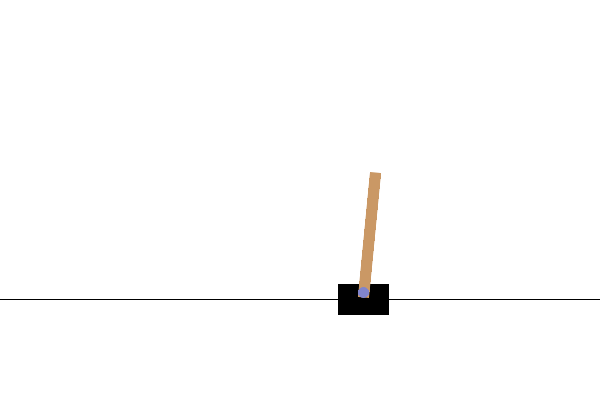

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## Next steps

This tutorial demonstrated how to implement the actor-critic method using Tensorflow.

As a next step, you could try training a model on a different environment in OpenAI Gym. 

For additional information regarding actor-critic methods and the Cartpole-v0 problem, you may refer to the following resources:

- [Actor Critic Method](https://hal.inria.fr/hal-00840470/document)
- [Actor Critic Lecture (CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cartpole learning control problem \[Barto, et al. 1983\]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) 

For more reinforcement learning examples in TensorFlow, you can check the following resources:
- [Reinforcement learning code examples (keras.io)](https://keras.io/examples/rl/)
- [TF-Agents reinforcement learning library](https://www.tensorflow.org/agents)
